# Predicción de Series de Tiempo

### Ejercicio 1. 

Considere la serie de tiempo asociada con los futuros de la criptomoneda **Bitcoin** desde que comenzó a comercializarse hasta la fecha del día de hoy. Utilice la `API de Yahoo Finance` para obtener esta serie de tiempo.

In [1]:
from datetime import datetime, timedelta
import datetime as dt 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import psycopg2
import pandas as pd 
import kaleido
import numpy as np
from scipy.stats import kstest
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.graphics.tsaplots as tsaplots

In [2]:
import yfinance as yf

data = yf.Ticker("BTC-USD")
data.info


{'name': 'Bitcoin',
 'startDate': 1278979200,
 'description': 'Bitcoin (BTC) is a cryptocurrency launched in 2010. Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 19,683,106. The last known price of Bitcoin is 66,797.9989346 USD and is up 3.99 over the last 24 hours. It is currently trading on 11005 active market(s) with $43,228,757,125.25 traded over the last 24 hours. More information can be found at https://bitcoin.org/.',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 65757.31,
 'open': 65757.31,
 'dayLow': 62705.246,
 'dayHigh': 66798.0,
 'regularMarketPreviousClose': 65757.31,
 'regularMarketOpen': 65757.31,
 'regularMarketDayLow': 62705.246,
 'regularMarketDayHigh': 66798.0,
 'volume': 45678395392,
 'regularMarketVolume': 45678395392,
 'averageVolume': 34845841890,
 'averageVolume10days': 36316462166,
 'averageDailyVolume10Day': 36316462166,
 'marketCap': 1246090362880,
 'fiftyTwoWeekLow': 24797.168,
 'fiftyTwoWeekHigh': 73750.

In [3]:
sns.set_theme() #para configurar el tema a usar en las figuras
sns.set_context("paper")

In [133]:
#Defición de parámetros para indexación de datos en BTC_df_sorted
stock = 'BTC-USD'
resolution = '1d'

In [134]:
#indexación de datos en BTC_df_sorted

BTC_df= yf.download("BTC-USD", interval=resolution)
BTC_df_sorted = BTC_df.sort_values(by='Date', ascending=True)
BTC_df_sorted.reset_index(inplace=True)
BTC_df_sorted.head()

[*********************100%%**********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
0 2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1 2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2 2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3 2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4 2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100

Detección de valores atípicos (outliers):

A continuación, se realiza un análisis para identificar la presencia de `outliers` en nuestro conjunto de datos. Para esto usamos el método de detección de valores atípicos mediante las puntuaciones $ Z $, el cual establece el siguiente criterio: `Cualquier` dato cuya `puntuación esté fuera de la tercera desviación estándar es un valor atípico`. 

La función `outliers_zscore` recorrer todos los datos y calcular la puntuación $ Z $ para cada punto de datos utilizando la fórmula  $  \frac{(x_i - \mu)}{\sigma} $, donde $ x_i $ es cada valor de los datos, $ \mu $ es la media de los datos y $ \sigma $ es la desviación estándar de los datos. Luego, establece un umbral en la tercera desviación estandar e identifica como valores atípicos aquellos datos cuya puntuación $ Z $ (en valor absoluto) excede este umbral. 

In [6]:
from IPython.display import display, Markdown

display(Markdown('<center><img src="img/outlierszscore.png" alt="figure"></center>'))

<center><img src="img/outlierszscore.png" alt="figure"></center>

In [135]:
import numpy as np

#Definición de función para detección de datos atípicos a través de ZScore

def outliers_zscore(data):
    outliers = []    
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score = (i - mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers

A continuación, se observan los datos atípicos obtenidos luego de aplicar el método descrito anteriormente. 

In [136]:
BTC_df_outliers= BTC_df_sorted[["Close"]]
Close_outliers = outliers_zscore(BTC_df_outliers.Close)

outliers_df = pd.DataFrame({"Close_Outlieres": Close_outliers})

print("A continuación se imprimen Outliers a través Método Z-scores para el precio de Cierre del Bitcoin: ")
print(outliers_df)

A continuación se imprimen Outliers a través Método Z-scores para el precio de Cierre del Bitcoin: 
    Close_Outlieres
0      68498.882812
1      69019.789062
2      72123.906250
3      71481.289062
4      73083.500000
5      71396.593750
6      69403.773438
7      69958.812500
8      69987.835938
9      69455.343750
10     70744.953125
11     69892.828125
12     69645.304688
13     71333.648438
14     69702.148438
15     68508.843750
16     68896.109375
17     69362.554688
18     71631.359375
19     69139.015625
20     70587.882812
21     70060.609375


Basándonos en los resultados del Método Z-Scores, se confirma la presencia de valores atípicos en nuestro conjunto de datos. No obstante, optamos por no eliminarlos ni aplicar técnicas de imputación, ya que el número de valores atípicos no es significativo en relación con el tamaño total del conjunto de datos.

Gráfico de  `candlestick` de datos de `Bitcoin (BTC-USD)`.

In [137]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as py

df_g = BTC_df_sorted.copy()

fig = go.Figure(data=[go.Candlestick(x = df_g['Date'],
                                     open = df_g['Open'], 
                                     high = df_g['High'],
                                     low = df_g['Low'], 
                                     close = df_g['Close'], 
                                     increasing_line_color='#008080',  # Color de línea de velas alcistas
                                     decreasing_line_color='#B22222',    # Color de línea de velas bajistas
                                     increasing_fillcolor='#B0E0E6',   # Color de relleno de velas alcistas
                                     decreasing_fillcolor='#DB7093'      # Color de relleno de velas bajistas)
                                     )
                        ]
                )      
                     
fig.update_layout(
    title="Bitcoin USD (BTC-USD)",
    xaxis_title="Day",
    yaxis_title="BTC-USD",
    font=dict(
        family="Verdana, monospace",
        size=12,
    )
)
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()


El gráfico de velas (candlestick) representa la evolución del precio de la criptomoneda Bitcoin desde el 17 de Septiembre de 2014 a la fecha, mostrando datos diarios. En este gráfico cada vela representa un día de trading:

* Si el precio de apertura es mayor que el precio de cierre para ese día, la vela se dibuja de color azul, la cola superior de la vela representa el precio máximo alcanzado durante el día y la cola inferior de la vela representa el precio mínimo alcanzado durante el día.  

* Si el precio de cierre es mayor que el precio de apertura para ese día, la vela se dibuja de color rojo. De igual forma la cola superior de la vela representa el precio máximo alcanzado durante el día y la cola inferior de la vela representa el precio mínimo alcanzado durante el día.

En resumen, el gráfico de candlestick ofrece una representación visual de la variación diaria del precio de Bitcoin durante el periodo mencionado, mostrando tanto los rangos de precio máximo y mínimo como la relación entre el precio de apertura y el precio de cierre de cada día.


Serie de tiempo `Bitcoin (BTC-UDS)`.

Text(0.5, 1.0, 'Precio de cierre de Bitcoin a lo largo del tiempo')

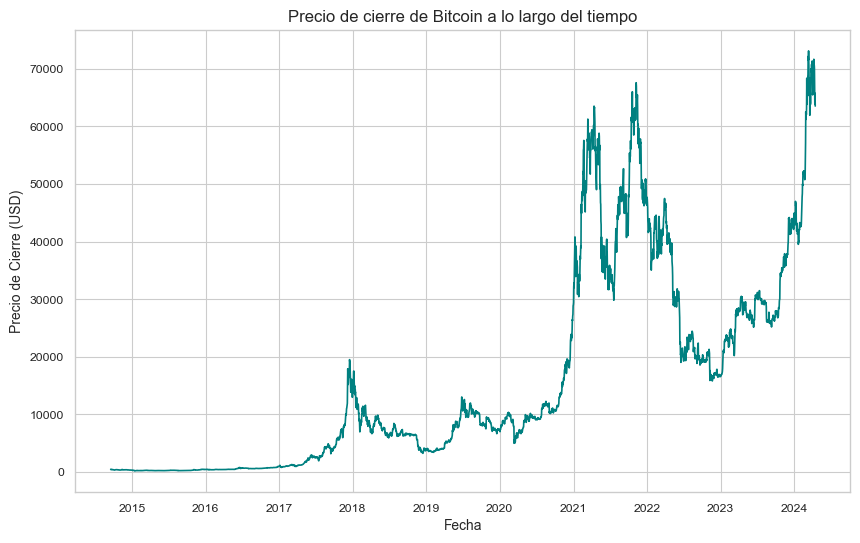

In [138]:
BTC_data = BTC_df_sorted.copy()

# Configurar estilo de seaborn y establecer el fondo en blanco
sns.set_style("whitegrid")

#Gráfico 
sns.lineplot(data=BTC_data, x='Date', y='Close', color='#008080')

# Personalizar etiquetas de los ejes y título del gráfico
plt.xlabel("Fecha", fontsize=10)  # Establecer etiqueta del eje x
plt.ylabel("Precio de Cierre (USD)", fontsize=10)  # Establecer etiqueta del eje y
plt.title("Precio de cierre de Bitcoin a lo largo del tiempo", fontsize=12)  # Establecer título del gráfico

El gráfico ilustra la evolución del precio de Bitcoin desde el 17 de septiembre de 2014 hasta la fecha actual. Durante este período, el precio se mantuvo relativamente estable hasta 2017, momento en el que experimentó un notable aumento. En 2021, hubo un nuevo y significativo incremento, seguido de un declive en 2022. Sin embargo, en 2023 se observa una recuperación y el precio continúa mostrando una tendencia alcista. Dado este comportamiento ascendente a lo largo del tiempo, podemos concluir que el gráfico representa la evolución del precio de Bitcoin. Además, `la serie de tiempo` correspondiente se caracteriza como `no estacionaria`.

Una serie de tiempo se considera `No estacionaria` si la distribución de sus datos (media, varianza, autocorrelación, etc.) `no permanece constante a lo largo del tiempo`, es decir, si  muestra **tendencia**, **variación en la varianza**, **autocorrelación significativa**. 

### Ejercicio 2. 

Repita **TODOS** los pasos indicados en esta sección para encontrar modelos **ARIMA** para predecir el precio de **Bitcoin** con los siguientes horizontes: **7, 14, 21 y 28 días**. Utilizar siempre predicciones `usando rolling` con ventana de predicción continua de un día. Cualquier cantidad de pasos extra para enriquecer su análisis predictivo serán aceptados siempre y cuando sean acordes con lo que indica la teoría de análisis de series de tiempo.

In [139]:
from IPython.display import display, Markdown

display(Markdown('<center><img src="img/ejercicio2.png" alt="figure"></center>'))

<center><img src="img/ejercicio2.png" alt="figure"></center>

#### ¿La serie de tiempo es estacionaria o no es estacionaria?

Primeramente, verificaremos si la serie de tiempo es `NO estacionaria`. Para esto usamos la prueba de `Dickey-Fuller`, ya que, para aplicar un modelo `ARIMA` nuestra serie de tiempo debe ser `estacionaria`. Para esto, procedemos con la instalación de la libreria `statemodels` a través del siguiente comando: 

* pip install statsmodels. 

In [12]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

* Planteamiento de Hipótesis: 

$$ H_0 : \text{La serie de tiempo es no estacionaria.}$$
$$ H_1 : \text{La serie de tiempo es estacionaria.}$$

* Críterios de aceptación y/o rechazo: 

Sí el  P-value $< 0.05 $, se rechaza la hipótesis nula con un a significancia $ \alpha = 0.05$, es decir que la serie de tiempo es estacionaria.


In [140]:
result = adfuller(BTC_df_sorted.Close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -0.800570
p-value: 0.818955


De acuerdo al resultado obtenido con la prueba de `Dickey-Fuller` con P-value $= 0,8189 > 0,05$, por tanto se rechaza la hipótesis alternativa con una significancia $\alpha = 0.05$, es decir que `la serie de tiempo es NO estacionaria`. 

A continuación gráficamos la `Autocorrelación` y `estacionalidad` de la serie de tiempo asociada con los futuros de la criptomoneda `Bitcoin (BTC-USD)`.

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.tsa.stattools import acf
import pandas as pd

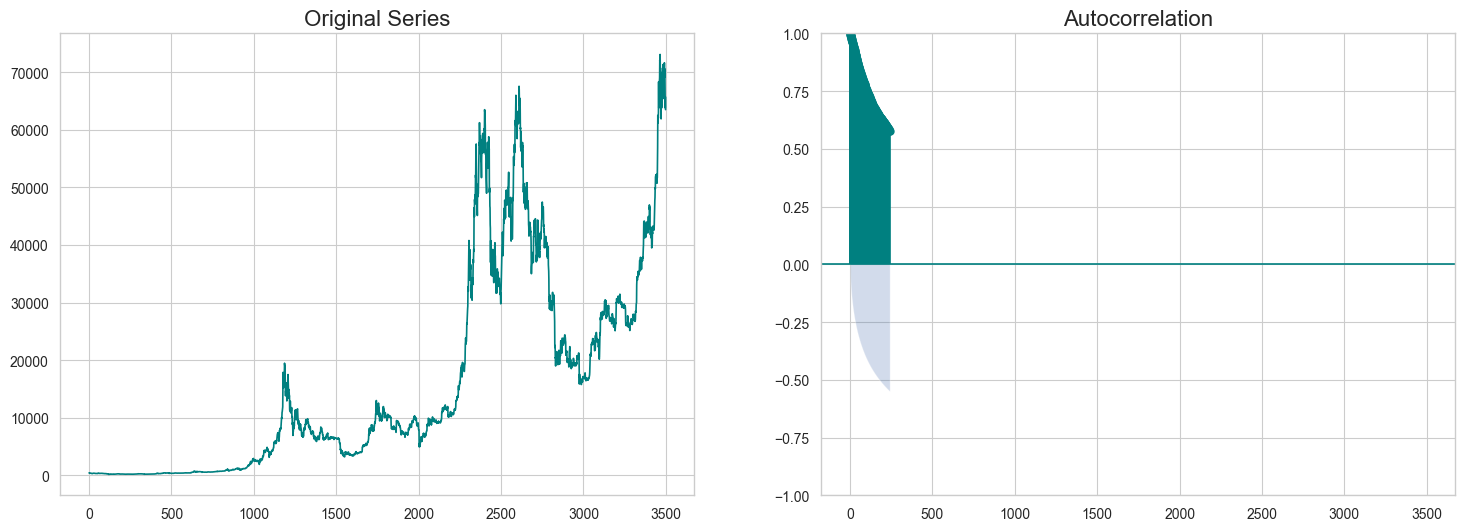

In [141]:

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(18,6))

axes[0].plot(BTC_df_sorted.Close, color ='#008080') 
axes[0].set_title('Original Series', fontsize=16)
axes[0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)

figtest0=plot_acf(BTC_df_sorted.Close, ax=axes[1], lags = 240, color = '#008080', vlines_kwargs ={"colors":'#008080'})
axes[1].set_title('Autocorrelation', fontsize=16)
axes[1].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[1].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)

* Gráfico Original Series: El gráfico representa el comportamiento del precio de la criptomoneda Bitcoin en un periodo de tiempo. Al tener un comportamiento acendente en el tiempo, se puede afirmar que representa la evolución del precio del Bitcoin a lo largo del tiempo. 

* Gráfico Autocorrelation Original Series: Como se puede observar en gráfico ACF, la autocorrelación de la serie con sus rezagos decae lentamente en el tiempo de forma lineal; ésto es coherente con el resultado obtenido luego de aplicar la prueba de `Dickey-Fuller`.  


#### Eliminación de la tendencia entre la serie y sus rezagos. 

La eliminación de la tendencia y de la correlación entre la serie y sus rezagos puede hacerse por diferenciación.

##### Diferenciación de 1er Orden: 

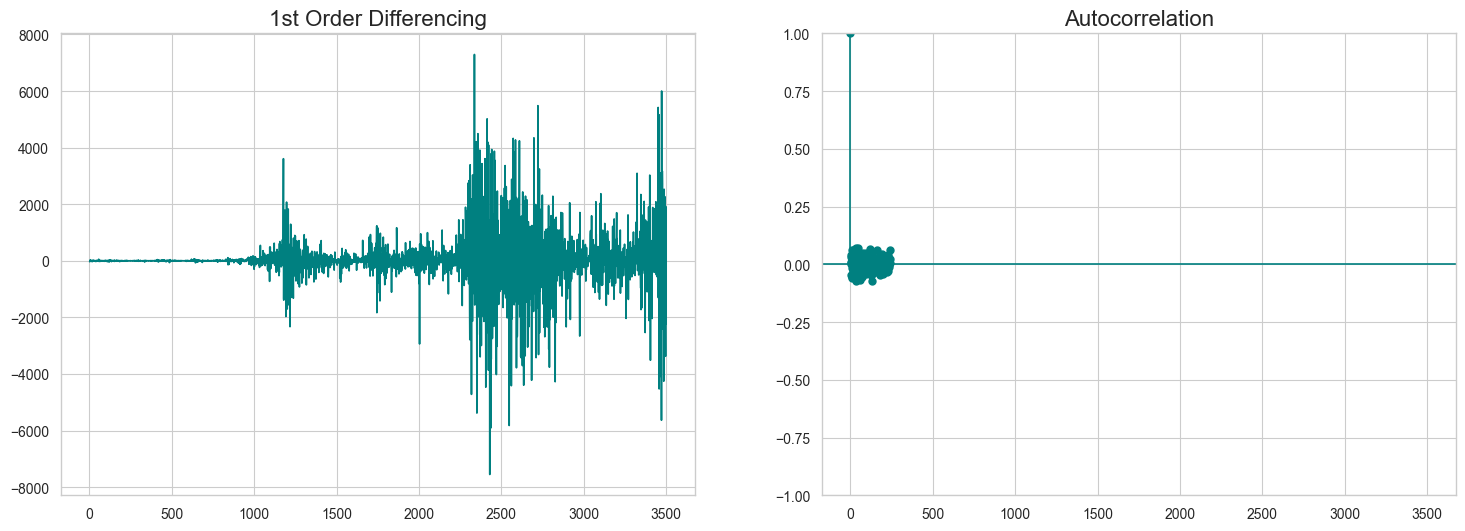

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(18,6))

axes[0].plot(BTC_df_sorted.Close.diff(), color ='#008080'); 
axes[0].set_title('1st Order Differencing', fontsize=16)
axes[0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)

figtest1=plot_acf(BTC_df_sorted.Close.diff().dropna(), ax=axes[1], lags = 240, color = '#008080', vlines_kwargs ={"colors":'#008080'})
axes[1].set_title('Autocorrelation', fontsize=16)
axes[1].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[1].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)


Luego de aplicar una diferenciación de 1er orden, procedemos aplicar nuevamente la prueba de `Dickey-Fuller` para validar si nuestra serie de tiempo es estacionaria.

In [143]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result1 = adfuller(BTC_df_sorted.Close.diff().dropna())
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])

ADF Statistic: -8.749034
p-value: 0.000000


De acuerdo al resultado obtenido con la prueba de `Dickey-Fuller` con P-value $<0.000000$, por tanto no se rechaza la hipótesis nula con una significancia $\alpha = 0.05$, es decir que `la serie de tiempo es estacionaria`. 

##### Diferenciación de 2do Orden: 

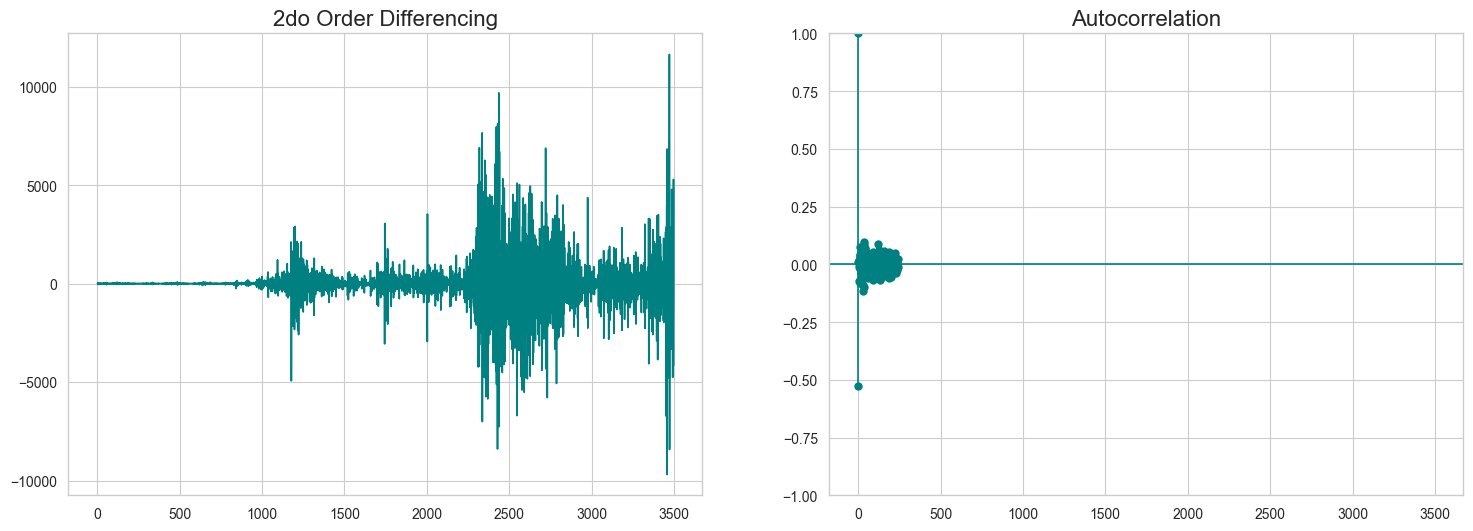

In [144]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(18,6))

axes[0].plot(BTC_df_sorted.Close.diff().diff(), color ='#008080')
axes[0].set_title('2do Order Differencing',fontsize=16)
axes[0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)

figtest2=plot_acf(BTC_df_sorted.Close.diff().diff().dropna(), ax=axes[1], lags = 240, color = '#008080', vlines_kwargs ={"colors":'#008080'})
axes[1].set_title('Autocorrelation', fontsize=16)
axes[1].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[1].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)


Luego de aplicar una diferenciación de 2do orden, procedemos aplicar nuevamente la prueba de `Dickey-Fuller` para validar si nuestra serie de tiempo continua siendo estacionaria.

In [145]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result2 = adfuller(BTC_df_sorted.Close.diff().diff().dropna())
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])

ADF Statistic: -19.950983
p-value: 0.000000


De acuerdo al resultado obtenido con la prueba de `Dickey-Fuller` con P-value $<0.00000$, por tanto no se rechaza la hipótesis nula con una significancia $\alpha = 0.05$, es decir que `la serie de tiempo es no estacionaria`. Sin embargo al momento de análizar el gráfico de autocorrelación para la 2da diferenciación, el retraso entra en el zona negativa muy distante de nuestro limite de tolerancia, lo que indica que la serie podría haber sido sobrediferenciada. 

Por lo tanto, `vamos a fijar el orden de diferenciación como 1`, es decir,  $ d = 1$ . 


#### Construcción de modelo ARIMA para predecir el precio de Bitcoin con los siguientes horizontes: 7, 14, 21 y 28 

#####  Función de Ajuste del modelo y predicciones ARIMA

In [159]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore") # suprimir advertencias durante el ajuste del modelo.


def arima_model_fit(data_df):
    # Realiza predicciones continuas usando un enfoque de desplazamiento
    # y almacena las predicciones en una lista
    data = data_df.copy()

    n_BTC = len(data.Close)
    train_size = n_BTC - 28  # Tamaño del conjunto de entrenamiento - 28 días

    train = data.Close[:train_size]  # Datos de entrenamiento (precios de cierre)
    dates_train = data.Date[:train_size]  # Fechas correspondientes a los datos de entrenamiento

#A través de la siguiente función que depende sólo del input `train` y retornarán los parámetros `p`, `d`, `q` y que definiendo el mejor modelo ARIMA con el menor criterio `AIC` de bondad de ajuste.
#**Nota:** Consideramos el `método: mle`para el cálculo de verosimilitud a través del filtro de Kalman. 

    best_aic = np.inf
    best_bic = np.inf

    best_order = None
    best_mdl = None

    pq_rng = range(4)
    d_rng  = range(2)

    for p in pq_rng:
        for d in d_rng:
            for q in pq_rng:
                try:
                    # print(i, d, j)
                    tmp_mdl = ARIMA(train, order=(p,d,q)).fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p, d, q)
                        best_mdl = tmp_mdl
                except: continue

    print('Best AIC:', best_aic)
    print('Best Order:', best_order)

    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

    model = ARIMA(train, order=best_order)
    model_fit = model.fit()   

    return model_fit, train, dates_train, best_order

##### Función Rolling forecast

In [147]:
def arima_rolling(history, test, best_order): # arima_rolling(train.tolist(), test_nd, best_order)
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

##### Indexación de parámetros para la función arima_model_fit()

La siguiente función devuelve los parámetros `p`, `d`, `q` que definen `el mejor modelo ARIMA` con `el menor criterio AIC (Criterio de Información de Akaike)` de bondad de ajuste. Además, proporciona los resultados del modelo `ARIMA ajustado` para `datos de entrenamiento`, incluyendo las `fechas` correspondientes. También incluye los datos y fechas del modelo `ARIMA de prueba`, aunque estos últimos dos no son directamente visibles en la salida de la función.

In [160]:

model_fit,train,dates_train,best_order = arima_model_fit(BTC_df_sorted)

Best AIC: 56332.824995020936
Best Order: (2, 1, 1)
aic: 56332.82500 | order: (2, 1, 1)


Según el criterio de AIC, se determinó que el modelo ARIMA óptimo es (2,1,1).

**Nota**: La función `auto_arima` de Python es útil en ciertos casos específicos. Sin embargo, este no es uno de ellos, ya que el modelo ARIMA que proporciona es simplemente un `random walk`. Este tipo de modelo predice puramente como un modelo estocástico con dependencia temporal basada únicamente en el punto temporal anterior. Los datos financieros, especialmente los precios de activos como el `Bitcoin`, suelen ser muy volátiles y pueden mostrar comportamientos no lineales o estacionarios cambiantes en el tiempo. Esto puede dificultar que un modelo `auto_arima` capture la complejidad de los datos y construya el mejor modelo. Por esta razón, no utilizaremos esta función.


##### Indexación de parámetros para la función arima_rolling()

La siguiente función devuelve las prediciones, con base a los parámetros `p`, `d`, `q` que definen `el mejor modelo ARIMA` con `el menor criterio AIC (Criterio de Información de Akaike)` de bondad de ajuste, aprovechando datos históricos para pronosticar continuamente el precio futuro del Bitcoin durante un período (horizonte) específico.

* **Horizonte de 7 días**

In [161]:

train_size = len(BTC_df_sorted.Close) - 28
test_7 = BTC_df_sorted.Close[train_size:train_size + 7]
dates_7 = BTC_df_sorted.Date[train_size:train_size + 7]

test_7l = test_7.tolist()
train_7l = train.tolist()
yhat_7  = arima_rolling(train_7l, test_7l, best_order)

predicted=67567.573620, expected=61912.773438


predicted=62055.052353, expected=67913.671875
predicted=67452.852817, expected=65491.390625
predicted=65647.174159, expected=63778.761719
predicted=63809.893130, expected=64062.203125
predicted=63953.255138, expected=67234.171875
predicted=67015.911037, expected=69958.812500


* **Horizonte de 14 días**

In [208]:
train_size = len(BTC_df_sorted.Close) - 28
test_14 = BTC_df_sorted.Close[train_size:train_size + 14]
dates_14 = BTC_df_sorted.Date[train_size:train_size + 14]

test_14l = test_14.tolist()
train_14l = train.tolist()
yhat_14  = arima_rolling(train_14l, test_14l, best_order)

predicted=67567.573620, expected=61912.773438
predicted=62055.052353, expected=67913.671875
predicted=67452.852817, expected=65491.390625
predicted=65647.174159, expected=63778.761719
predicted=63809.893130, expected=64062.203125


predicted=63953.255138, expected=67234.171875
predicted=67015.911037, expected=69958.812500
predicted=69879.627910, expected=69987.835938
predicted=70098.731981, expected=69455.343750
predicted=69564.567703, expected=70744.953125
predicted=70739.722086, expected=69892.828125
predicted=70009.466690, expected=69645.304688
predicted=69692.818301, expected=71333.648438
predicted=71278.447997, expected=69702.148438


* **Horizonte de 21 días**

In [163]:
train_size = len(BTC_df_sorted.Close) - 28
test_21 = BTC_df_sorted.Close[train_size:train_size + 21]
dates_21 = BTC_df_sorted.Date[train_size:train_size + 21]

test_21l = test_21.tolist()
train_21l = train.tolist()
yhat_21  = arima_rolling(train_21l, test_21l, best_order)

predicted=67567.573620, expected=61912.773438
predicted=62055.052353, expected=67913.671875


predicted=67452.852817, expected=65491.390625
predicted=65647.174159, expected=63778.761719
predicted=63809.893130, expected=64062.203125
predicted=63953.255138, expected=67234.171875
predicted=67015.911037, expected=69958.812500
predicted=69879.627910, expected=69987.835938
predicted=70098.731981, expected=69455.343750
predicted=69564.567703, expected=70744.953125
predicted=70739.722086, expected=69892.828125
predicted=70009.466690, expected=69645.304688
predicted=69692.818301, expected=71333.648438
predicted=71278.447997, expected=69702.148438
predicted=69843.221851, expected=65446.972656
predicted=65637.139046, expected=65980.812500
predicted=65844.674178, expected=68508.843750
predicted=68425.250577, expected=67837.640625
predicted=67925.788801, expected=68896.109375
predicted=68896.940589, expected=69362.554688
predicted=69402.120273, expected=71631.359375


* **Horizonte de 28 días**

In [164]:
train_size = len(BTC_df_sorted.Close) - 28
test_28 = BTC_df_sorted.Close[train_size:train_size + 28]
dates_28 = BTC_df_sorted.Date[train_size:train_size + 28]

test_28l = test_28.tolist()
train_28l = train.tolist()
yhat_28  = arima_rolling(train_28l, test_28l, best_order)

predicted=67567.573620, expected=61912.773438
predicted=62055.052353, expected=67913.671875
predicted=67452.852817, expected=65491.390625


predicted=65647.174159, expected=63778.761719
predicted=63809.893130, expected=64062.203125
predicted=63953.255138, expected=67234.171875
predicted=67015.911037, expected=69958.812500
predicted=69879.627910, expected=69987.835938
predicted=70098.731981, expected=69455.343750
predicted=69564.567703, expected=70744.953125
predicted=70739.722086, expected=69892.828125
predicted=70009.466690, expected=69645.304688
predicted=69692.818301, expected=71333.648438
predicted=71278.447997, expected=69702.148438
predicted=69843.221851, expected=65446.972656
predicted=65637.139046, expected=65980.812500
predicted=65844.674178, expected=68508.843750
predicted=68425.250577, expected=67837.640625
predicted=67925.788801, expected=68896.109375
predicted=68896.940589, expected=69362.554688
predicted=69402.120273, expected=71631.359375
predicted=71597.601162, expected=69139.015625
predicted=69345.728911, expected=70587.882812
predicted=70574.710371, expected=70060.609375
predicted=70158.237743, expected=6

##### Gráfica lineplot  modelo ARIMA_rolling para predecir el precio de **Bitcoin** con un horizonte de 7, 14, 21 y 28 días

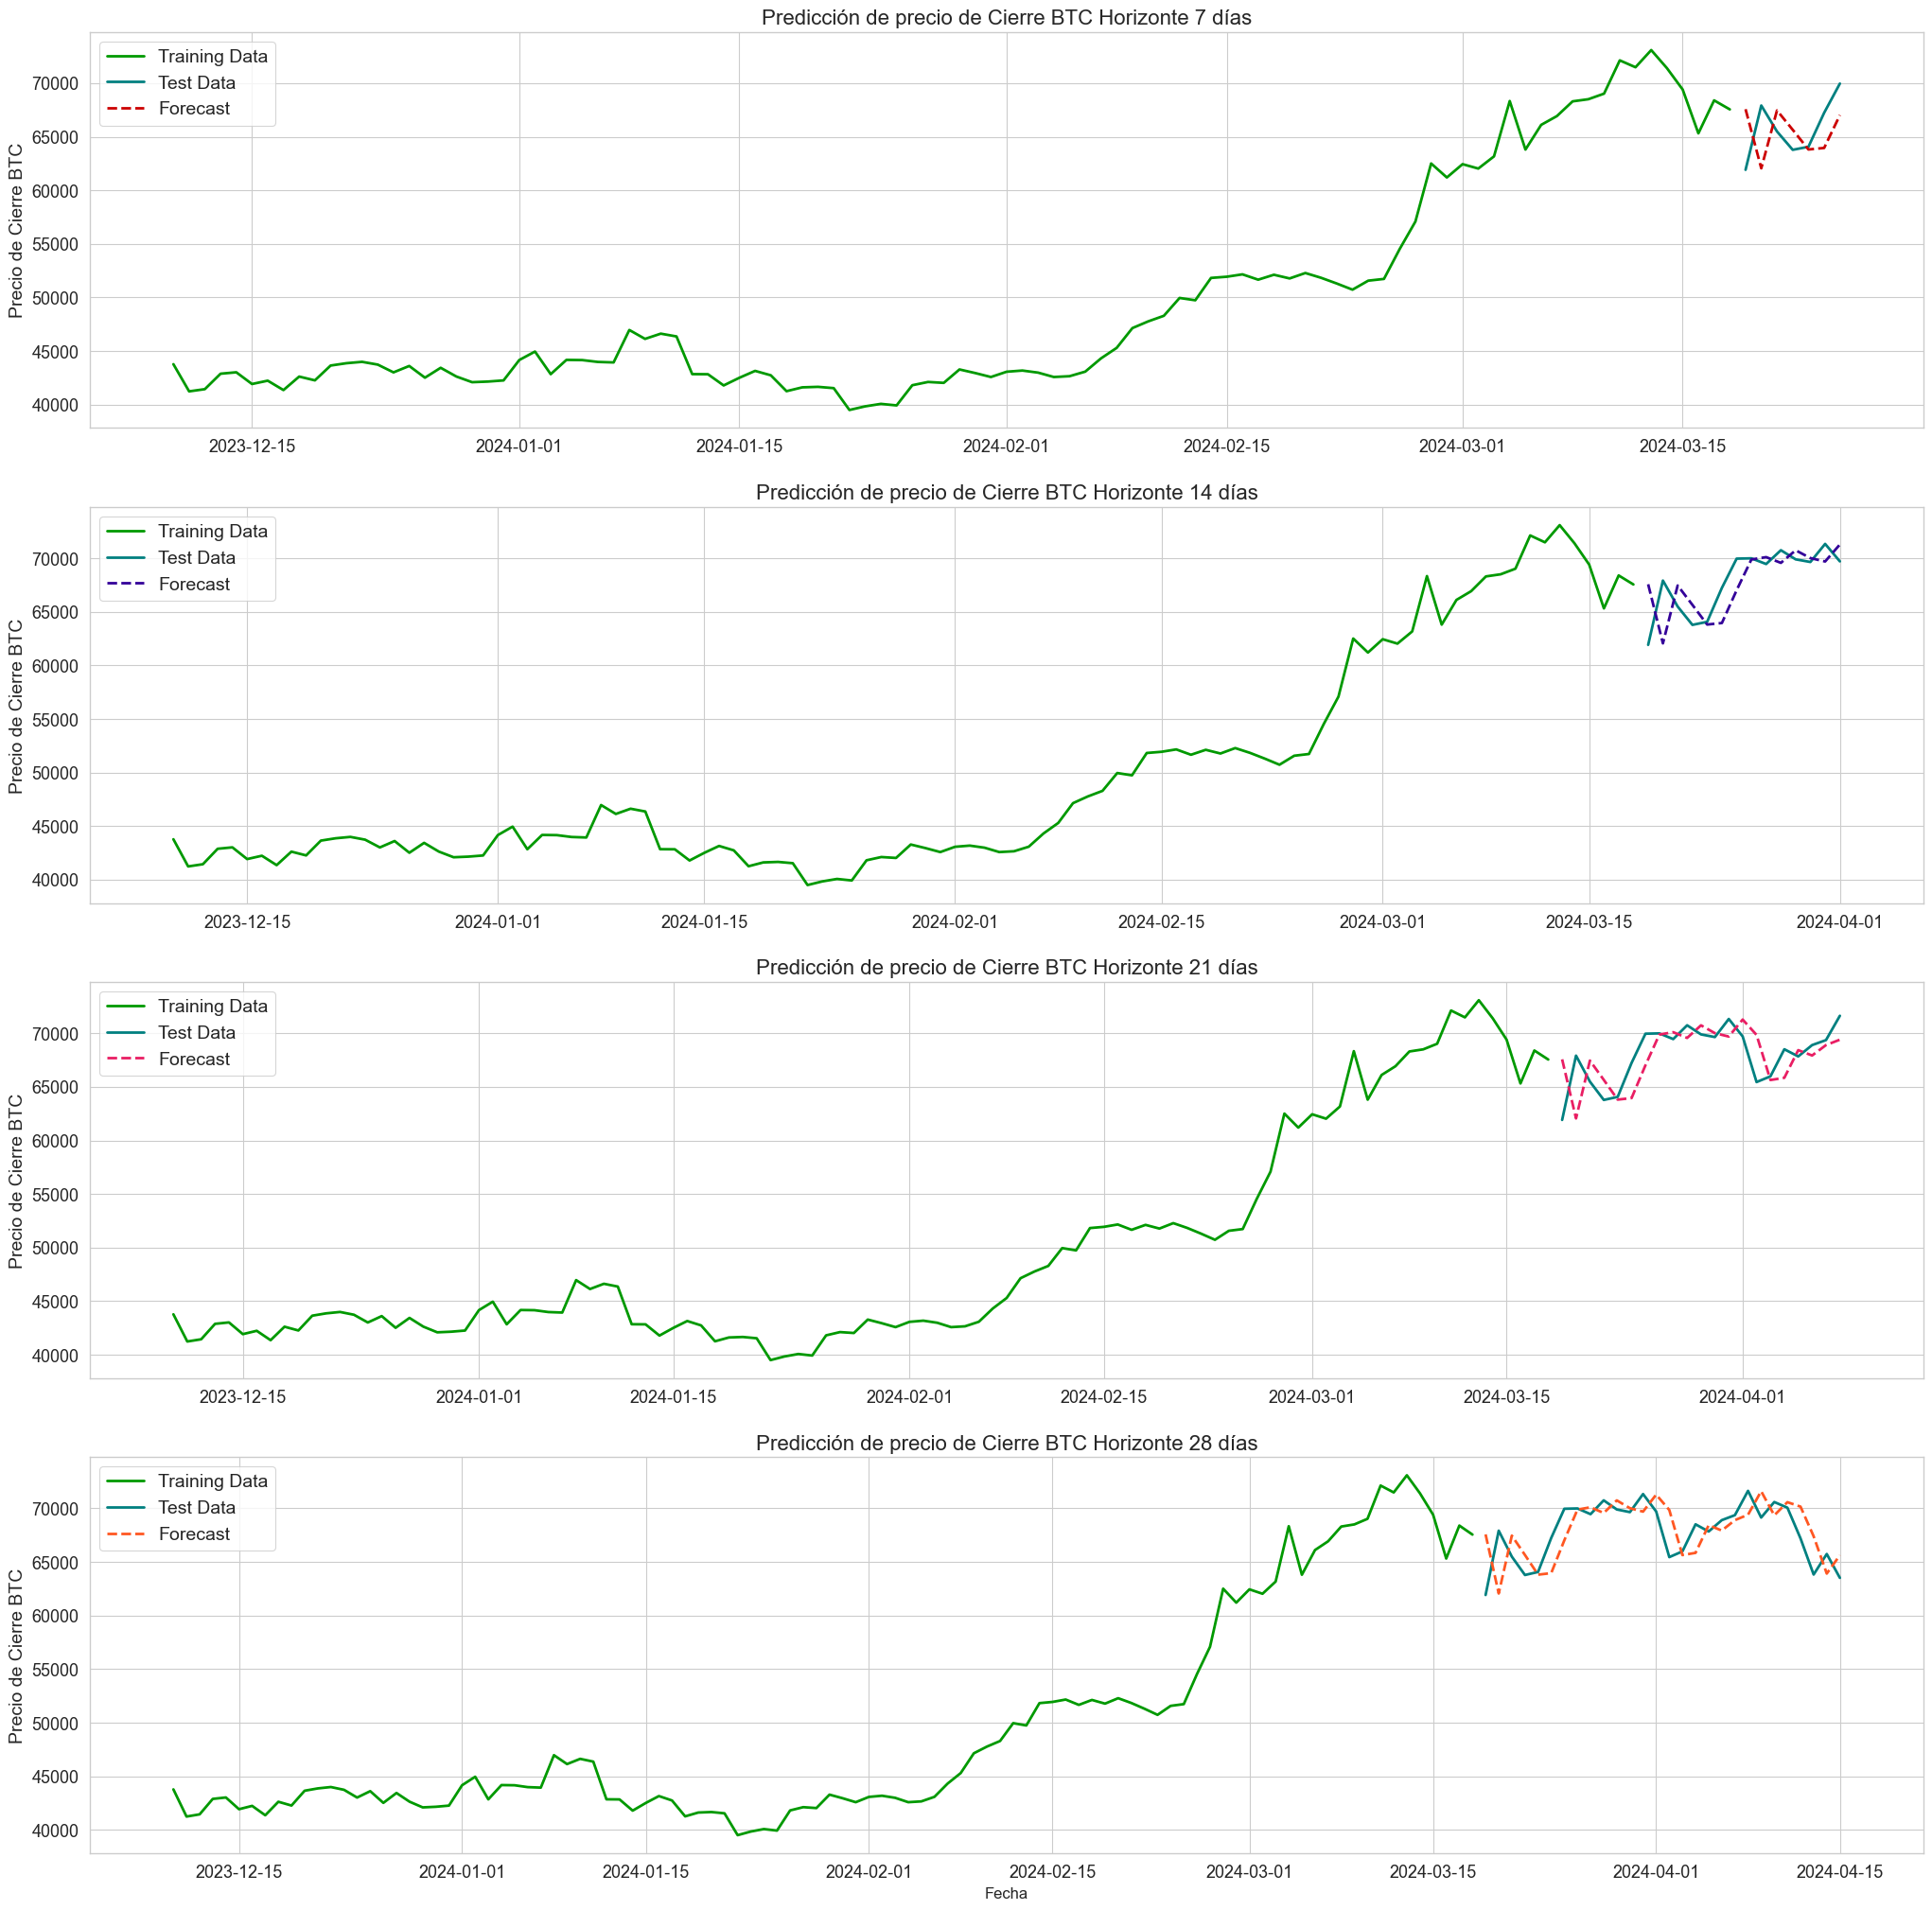

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25, 25)) # Crear la figura y el eje de la subtrama

#Gráfica horizonte 7 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], color='#009900', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_7, y=test_7, ax=axes[0], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=yhat_7, ax=axes[0], label='Forecast', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[0].set_xlabel(None)
axes[0].legend(fontsize=14) # Mostrar la leyenda
axes[0].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[0].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 14 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], color='#009900', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_14, y=test_14, ax=axes[1], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=yhat_14, ax=axes[1], label='Forecast', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[1].set_xlabel(None)
axes[1].legend(fontsize=14) # Mostrar la leyenda
axes[1].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[1].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 21 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[2], color='#009900', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_21, y=test_21, ax=axes[2], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=yhat_21, ax=axes[2], label='Forecast', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[2].set_xlabel(None)
axes[2].legend(fontsize=14) # Mostrar la leyenda
axes[2].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[2].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 28 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[3], color='#009900', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_28, y=test_28, ax=axes[3], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=yhat_28, ax=axes[3], label='Forecast', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[3].set_xlabel('Fecha', fontsize=12)
axes[3].legend(fontsize=14) # Mostrar la leyenda
axes[3].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[3].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

plt.show()

En el gráfico anterior se presentan las predicciones para horizontes de 7, 14, 21 y 28 días. La línea verde representa los datos utilizados para entrenar el modelo ARIMA. La línea azul muestra los datos reales u observaciones correspondientes a cada horizonte, mientras que la línea punteada indica las predicciones generadas por nuestro modelo ARIMA a partir de los datos de entrenamiento. Estas predicciones se comparan con los valores reales de prueba para evaluar la precisión del modelo.


También se aprecia un sesgo entre los datos reales de prueba y las predicciones proporcionadas por nuestro modelo ARIMA, basadas en los datos de entrenamiento.

### Ejercicio 3.

Repita el paso 2 ahora `sin utilizar rolling`. Esto es, realice el pronóstico solo utilizando `forecast()` para los diferentes horizontes de predicción, **7, 14, 21 y 28 días**.

A continuación se ajusta nuestro modelo `ARIMA` utilizando `forecast()` para los diferentes horizontes de predicción, **7, 14, 21 y 28 días**, y así poder visualizar las predicciones del precio de cierre de la criptomoneda **Bitcoin**. 

* **Horizonte de 7 días**

In [187]:
predic_forecast7 = model_fit.forecast(7) 
print(predic_forecast7)

3471    67567.573620
3472    67534.687486
3473    67510.824577
3474    67490.889628
3475    67474.438748
3476    67460.849399
3477    67449.624762
Name: predicted_mean, dtype: float64


* **Horizonte de 14 días**

In [210]:
predic_forecast14 = model_fit.forecast(14) 
print(predic_forecast14)

3471    67567.573620
3472    67534.687486
3473    67510.824577
3474    67490.889628
3475    67474.438748
3476    67460.849399
3477    67449.624762
3478    67440.353285
3479    67432.695110
3480    67426.369511
3481    67421.144610
3482    67416.828878
3483    67413.264114
3484    67410.319643
Name: predicted_mean, dtype: float64


* **Horizonte de 21 días**

In [189]:
predic_forecast21 = model_fit.forecast(21) 
print(predic_forecast21)

3471    67567.573620
3472    67534.687486
3473    67510.824577
3474    67490.889628
3475    67474.438748
3476    67460.849399
3477    67449.624762
3478    67440.353285
3479    67432.695110
3480    67426.369511
3481    67421.144610
3482    67416.828878
3483    67413.264114
3484    67410.319643
3485    67407.887531
3486    67405.878624
3487    67404.219280
3488    67402.848673
3489    67401.716562
3490    67400.781446
3491    67400.009047
Name: predicted_mean, dtype: float64


* **Horizonte de 28 días**

In [190]:
predic_forecast28 = model_fit.forecast(28) 
print(predic_forecast28)

3471    67567.573620
3472    67534.687486
3473    67510.824577
3474    67490.889628
3475    67474.438748
3476    67460.849399
3477    67449.624762
3478    67440.353285
3479    67432.695110
3480    67426.369511
3481    67421.144610
3482    67416.828878
3483    67413.264114
3484    67410.319643
3485    67407.887531
3486    67405.878624
3487    67404.219280
3488    67402.848673
3489    67401.716562
3490    67400.781446
3491    67400.009047
3492    67399.371050
3493    67398.844069
3494    67398.408787
3495    67398.049247
3496    67397.752269
3497    67397.506968
3498    67397.304350
Name: predicted_mean, dtype: float64


##### Gráfica lineplot  modelo ARIMA para predecir el precio de **Bitcoin** con un horizonte de 7, 14, 21 y 28 días

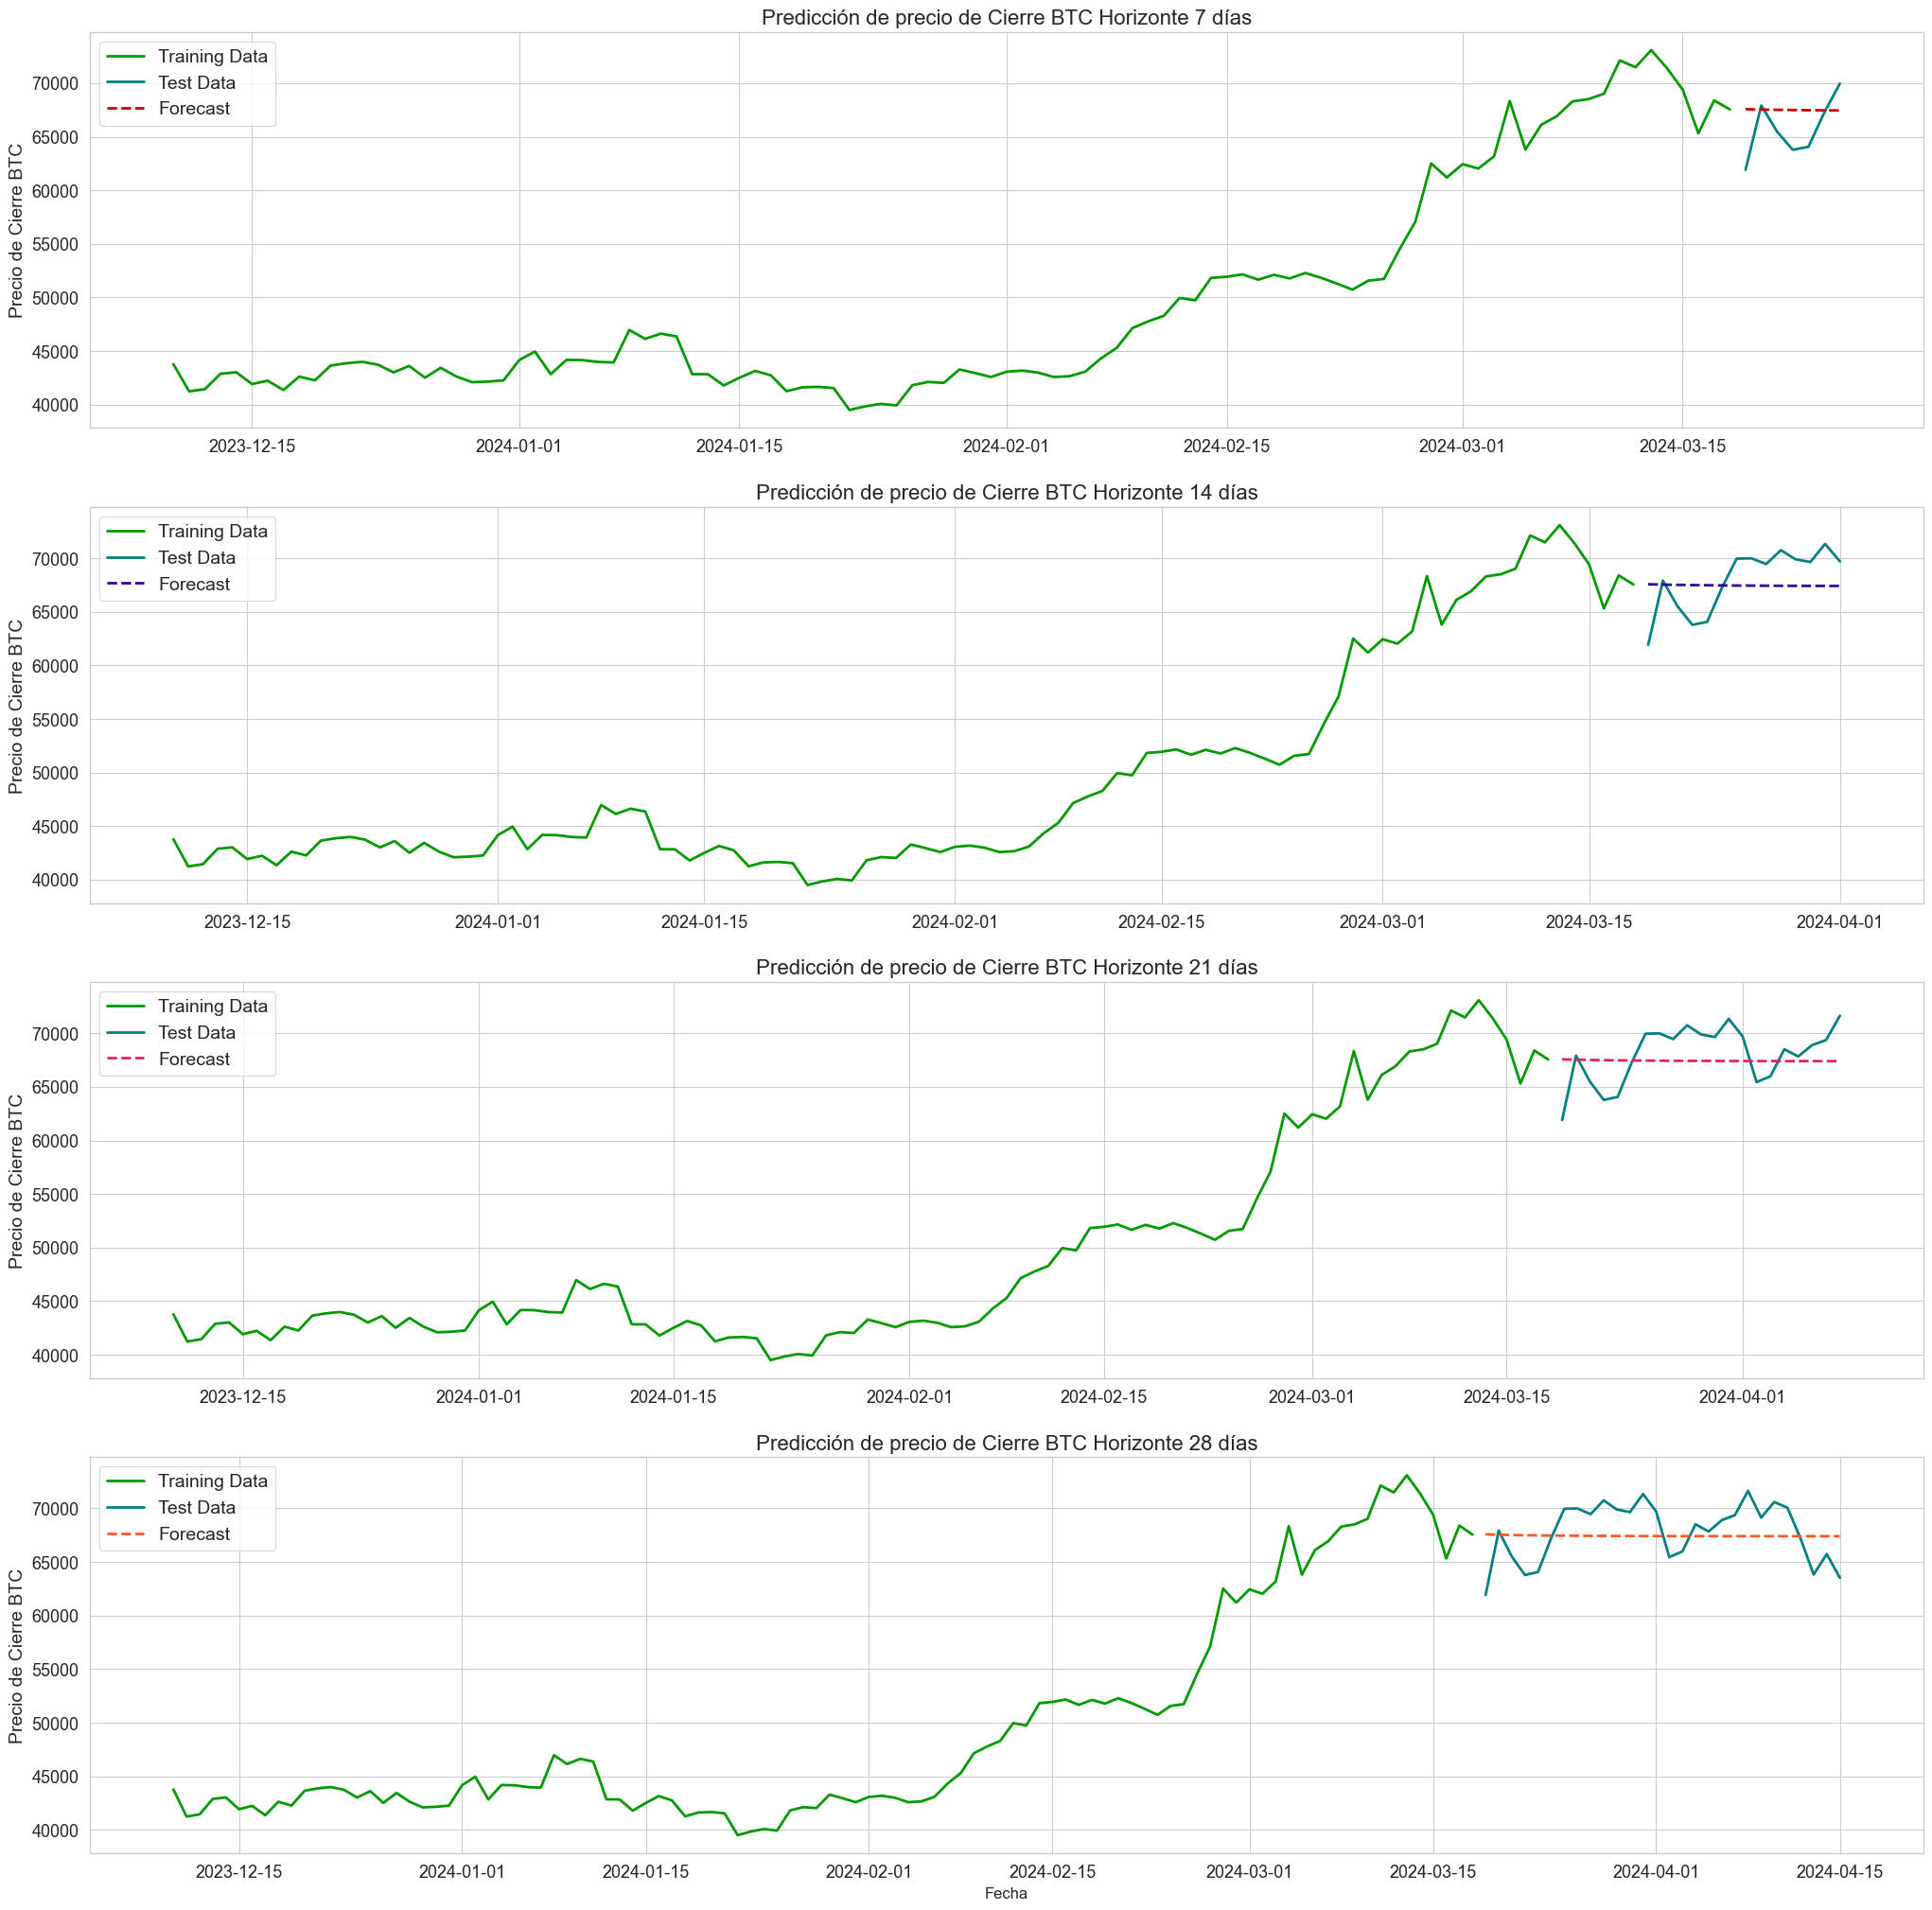

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25, 25)) # Crear la figura y el eje de la subtrama

#Gráfica horizonte 7 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], color='#009900', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_7, y=test_7, ax=axes[0], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=predic_forecast7, ax=axes[0], label='Forecast', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[0].set_xlabel(None)
axes[0].legend(fontsize=14) # Mostrar la leyenda
axes[0].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[0].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 14 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], color='#009900', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_14, y=test_14, ax=axes[1], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=predic_forecast14, ax=axes[1], label='Forecast', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[1].set_xlabel(None)
axes[1].legend(fontsize=14) # Mostrar la leyenda
axes[1].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[1].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 21 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[2], color='#009900', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_21, y=test_21, ax=axes[2], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=predic_forecast21, ax=axes[2], label='Forecast', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[2].set_xlabel(None)
axes[2].legend(fontsize=14) # Mostrar la leyenda
axes[2].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[2].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 28 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[3], color='#009900', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_28, y=test_28, ax=axes[3], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=predic_forecast28, ax=axes[3], label='Forecast', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[3].set_xlabel('Fecha', fontsize=12)
axes[3].legend(fontsize=14) # Mostrar la leyenda
axes[3].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[3].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

plt.show()


El gráfico previo representa la predicción del modelo ARIMA sin utilizar el método rolling, con un horizonte de pronóstico de un período. En el contexto de nuestros modelos ARIMA, este período se define por los días definidos en cada uno de nuestros horizontes. El gráfico muestra la predicción para 7, 14, 21 y 28 días que le anteceden al último dato disponible en el conjunto de datos original. Además, se observan diferencias significativas entre las observaciones de prueba y las predicciones realizadas para cada uno de los horizontes. 

### Ejercicio 4. 

Realice `tablas de error` para los ejercicios 1 y 2, utilizando las métricas: `MAPE`, `MAE`, `RMSE`, `MSE`, `R2`. Además, agregue el `gráfico de correlación` entre la `observación real` y su `predicción en el test`,  $ Corr(y_t, \tilde{y}_t) $.

#### Tablas de error para los ejercicios 2 (usando rolling) y 3 (sin utilizar rolling), utilizando las métricas: MAPE, MAE, RMSE, MSE, R2.

Para medir el error de predicción cometido en las predicciones, utilizaremos las métricas usuales en análisis de series de tiempo: `MAPE`, `MAE`, `RMSE`, `MSE`, `R2`, la cuales se calcularán a través de la siguiente función: 

In [32]:
from sklearn.metrics import r2_score

def forecast_accuracy(forecast, actual, str_name):
    # Calcula diferentes métricas de evaluación (MAPE, MAE, RMSE, MSE, R2)
    # y las almacena en un DataFrame
    
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual)) # Calcular el Error Porcentual Absoluto Medio (MAPE)     
    mae = np.mean(np.abs(forecast - actual)) # Calcular el Error Absoluto Medio (MAE)
    rmse = np.mean((forecast - actual)**2)**0.5 # Calcular la Raíz del Error Cuadrático Medio (RMSE)
    mse = np.mean((forecast - actual)**2) # Calcular el Error Cuadrático Medio (MSE)
    r2 = r2_score(forecast, actual) # Calcular el Coeficiente de Determinación (R2)
    
    # Crear un DataFrame con las métricas calculadas
    df_acc = pd.DataFrame({
        'MAPE': [mape],
        'MAE': [mae],
        'RMSE': [rmse],
        'MSE': [mse],               
        'R2': [r2]
    }, index=[str_name])  # Usar el nombre proporcionado como índice
    
    return df_acc


##### Evaluación de las predicciones ejercicio 2 (usando rolling). 

* **Horizonte de 7 días**

In [192]:
forecast_accuracy(np.array(yhat_7), np.array(test_7l), "7 días")

MAPE          MAE         RMSE           MSE        R2
7 días  0.047378  3117.060362  3647.449809  1.330389e+07 -2.400999

* **Horizonte de 14 días**

In [193]:
forecast_accuracy(np.array(yhat_14), np.array(test_14l), "14 días")

MAPE          MAE         RMSE           MSE        R2
14 días  0.047378  3117.060362  3647.449809  1.330389e+07 -2.400999

* **Horizonte de 21 días**

In [194]:
forecast_accuracy(np.array(yhat_21), np.array(test_21l), "21 días")

MAPE          MAE         RMSE           MSE       R2
21 días  0.028284  1896.974563  2525.952097  6.380434e+06 -0.04772

* **Horizonte de 28 días**

In [195]:
forecast_accuracy(np.array(yhat_28), np.array(test_28l), "28 días")

MAPE          MAE         RMSE           MSE        R2
28 días  0.029127  1947.296649  2472.463507  6.113076e+06  0.033748

Las métricas de precisión (MAPE, MAE, RMSE, MSE) muestran que las predicciones del modelo tienen errores bajos en promedio, el coeficiente de determinación (R2) revela que los modelos no logran explicar significativamente la variabilidad en los datos para ningún horizonte de tiempo. Esto sugiere que, aunque las predicciones son precisas en términos absolutos, el modelo aún no captura adecuadamente la complejidad de los datos y puede necesitar ajustes adicionales. 

##### Evaluación de las predicciones ejercicio 3  (Sin utilizar rolling). 

* **Horizonte de 7 días**

In [196]:
forecast_accuracy(np.array(predic_forecast7), np.array(test_7l), "7 días")

MAPE          MAE         RMSE           MSE           R2
7 días  0.039779  2559.063903  3116.068015  9.709880e+06 -6365.681592

* **Horizonte de 14 días**

In [212]:
forecast_accuracy(np.array(predic_forecast14), np.array(test_14l), "14 días")

MAPE          MAE         RMSE           MSE           R2
14 días  0.039006  2622.466762  2943.032304  8.661439e+06 -3874.867829

* **Horizonte de 21 días**

In [201]:
forecast_accuracy(np.array(predic_forecast21), np.array(test_21l), "21 días")

MAPE          MAE         RMSE           MSE           R2
21 días  0.034725  2348.926118  2695.070258  7.263404e+06 -3265.627476

* **Horizonte de 28 días**

In [202]:
forecast_accuracy(np.array(predic_forecast28), np.array(test_28l), "28 días")

MAPE          MAE         RMSE           MSE           R2
28 días  0.035108  2365.752368  2695.859085  7.267656e+06 -3595.073313

Las métricas de precisión (MAPE, MAE, RMSE, MSE) muestran que: 

* Para el horizonte de 7 días, el modelo tiene un alto R2, lo que sugiere que explica gran parte de la variabilidad en los datos. Sin embargo, el MAE, MSE y MAPE son altos, indicando que las predicciones pueden tener errores significativos tanto en términos absolutos como porcentuales.

* Para el horizonte de 14 días, el modelo muestra un R2 extremadamente alto, pero el MAE, MSE y MAPE son mayores en comparación con el horizonte de 7 días, lo que sugiere una precisión ligeramente menor en la magnitud de los errores.

* Para los horizontes de 21 días y 28 días, los modelos tienen un R2 más bajo, lo que indica que explican menos variabilidad en los datos. Sin embargo, en términos de magnitud de los errores, son comparables a los horizontes de 7 días y 14 días.

En general, la precisión de las predicciones del modelo ARIMA sin utilizar Rolling parece ser deficiente, ya que se observan errores considerablemente significativos tanto en términos absolutos como porcentuales en todos los horizontes de tiempo evaluados.

A continuación se presenta análisis de `correlación` entre variables (`observación real` y su `predicción en el test`,  $ Corr(y_t, \tilde{y}_t) $.) para evaluar `la relación lineal` entre éstas a través de mapa de calor..


#### Gráfico de correlación entre la observación real y su predicción en el test,  $ Corr(y_t, \tilde{y}_t) $.

##### Gráfico de Correlación  ejercicio 2 (usando rolling). . 

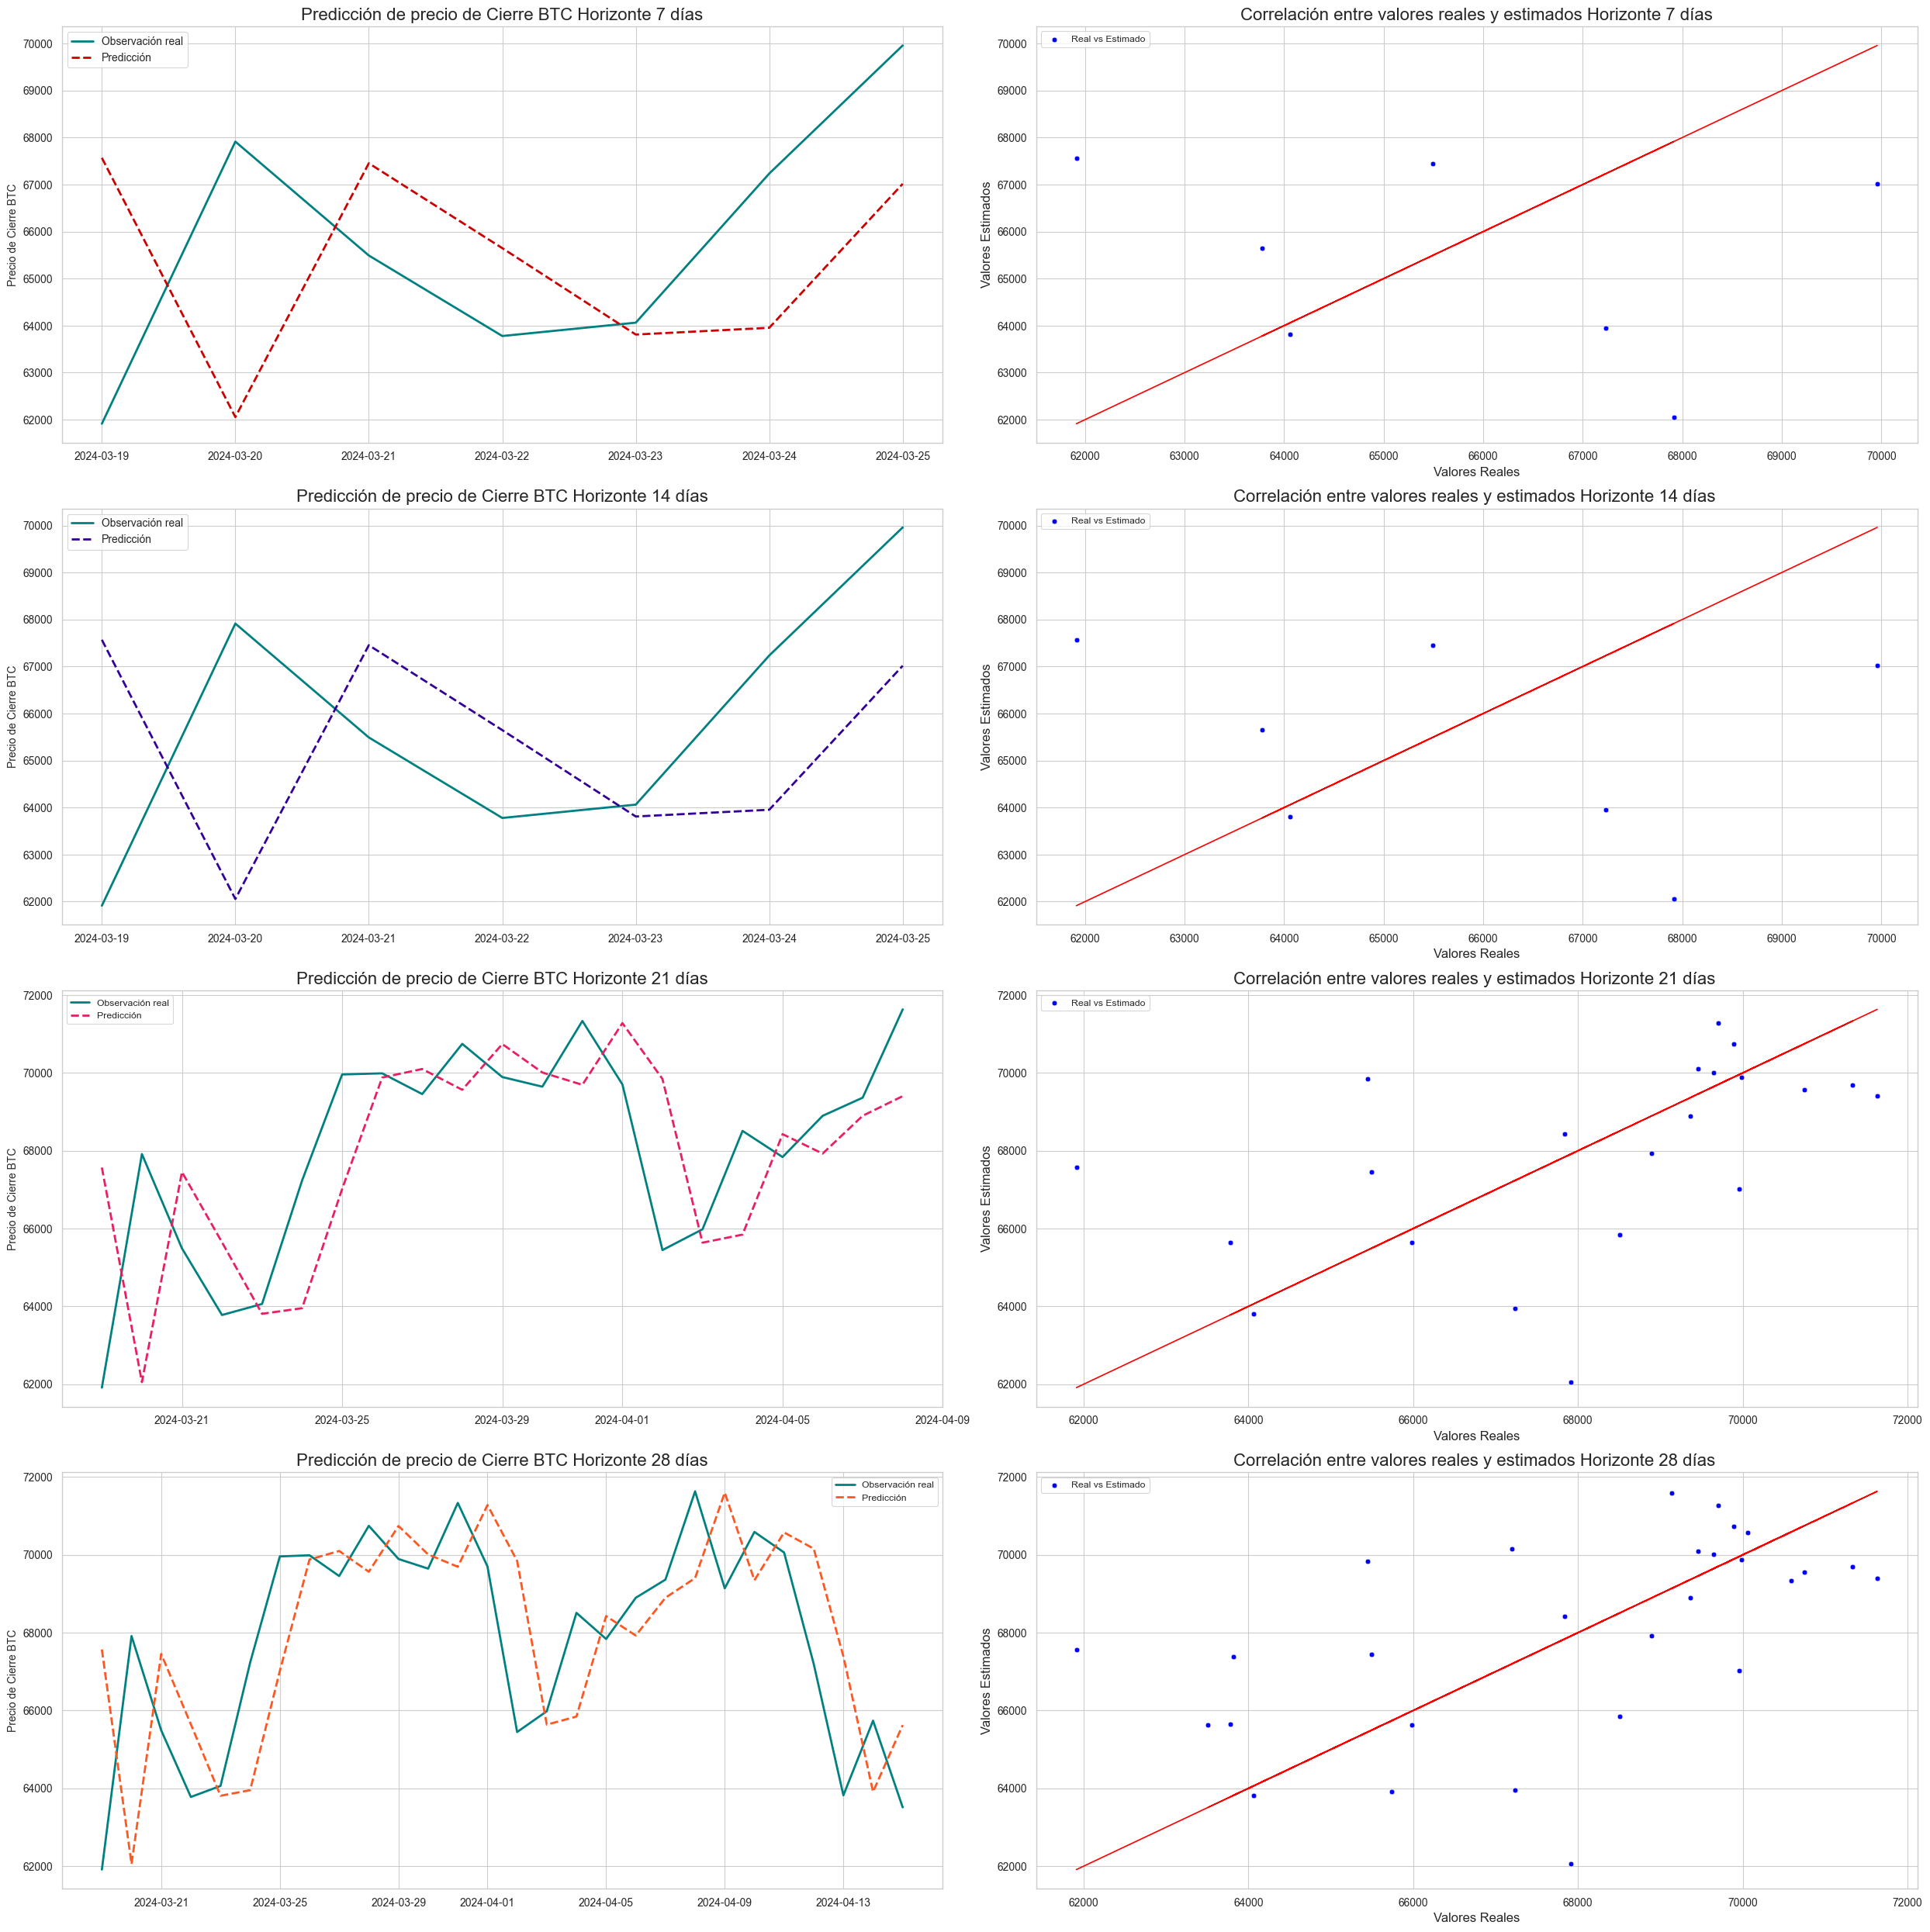

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))  # Crear la figura y el eje de la subtrama

# Gráfica horizonte 7 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_7, y=test_7, ax=axes[0,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=yhat_7, ax=axes[0,0], label='Predicción', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0,0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[0,0].set_xlabel(None)
axes[0,0].legend(fontsize=10) # Mostrar la leyenda
axes[0,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[0,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_7l, y=yhat_7, ax=axes[0,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[0,1].plot(test_7l, test_7l, color='red', label='Correlación')
axes[0,1].set_title('Correlación entre valores reales y estimados Horizonte 7 días', fontsize=16)
axes[0,1].set_xlabel('Valores Reales', fontsize=12)
axes[0,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[0,1].legend(fontsize=10)  # Mostrar la leyenda
axes[0,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[0,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)

# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_14, y=test_14, ax=axes[1,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=yhat_14, ax=axes[1,0], label='Predicción', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1,0].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[1,0].set_xlabel(None)
axes[1,0].legend(fontsize=10) # Mostrar la leyenda
axes[1,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[1,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_14l, y=yhat_14, ax=axes[1,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[1,1].plot(test_14l, test_14l, color='red', label='Correlación')
axes[1,1].set_title('Correlación entre valores reales y estimados Horizonte 14 días ', fontsize=16)
axes[1,1].set_xlabel('Valores Reales', fontsize=12)
axes[1,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[1,1].legend(fontsize=10)  # Mostrar la leyenda
axes[1,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[1,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_21, y=test_21, ax=axes[2,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=yhat_21, ax=axes[2,0], label='Predicción', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2,0].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[2,0].set_xlabel(None)
#axes[2,0].legend(fontsize=10) # Mostrar la leyenda
axes[2,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[2,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_21l, y=yhat_21, ax=axes[2,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[2,1].plot(test_21l, test_21l, color='red', label='Correlación')
axes[2,1].set_title('Correlación entre valores reales y estimados Horizonte 21 días ', fontsize=16)
axes[2,1].set_xlabel('Valores Reales', fontsize=12)
axes[2,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[2,1].legend(fontsize=10)  # Mostrar la leyenda
axes[2,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[2,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_28, y=test_28, ax=axes[3,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=yhat_28, ax=axes[3,0], label='Predicción', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3,0].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[3,0].set_xlabel(None)
#axes[3,0].legend(fontsize=10) # Mostrar la leyenda
axes[3,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[3,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_28l, y=yhat_28, ax=axes[3,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[3,1].plot(test_28l, test_28l, color='red', label='Correlación')
axes[3,1].set_title('Correlación entre valores reales y estimados Horizonte 28 días ', fontsize=16)
axes[3,1].set_xlabel('Valores Reales', fontsize=12)
axes[3,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[3,1].legend(fontsize=10)  # Mostrar la leyenda
axes[3,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[3,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)



plt.tight_layout()  # Ajustar el espaciado entre subgráficos
plt.show()


El gráfico muestra predicciones para diferentes horizontes temporales (7, 14, 21 y 28 días) junto con observaciones reales de prueba. También se incluye un gráfico que correlaciona las predicciones con estas observaciones reales.
En relación al primer gráfico del precio de cierre del Bitcoin, se aprecia que ambas líneas siguen tendencias similares y están próximas entre sí, lo que indica errores bajos. Sin embargo, se observa un sesgo en el tiempo que podría corregirse mediante mejoras en el modelo o la exploración de otras opciones que expliquen con mayor precisión la variabilidad en el tiempo. 
Los gráficos de autocorrelación revelan la ausencia de una correlación significativa entre los valores de la serie temporal y sus antecesores en los intervalos de 7, 14, 21 y 28 días. En resumen, no se observa un patrón claro o repetitivo en los datos a lo largo de estos horizontes.

##### Gráfico de Correlación ejercicio 3  (Sin utilizar rolling). 

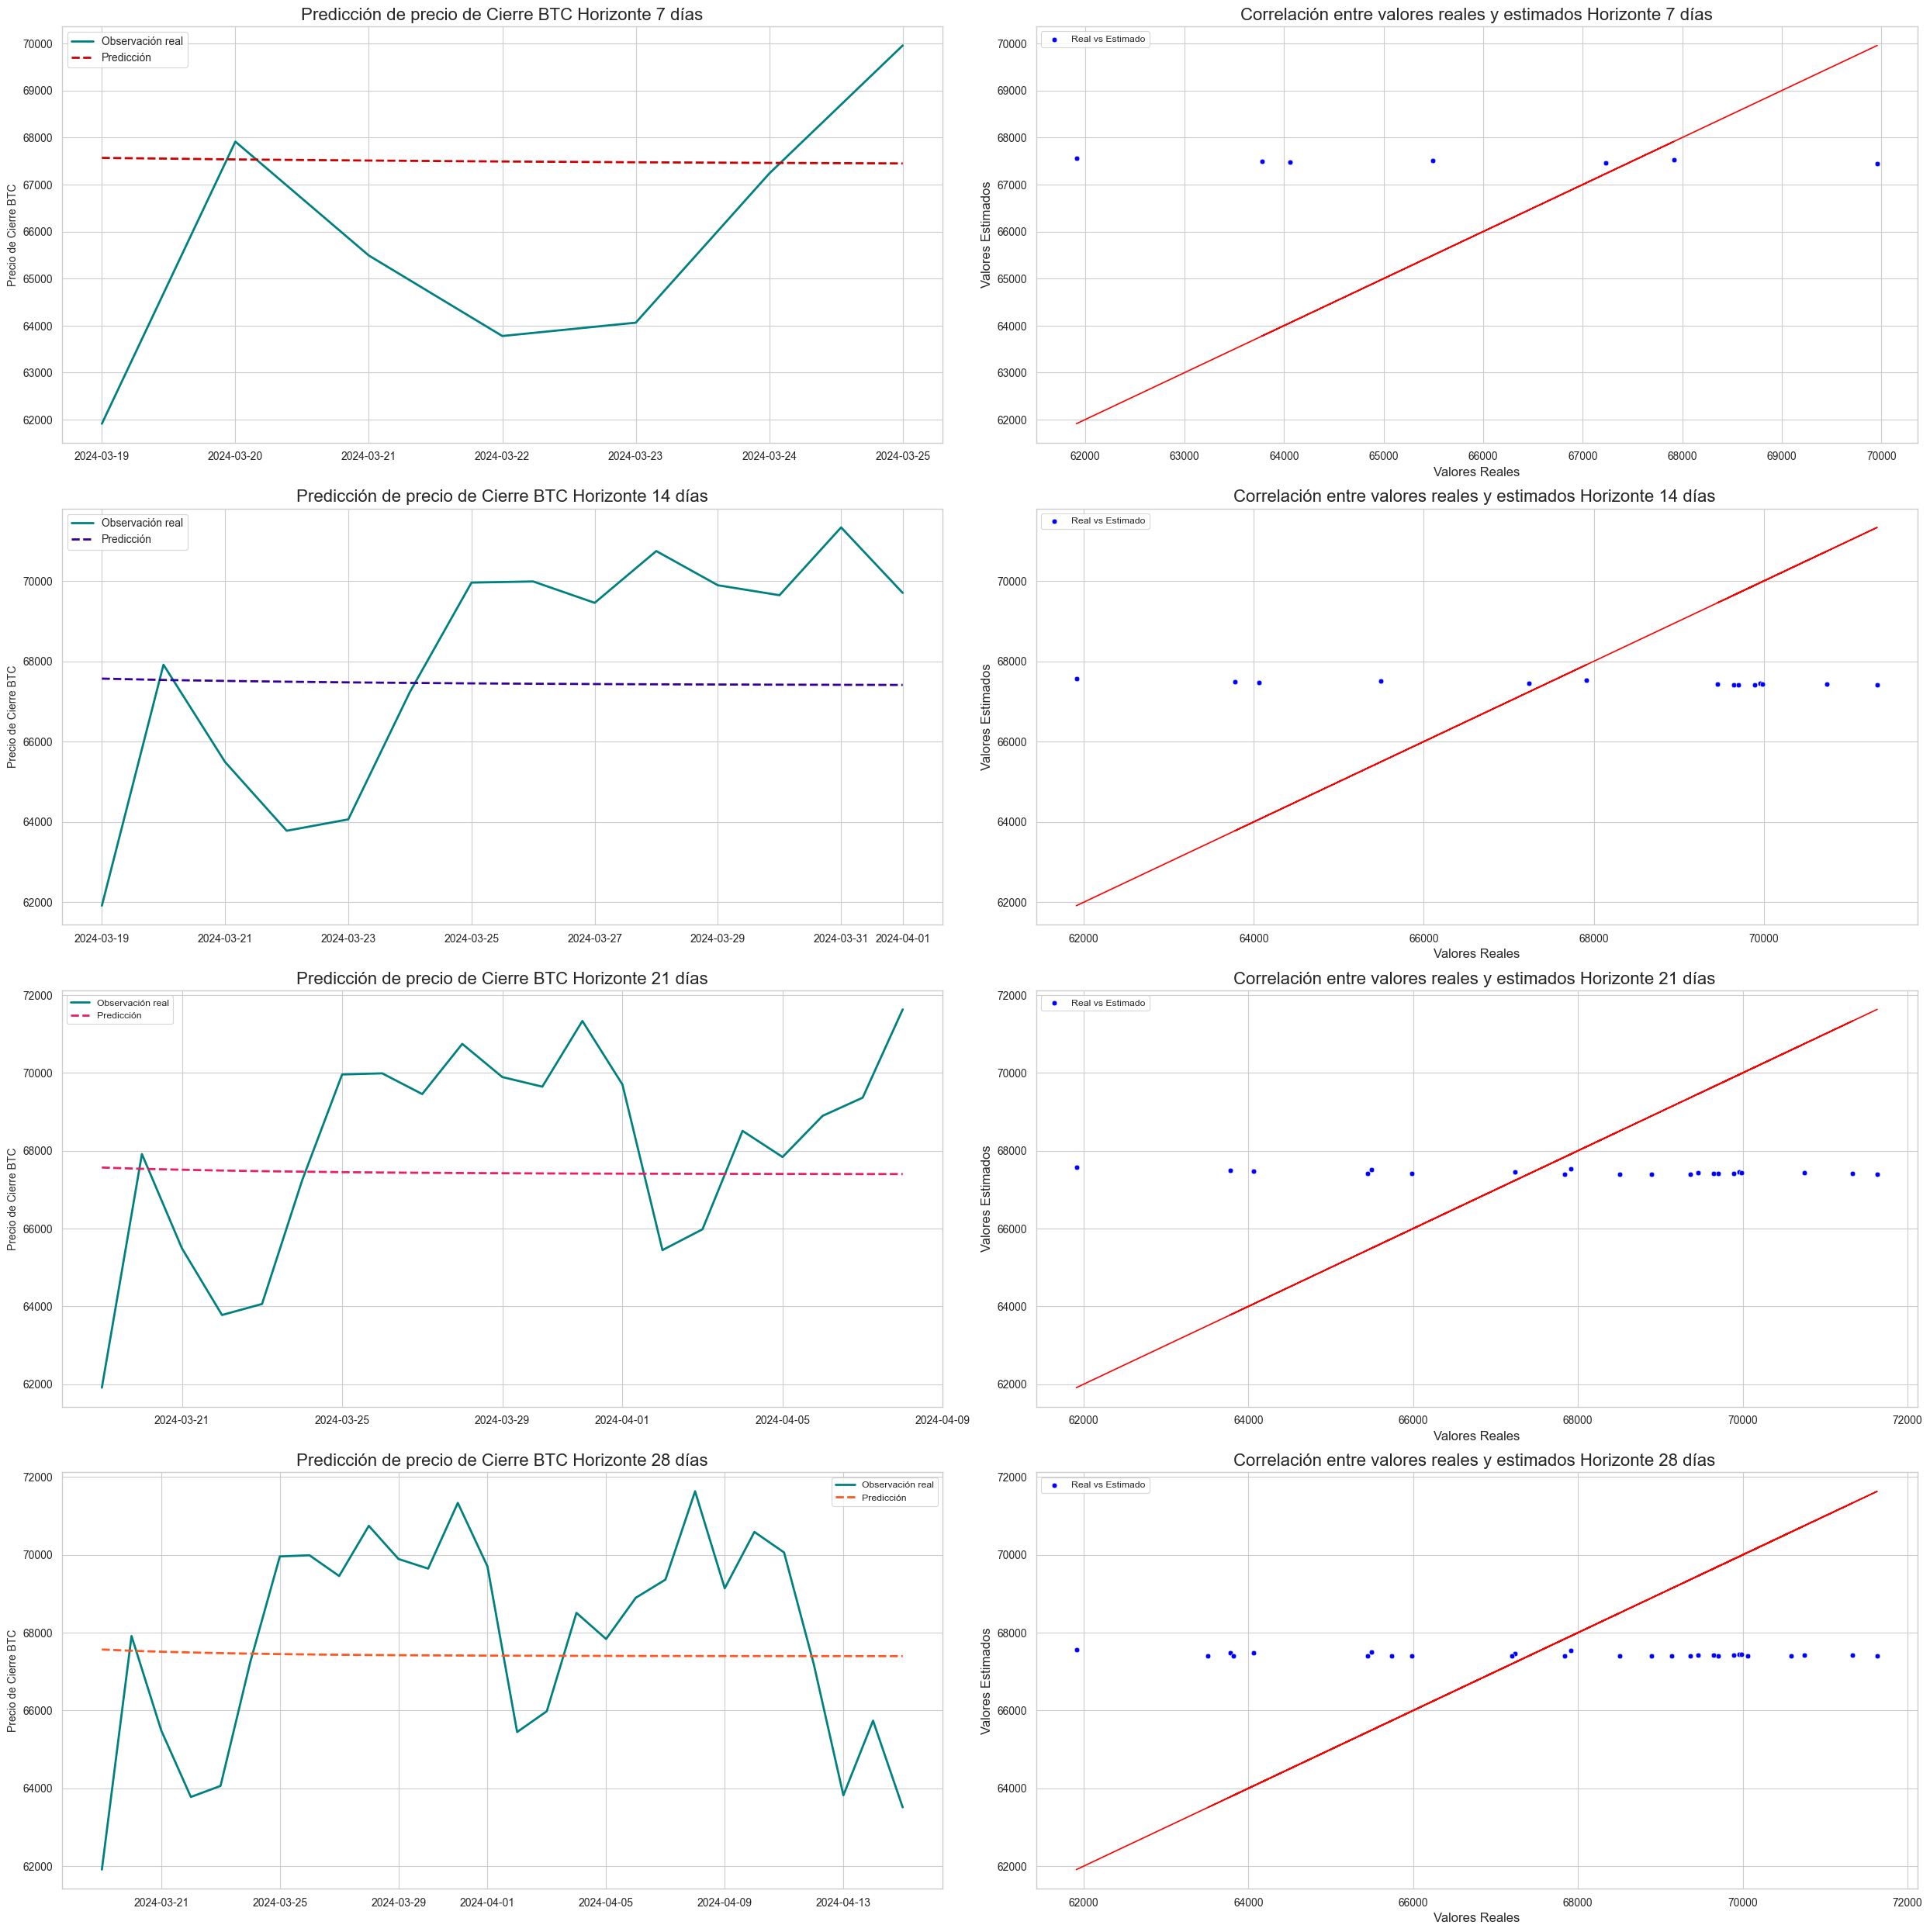

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))  # Crear la figura y el eje de la subtrama

# Gráfica horizonte 7 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_7, y=test_7, ax=axes[0,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=predic_forecast7, ax=axes[0,0], label='Predicción', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0,0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[0,0].set_xlabel(None)
axes[0,0].legend(fontsize=10) # Mostrar la leyenda
axes[0,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[0,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_7l, y=predic_forecast7, ax=axes[0,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[0,1].plot(test_7l, test_7l, color='red', label='Correlación')
axes[0,1].set_title('Correlación entre valores reales y estimados Horizonte 7 días', fontsize=16)
axes[0,1].set_xlabel('Valores Reales', fontsize=12)
axes[0,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[0,1].legend(fontsize=10)  # Mostrar la leyenda
axes[0,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[0,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)

# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_14, y=test_14, ax=axes[1,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=predic_forecast14, ax=axes[1,0], label='Predicción', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1,0].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[1,0].set_xlabel(None)
axes[1,0].legend(fontsize=10) # Mostrar la leyenda
axes[1,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[1,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_14l, y=predic_forecast14, ax=axes[1,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[1,1].plot(test_14l, test_14l, color='red', label='Correlación')
axes[1,1].set_title('Correlación entre valores reales y estimados Horizonte 14 días ', fontsize=16)
axes[1,1].set_xlabel('Valores Reales', fontsize=12)
axes[1,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[1,1].legend(fontsize=10)  # Mostrar la leyenda
axes[1,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[1,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_21, y=test_21, ax=axes[2,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=predic_forecast21, ax=axes[2,0], label='Predicción', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2,0].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[2,0].set_xlabel(None)
#axes[2,0].legend(fontsize=10) # Mostrar la leyenda
axes[2,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[2,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_21l, y=predic_forecast21, ax=axes[2,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[2,1].plot(test_21l, test_21l, color='red', label='Correlación')
axes[2,1].set_title('Correlación entre valores reales y estimados Horizonte 21 días ', fontsize=16)
axes[2,1].set_xlabel('Valores Reales', fontsize=12)
axes[2,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[2,1].legend(fontsize=10)  # Mostrar la leyenda
axes[2,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[2,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_28, y=test_28, ax=axes[3,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=predic_forecast28, ax=axes[3,0], label='Predicción', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3,0].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[3,0].set_xlabel(None)
#axes[3,0].legend(fontsize=10) # Mostrar la leyenda
axes[3,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[3,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_28l, y=predic_forecast28, ax=axes[3,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[3,1].plot(test_28l, test_28l, color='red', label='Correlación')
axes[3,1].set_title('Correlación entre valores reales y estimados Horizonte 28 días ', fontsize=16)
axes[3,1].set_xlabel('Valores Reales', fontsize=12)
axes[3,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[3,1].legend(fontsize=10)  # Mostrar la leyenda
axes[3,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[3,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)



plt.tight_layout()  # Ajustar el espaciado entre subgráficos
plt.show()


En el primer gráfico del precio de cierre del Bitcoin, se nota una discrepancia notable entre las observaciones reales de prueba y las predicciones, lo que sugiere la presencia de errores considerables. Por otro lado, los gráficos de autocorrelación no muestran una correlación significativa entre los valores de la serie temporal y sus antecedentes en los intervalos de 7, 14, 21 y 28 días. En resumen, no se identifica un patrón claro o repetitivo en los datos a lo largo de estos horizontes.

En términos de predicción del precio del Bitcoin, se puede concluir que el modelo ARIMA utilizando la técnica de rolling ofrece un rendimiento superior en comparación con el otro modelo considerado (ARIMA sin utilizar rolling). 

### Ejercicio 5. 

Repita el análisis desarrollado en los pasos anteriores, considerando ahora `el criterio de inferencia Bayesiana (BIC)` y `el criterio de información de Hannan–Quinn (HQIC)` para encontrar el mejor modelo **ARIMA** y, compare los errores con aquellos obtenidos con `el criterio de Akaike`.

#### Criterio de inferencia Bayesiana (BIC)

##### Construcción de modelo ARIMA considerando el criterio de inferencia Bayesiana (BIC) para predecir el precio de Bitcoin con los siguientes horizontes: 7, 14, 21 y 28. 

In [218]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore") # suprimir advertencias durante el ajuste del modelo.


def arima_model_fit_BIC(data_df):
    # Realiza predicciones continuas usando un enfoque de desplazamiento
    # y almacena las predicciones en una lista
    data = data_df.copy()

    n_BTC = len(data.Close)
    train_size = n_BTC - 28  # Tamaño del conjunto de entrenamiento - 28 días

    train = data.Close[:train_size]  # Datos de entrenamiento (precios de cierre)
    dates_train = data.Date[:train_size]  # Fechas correspondientes a los datos de entrenamiento

#A través de la siguiente función que depende sólo del input `train` y retornarán los parámetros `p`, `d`, `q` y que definiendo el mejor modelo ARIMA con el menor criterio `BIC` como medida de bondad de ajuste.
#**Nota:** Consideramos el `método: mle`para el cálculo. 

    best_bic = np.inf

    best_order = None
    best_mdl = None

    pq_rng = range(4)
    d_rng  = range(2)

    for p in pq_rng:
        for d in d_rng:
            for q in pq_rng:
                try:
                    # print(i, d, j)
                    tmp_mdl = ARIMA(train, order=(p,d,q)).fit()
                    tmp_bic = tmp_mdl.bic
                    if tmp_bic < best_bic:
                        best_bic = tmp_bic
                        best_order = (p, d, q)
                        best_mdl = tmp_mdl
                except: continue

    print('Best BIC:', best_bic)
    print('Best Order:', best_order)

    print('bic: {:6.5f} | order: {}'.format(best_bic, best_order))

    model = ARIMA(train, order=best_order)
    model_fit = model.fit()   

    return model_fit, train, dates_train, best_order

* Indexación de parámetros para la función arima_model_fit_BIC()

La siguiente función devuelve los parámetros `p`, `d`, `q` que definen `el mejor modelo ARIMA` con `el menor criterio BIC (Criterio de inferencia Bayesiana)` como medida de bondad de ajuste. Además, proporciona los resultados del modelo `ARIMA ajustado` para `datos de entrenamiento`, incluyendo las `fechas` correspondientes. También incluye los datos y fechas del modelo `ARIMA de prueba`, aunque estos últimos dos no son directamente visibles en la salida de la función.

In [222]:
model_fit_BIC,train,dates_train,best_order_BIC = arima_model_fit_BIC(BTC_df_sorted)

Best BIC: 56345.06027194312
Best Order: (0, 1, 0)
bic: 56345.06027 | order: (0, 1, 0)


Según el criterio de BIC, se determinó que el modelo ARIMA óptimo es el (0,1,0).

* **Indexación de parámetros para la función arima_rolling()**

La siguiente función devuelve las prediciones, con base a los parámetros `p`, `d`, `q` que definen `el mejor modelo ARIMA` con `el menor criterio de inferencia Bayesiana (BIC)` de bondad de ajuste, aprovechando datos históricos para pronosticar continuamente el precio futuro del Bitcoin durante un período (horizonte) específico.

* **Horizonte de 7 días**

In [224]:

yhat_7_BIC = arima_rolling(train_7l, test_7l, best_order_BIC)

predicted=69958.812500, expected=61912.773438
predicted=61912.773438, expected=67913.671875
predicted=67913.671875, expected=65491.390625
predicted=65491.390625, expected=63778.761719
predicted=63778.761719, expected=64062.203125
predicted=64062.203125, expected=67234.171875
predicted=67234.171875, expected=69958.812500


* **Horizonte de 14 días**

In [225]:

yhat_14_BIC = arima_rolling(train_14l, test_14l, best_order_BIC)

predicted=69702.148438, expected=61912.773438
predicted=61912.773438, expected=67913.671875
predicted=67913.671875, expected=65491.390625
predicted=65491.390625, expected=63778.761719
predicted=63778.761719, expected=64062.203125
predicted=64062.203125, expected=67234.171875
predicted=67234.171875, expected=69958.812500
predicted=69958.812500, expected=69987.835938
predicted=69987.835938, expected=69455.343750
predicted=69455.343750, expected=70744.953125
predicted=70744.953125, expected=69892.828125
predicted=69892.828125, expected=69645.304688
predicted=69645.304688, expected=71333.648438
predicted=71333.648438, expected=69702.148438


* **Horizonte de 21 días**

In [226]:

yhat_21_BIC  = arima_rolling(train_21l, test_21l, best_order_BIC)

predicted=71631.359375, expected=61912.773438
predicted=61912.773438, expected=67913.671875
predicted=67913.671875, expected=65491.390625
predicted=65491.390625, expected=63778.761719
predicted=63778.761719, expected=64062.203125
predicted=64062.203125, expected=67234.171875
predicted=67234.171875, expected=69958.812500
predicted=69958.812500, expected=69987.835938
predicted=69987.835938, expected=69455.343750
predicted=69455.343750, expected=70744.953125
predicted=70744.953125, expected=69892.828125
predicted=69892.828125, expected=69645.304688
predicted=69645.304688, expected=71333.648438
predicted=71333.648438, expected=69702.148438
predicted=69702.148438, expected=65446.972656
predicted=65446.972656, expected=65980.812500
predicted=65980.812500, expected=68508.843750
predicted=68508.843750, expected=67837.640625
predicted=67837.640625, expected=68896.109375
predicted=68896.109375, expected=69362.554688
predicted=69362.554688, expected=71631.359375


* **Horizonte de 28 días**

In [227]:

yhat_28_BIC  = arima_rolling(train_28l, test_28l, best_order_BIC)

predicted=63511.812500, expected=61912.773438
predicted=61912.773438, expected=67913.671875
predicted=67913.671875, expected=65491.390625
predicted=65491.390625, expected=63778.761719
predicted=63778.761719, expected=64062.203125
predicted=64062.203125, expected=67234.171875
predicted=67234.171875, expected=69958.812500
predicted=69958.812500, expected=69987.835938
predicted=69987.835938, expected=69455.343750
predicted=69455.343750, expected=70744.953125
predicted=70744.953125, expected=69892.828125
predicted=69892.828125, expected=69645.304688
predicted=69645.304688, expected=71333.648438
predicted=71333.648438, expected=69702.148438
predicted=69702.148438, expected=65446.972656
predicted=65446.972656, expected=65980.812500
predicted=65980.812500, expected=68508.843750
predicted=68508.843750, expected=67837.640625
predicted=67837.640625, expected=68896.109375
predicted=68896.109375, expected=69362.554688
predicted=69362.554688, expected=71631.359375
predicted=71631.359375, expected=6

##### Gráfica lineplot  modelo ARIMA para predecir el precio de **Bitcoin** con un horizonte de 7, 14, 21 y 28 días usando el criterio BIC.

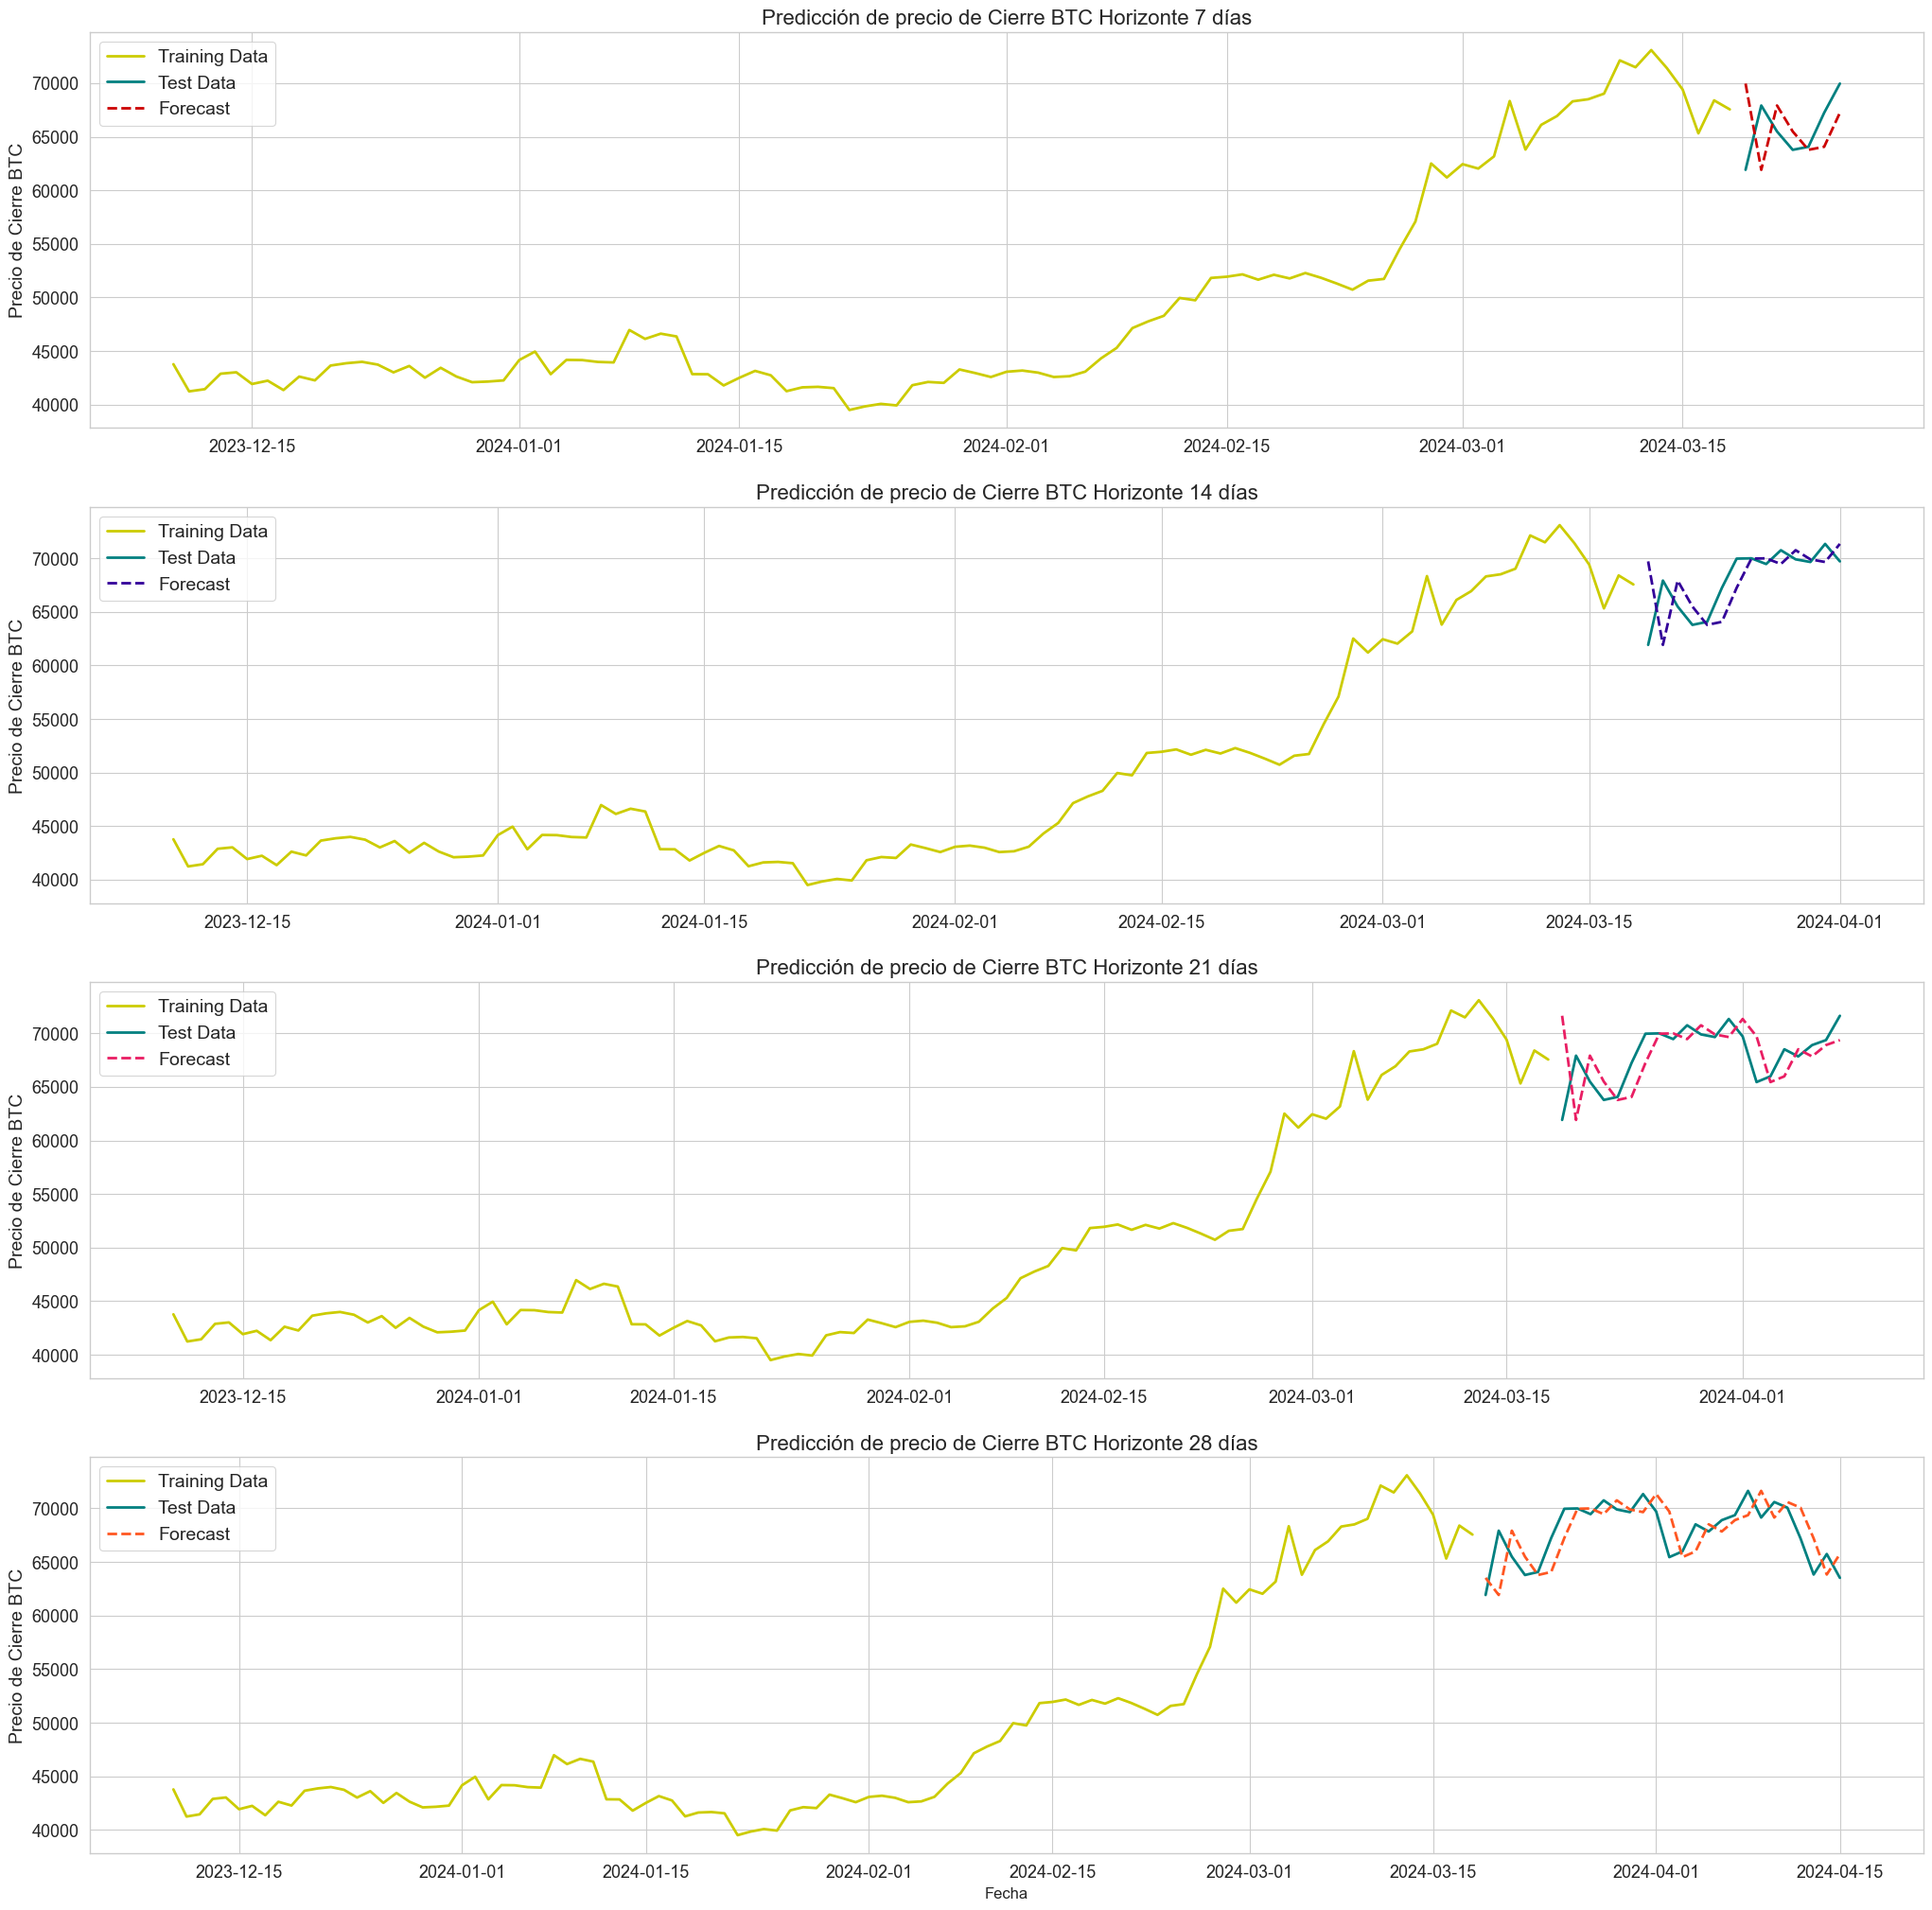

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25, 25)) # Crear la figura y el eje de la subtrama

#Gráfica horizonte 7 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], color='#CCCC00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_7, y=test_7, ax=axes[0], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=yhat_7_BIC  , ax=axes[0], label='Forecast', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[0].set_xlabel(None)
axes[0].legend(fontsize=14) # Mostrar la leyenda
axes[0].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[0].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 14 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], color='#CCCC00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_14, y=test_14, ax=axes[1], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=yhat_14_BIC  , ax=axes[1], label='Forecast', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[1].set_xlabel(None)
axes[1].legend(fontsize=14) # Mostrar la leyenda
axes[1].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[1].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 21 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[2], color='#CCCC00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_21, y=test_21, ax=axes[2], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=yhat_21_BIC  , ax=axes[2], label='Forecast', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[2].set_xlabel(None)
axes[2].legend(fontsize=14) # Mostrar la leyenda
axes[2].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[2].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 28 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[3], color='#CCCC00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_28, y=test_28, ax=axes[3], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=yhat_28_BIC  , ax=axes[3], label='Forecast', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[3].set_xlabel('Fecha', fontsize=12)
axes[3].legend(fontsize=14) # Mostrar la leyenda
axes[3].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[3].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

plt.show()

En el gráfico anterior se presentan las predicciones para horizontes de 7, 14, 21 y 28 días. La línea de color lima representa los datos utilizados para entrenar el modelo ARIMA. La línea azul muestra los datos reales u observaciones correspondientes a cada horizonte, mientras que la línea punteada indica las predicciones generadas por nuestro modelo ARIMA a partir de los datos de entrenamiento. Estas predicciones se comparan con los valores reales de prueba para evaluar la precisión del modelo.

También se aprecia un sesgo entre los datos reales de prueba y las predicciones proporcionadas por nuestro modelo ARIMA, basadas en los datos de entrenamiento.

A continuación se ajusta nuestro modelo `ARIMA` utilizando `forecast()` para los diferentes horizontes de predicción, **7, 14, 21 y 28 días**, y así poder visualizar las predicciones del precio de cierre de la criptomoneda **Bitcoin**. 

* **Horizonte de 7 días**

In [229]:
predic_forecast7BIC = model_fit_BIC.forecast(7) 
print(predic_forecast7BIC)

3471    67548.59375
3472    67548.59375
3473    67548.59375
3474    67548.59375
3475    67548.59375
3476    67548.59375
3477    67548.59375
Name: predicted_mean, dtype: float64


* **Horizonte de 14 días**

In [230]:
predic_forecast14BIC = model_fit_BIC.forecast(14) 
print(predic_forecast14BIC)

3471    67548.59375
3472    67548.59375
3473    67548.59375
3474    67548.59375
3475    67548.59375
3476    67548.59375
3477    67548.59375
3478    67548.59375
3479    67548.59375
3480    67548.59375
3481    67548.59375
3482    67548.59375
3483    67548.59375
3484    67548.59375
Name: predicted_mean, dtype: float64


* **Horizonte de 21 días**

In [231]:
predic_forecast21BIC = model_fit_BIC.forecast(21) 
print(predic_forecast21BIC)

3471    67548.59375
3472    67548.59375
3473    67548.59375
3474    67548.59375
3475    67548.59375
3476    67548.59375
3477    67548.59375
3478    67548.59375
3479    67548.59375
3480    67548.59375
3481    67548.59375
3482    67548.59375
3483    67548.59375
3484    67548.59375
3485    67548.59375
3486    67548.59375
3487    67548.59375
3488    67548.59375
3489    67548.59375
3490    67548.59375
3491    67548.59375
Name: predicted_mean, dtype: float64


* **Horizonte de 28 días**

In [232]:
predic_forecast28BIC = model_fit_BIC.forecast(28) 
print(predic_forecast28BIC)

3471    67548.59375
3472    67548.59375
3473    67548.59375
3474    67548.59375
3475    67548.59375
3476    67548.59375
3477    67548.59375
3478    67548.59375
3479    67548.59375
3480    67548.59375
3481    67548.59375
3482    67548.59375
3483    67548.59375
3484    67548.59375
3485    67548.59375
3486    67548.59375
3487    67548.59375
3488    67548.59375
3489    67548.59375
3490    67548.59375
3491    67548.59375
3492    67548.59375
3493    67548.59375
3494    67548.59375
3495    67548.59375
3496    67548.59375
3497    67548.59375
3498    67548.59375
Name: predicted_mean, dtype: float64


##### Gráfica lineplot  modelo ARIMA para predecir el precio de **Bitcoin** con un horizonte de 7, 14, 21 y 28 días

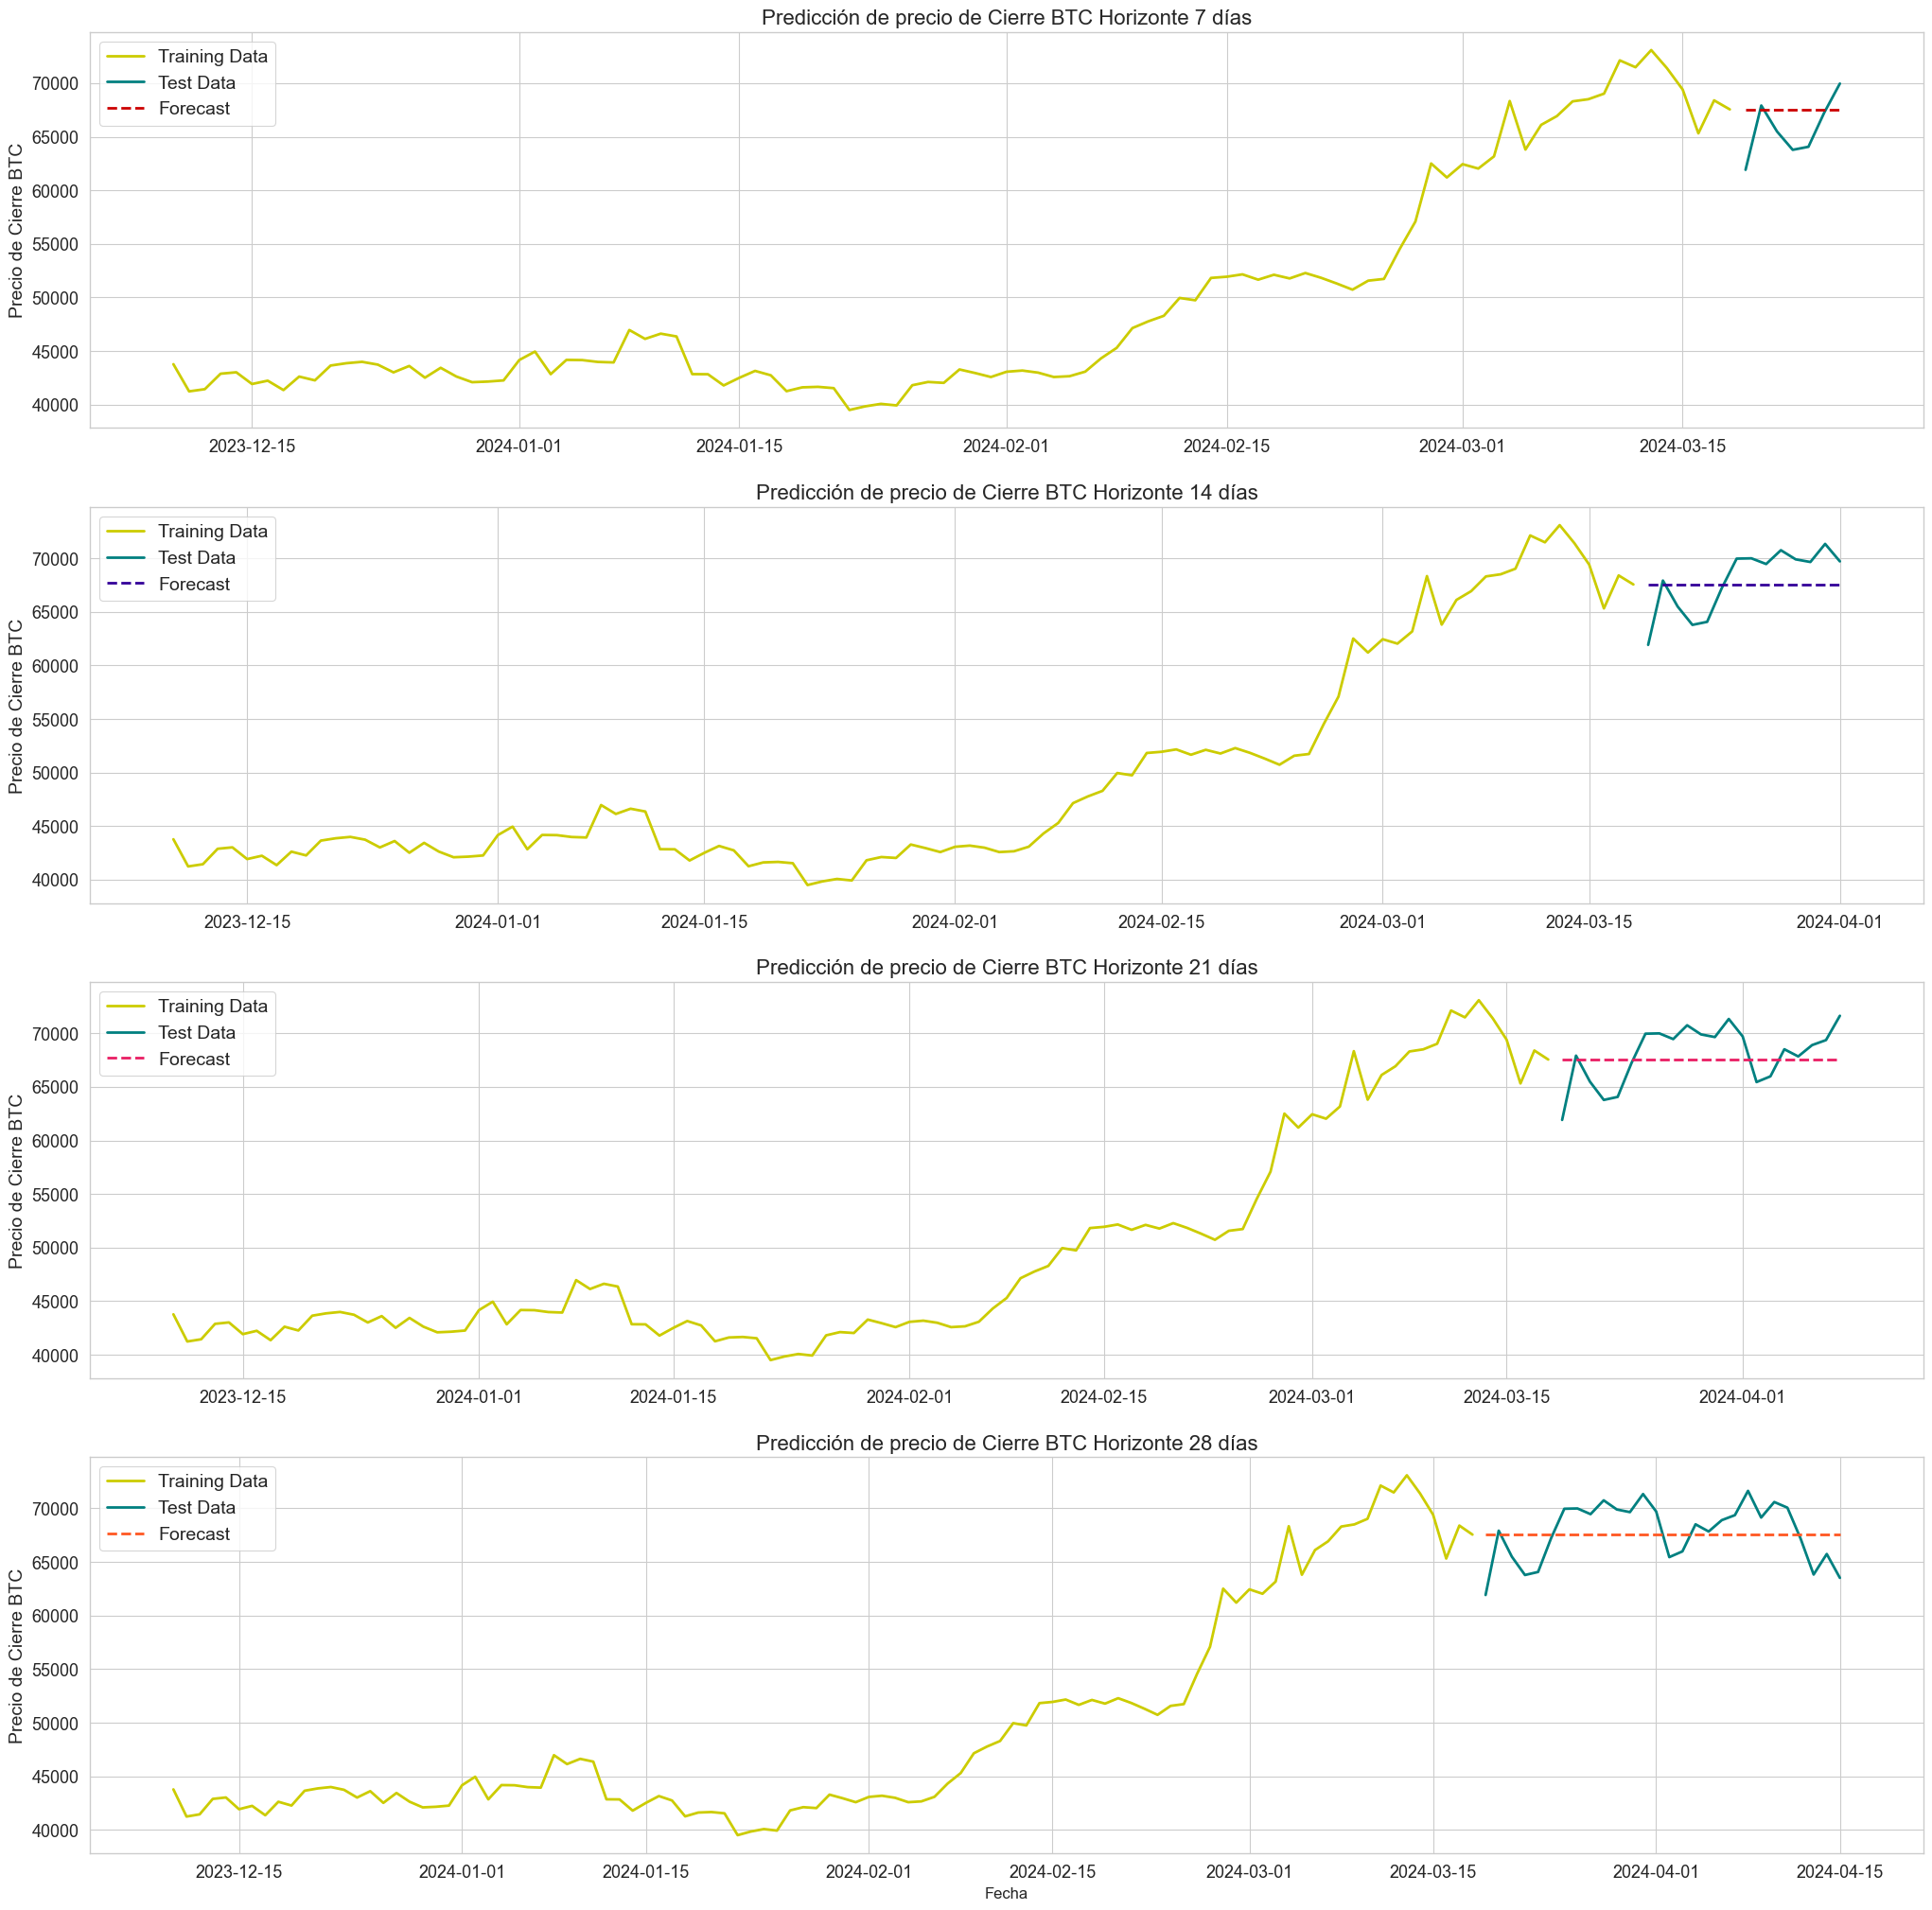

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25, 25)) # Crear la figura y el eje de la subtrama

#Gráfica horizonte 7 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], color='#CCCC00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_7, y=test_7, ax=axes[0], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=predic_forecast7BIC, ax=axes[0], label='Forecast', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[0].set_xlabel(None)
axes[0].legend(fontsize=14) # Mostrar la leyenda
axes[0].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[0].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 14 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], color='#CCCC00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_14, y=test_14, ax=axes[1], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=predic_forecast14BIC, ax=axes[1], label='Forecast', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[1].set_xlabel(None)
axes[1].legend(fontsize=14) # Mostrar la leyenda
axes[1].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[1].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 21 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[2], color='#CCCC00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_21, y=test_21, ax=axes[2], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=predic_forecast21BIC, ax=axes[2], label='Forecast', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[2].set_xlabel(None)
axes[2].legend(fontsize=14) # Mostrar la leyenda
axes[2].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[2].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 28 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[3], color='#CCCC00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_28, y=test_28, ax=axes[3], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=predic_forecast28BIC, ax=axes[3], label='Forecast', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[3].set_xlabel('Fecha', fontsize=12)
axes[3].legend(fontsize=14) # Mostrar la leyenda
axes[3].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[3].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

plt.show()

El gráfico previo representa la predicción del modelo ARIMA sin utilizar el método rolling, con un horizonte de pronóstico. El gráfico muestra la predicción para 7, 14, 21 y 28 días que le anteceden al último dato disponible en el conjunto de datos original. Además, se observan diferencias significativas entre las observaciones de prueba y las predicciones realizadas para cada uno de los horizontes. 

##### Tablas de error para los ejercicios 2 y 3, utilizando las métricas: MAPE, MAE, RMSE, MSE, R2.

* **Evaluación de las predicciones ejercicio 2 (usando rolling)**.

* **Horizonte de 7 días**

In [234]:
forecast_accuracy(np.array(yhat_7_BIC), np.array(test_7l), "7 días")

MAPE          MAE         RMSE           MSE        R2
7 días  0.053244  3480.271205  4261.379089  1.815935e+07 -1.756041

* **Horizonte de 14 días**

In [236]:
forecast_accuracy(np.array(yhat_14_BIC), np.array(test_14l), "14 días")

MAPE          MAE         RMSE           MSE        R2
14 días  0.032692  2169.703683  3062.424866  9.378446e+06 -0.142201

* **Horizonte de 21 días**

In [237]:
forecast_accuracy(np.array(yhat_21_BIC), np.array(test_21l), "21 días")

MAPE         MAE         RMSE           MSE        R2
21 días  0.031548  2099.38244  3061.225697  9.371103e+06 -0.388743

* **Horizonte de 28 días**

In [239]:
forecast_accuracy(np.array(yhat_28_BIC), np.array(test_28l), "28 días")

MAPE          MAE         RMSE           MSE        R2
28 días  0.026972  1814.974051  2249.733931  5.061303e+06  0.278378

Al observar estas métricas, podemos notar que para el horizonte de 7 días, todas las métricas de evaluación de modelos son bastante altas en comparación con los otros horizontes. Esto sugiere que el modelo tiene una buena capacidad predictiva a corto plazo, con errores relativamente bajos y una mayor variabilidad explicada (R2 negativo sugiere un rendimiento relativamente pobre).

A medida que aumenta el horizonte de tiempo (14, 21 y 28 días), el MAPE, MAE, RMSE y MSE disminuyen, lo que indica una mejora en la precisión del modelo. Sin embargo, el R2 también disminuye, lo que sugiere que el modelo explica una menor parte de la variabilidad en los datos a medida que se amplía el horizonte de tiempo.

En resumen, a medida que aumenta el horizonte de tiempo, el modelo muestra una mejora en la precisión de las predicciones (según MAPE, MAE, RMSE y MSE), pero su capacidad para explicar la variabilidad en los datos (según R2) disminuye. Esto sugiere que el modelo puede ser más adecuado para pronósticos a corto plazo, mientras que su rendimiento puede ser menos confiable a largo plazo.

*  **Evaluación de las predicciones ejercicio 3  (Sin utilizar rolling)**. 

* **Horizonte de 7 días**

In [240]:
forecast_accuracy(np.array(predic_forecast7BIC), np.array(test_7l), "7 días")

MAPE          MAE         RMSE           MSE   R2
7 días  0.040068  2576.994978  3125.983411  9.771772e+06  0.0

* **Horizonte de 14 días**

In [241]:
forecast_accuracy(np.array(predic_forecast14BIC), np.array(test_14l), "14 días")

MAPE         MAE         RMSE           MSE   R2
14 días  0.038255  2568.63365  2891.623192  8.361485e+06  0.0

* **Horizonte de 21 días**

In [243]:
forecast_accuracy(np.array(predic_forecast21BIC), np.array(test_21l), "21 días")

MAPE          MAE         RMSE           MSE   R2
21 días  0.033925  2291.610119  2643.197836  6.986495e+06  0.0

* **Horizonte de 28 días**

In [244]:
forecast_accuracy(np.array(predic_forecast28BIC), np.array(test_28l), "28 días")

MAPE         MAE         RMSE           MSE   R2
28 días  0.03461  2328.28697  2661.769033  7.085014e+06  0.0

 Las métricas de evaluación de modelos (MAPE, MAE, RMSE y MSE) muestran una precisión razonable en las predicciones para todos los horizontes de tiempo, el valor de R2 sugiere que el modelo no está explicando ninguna variabilidad en los datos. Esto indica la necesidad de revisar el modelo o considerar otras variables o métodos para mejorar la capacidad predictiva.

En conclusión, estos resultados sugieren que los modelos actuales no son adecuados para explicar la variabilidad en los datos para ninguno de los horizontes de tiempo considerados.

A continuación se presenta análisis de `correlación` entre variables (`observación real` y su `predicción en el test`,  $ Corr(y_t, \tilde{y}_t) $.) para evaluar `la relación lineal` entre éstas a través de mapa de calor..


##### Gráfico de correlación entre la observación real y su predicción en el test,  $ Corr(y_t, \tilde{y}_t) $.

*  Gráfico de Correlación  ejercicio 2 (usando rolling). . 

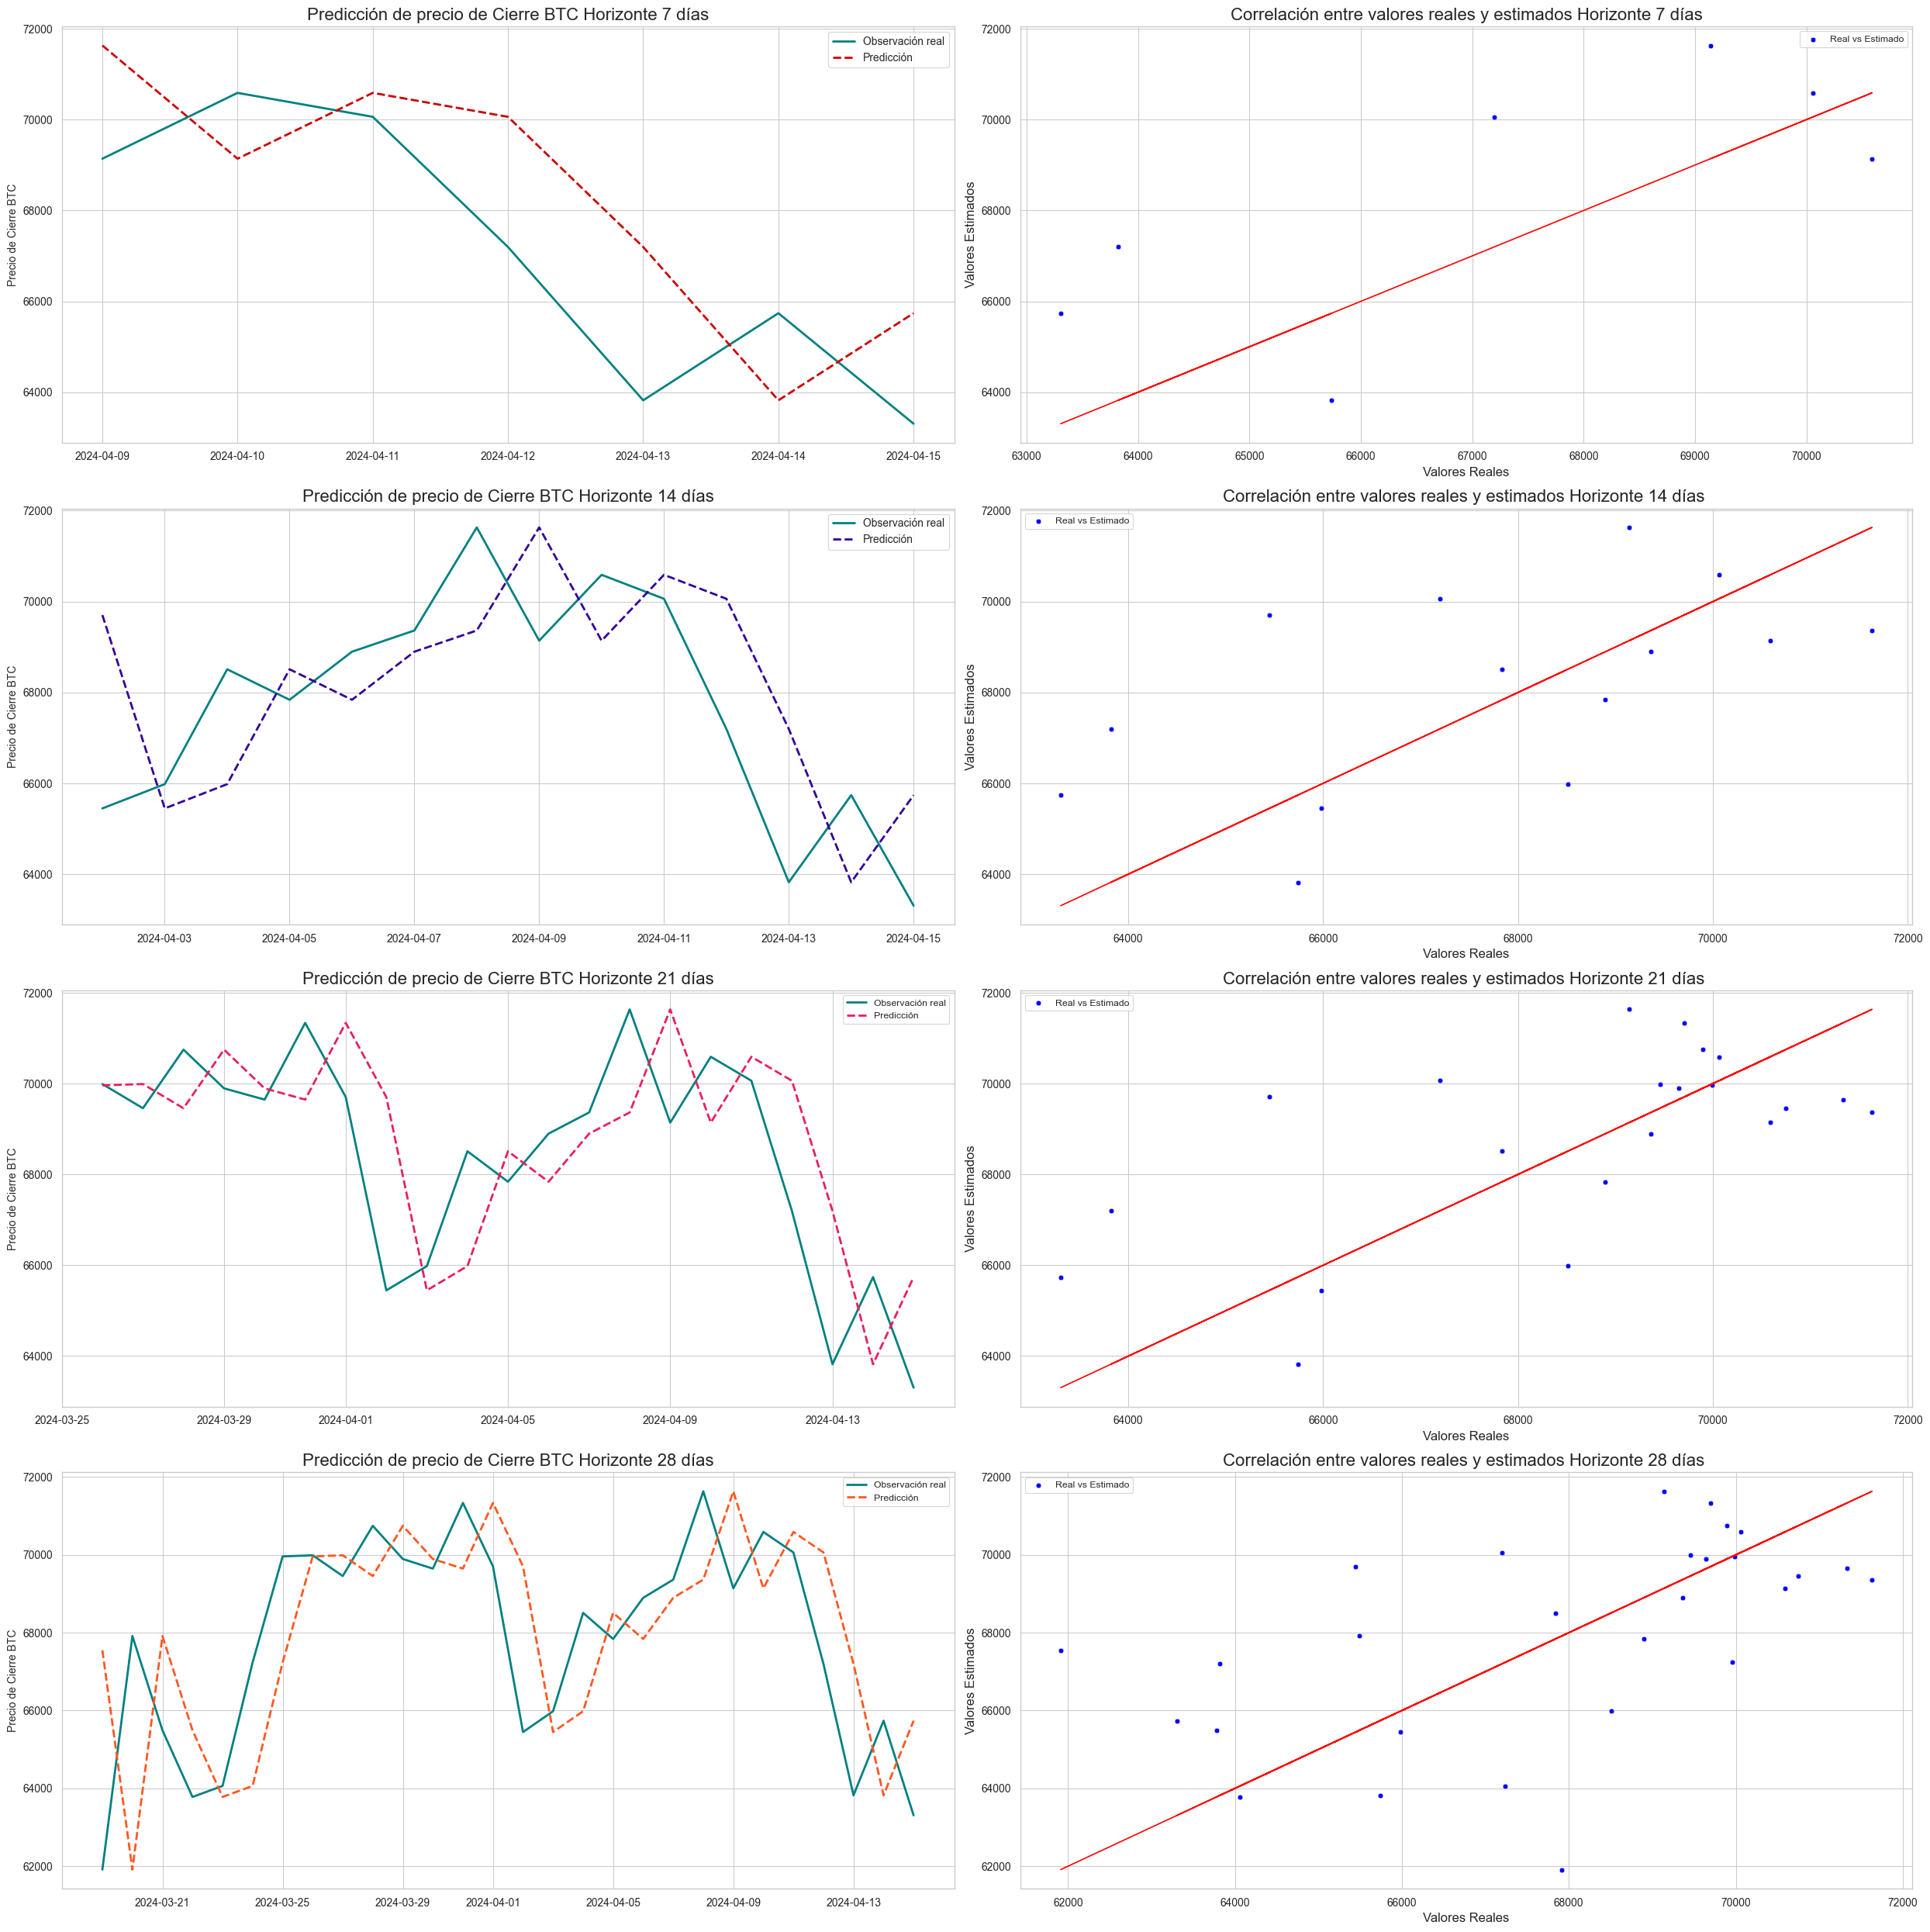

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))  # Crear la figura y el eje de la subtrama

# Gráfica horizonte 7 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_7, y=test_7, ax=axes[0,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=yhat_7_BIC, ax=axes[0,0], label='Predicción', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0,0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[0,0].set_xlabel(None)
axes[0,0].legend(fontsize=10) # Mostrar la leyenda
axes[0,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[0,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_7l, y=yhat_7_BIC, ax=axes[0,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[0,1].plot(test_7l, test_7l, color='red', label='Correlación')
axes[0,1].set_title('Correlación entre valores reales y estimados Horizonte 7 días', fontsize=16)
axes[0,1].set_xlabel('Valores Reales', fontsize=12)
axes[0,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[0,1].legend(fontsize=10)  # Mostrar la leyenda
axes[0,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[0,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)

# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_14, y=test_14, ax=axes[1,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=yhat_14_BIC, ax=axes[1,0], label='Predicción', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1,0].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[1,0].set_xlabel(None)
axes[1,0].legend(fontsize=10) # Mostrar la leyenda
axes[1,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[1,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_14l, y=yhat_14_BIC, ax=axes[1,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[1,1].plot(test_14l, test_14l, color='red', label='Correlación')
axes[1,1].set_title('Correlación entre valores reales y estimados Horizonte 14 días ', fontsize=16)
axes[1,1].set_xlabel('Valores Reales', fontsize=12)
axes[1,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[1,1].legend(fontsize=10)  # Mostrar la leyenda
axes[1,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[1,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_21, y=test_21, ax=axes[2,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=yhat_21_BIC, ax=axes[2,0], label='Predicción', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2,0].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[2,0].set_xlabel(None)
#axes[2,0].legend(fontsize=10) # Mostrar la leyenda
axes[2,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[2,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_21l, y=yhat_21_BIC, ax=axes[2,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[2,1].plot(test_21l, test_21l, color='red', label='Correlación')
axes[2,1].set_title('Correlación entre valores reales y estimados Horizonte 21 días ', fontsize=16)
axes[2,1].set_xlabel('Valores Reales', fontsize=12)
axes[2,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[2,1].legend(fontsize=10)  # Mostrar la leyenda
axes[2,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[2,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_28, y=test_28, ax=axes[3,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=yhat_28_BIC, ax=axes[3,0], label='Predicción', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3,0].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[3,0].set_xlabel(None)
#axes[3,0].legend(fontsize=10) # Mostrar la leyenda
axes[3,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[3,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_28l, y=yhat_28_BIC, ax=axes[3,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[3,1].plot(test_28l, test_28l, color='red', label='Correlación')
axes[3,1].set_title('Correlación entre valores reales y estimados Horizonte 28 días ', fontsize=16)
axes[3,1].set_xlabel('Valores Reales', fontsize=12)
axes[3,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[3,1].legend(fontsize=10)  # Mostrar la leyenda
axes[3,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[3,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)



plt.tight_layout()  # Ajustar el espaciado entre subgráficos
plt.show()

El gráfico muestra predicciones para diferentes horizontes temporales (7, 14, 21 y 28 días) junto con observaciones reales de prueba. También se incluye un gráfico que correlaciona las predicciones con estas observaciones reales.
En relación al primer gráfico del precio de cierre del Bitcoin, se aprecia que ambas líneas siguen tendencias similares y están próximas entre sí, lo que indica errores bajos. Sin embargo, se observa un sesgo en el tiempo que podría corregirse mediante mejoras en el modelo o la exploración de otras opciones que expliquen con mayor precisión la variabilidad en el tiempo. 
Los gráficos de autocorrelación revelan la ausencia de una correlación significativa entre los valores de la serie temporal y sus antecesores en los intervalos de 7, 14, 21 y 28 días. En resumen, no se observa un patrón claro o repetitivo en los datos a lo largo de estos horizontes.

* Gráfico de Correlación ejercicio 3  (Sin utilizar rolling). 

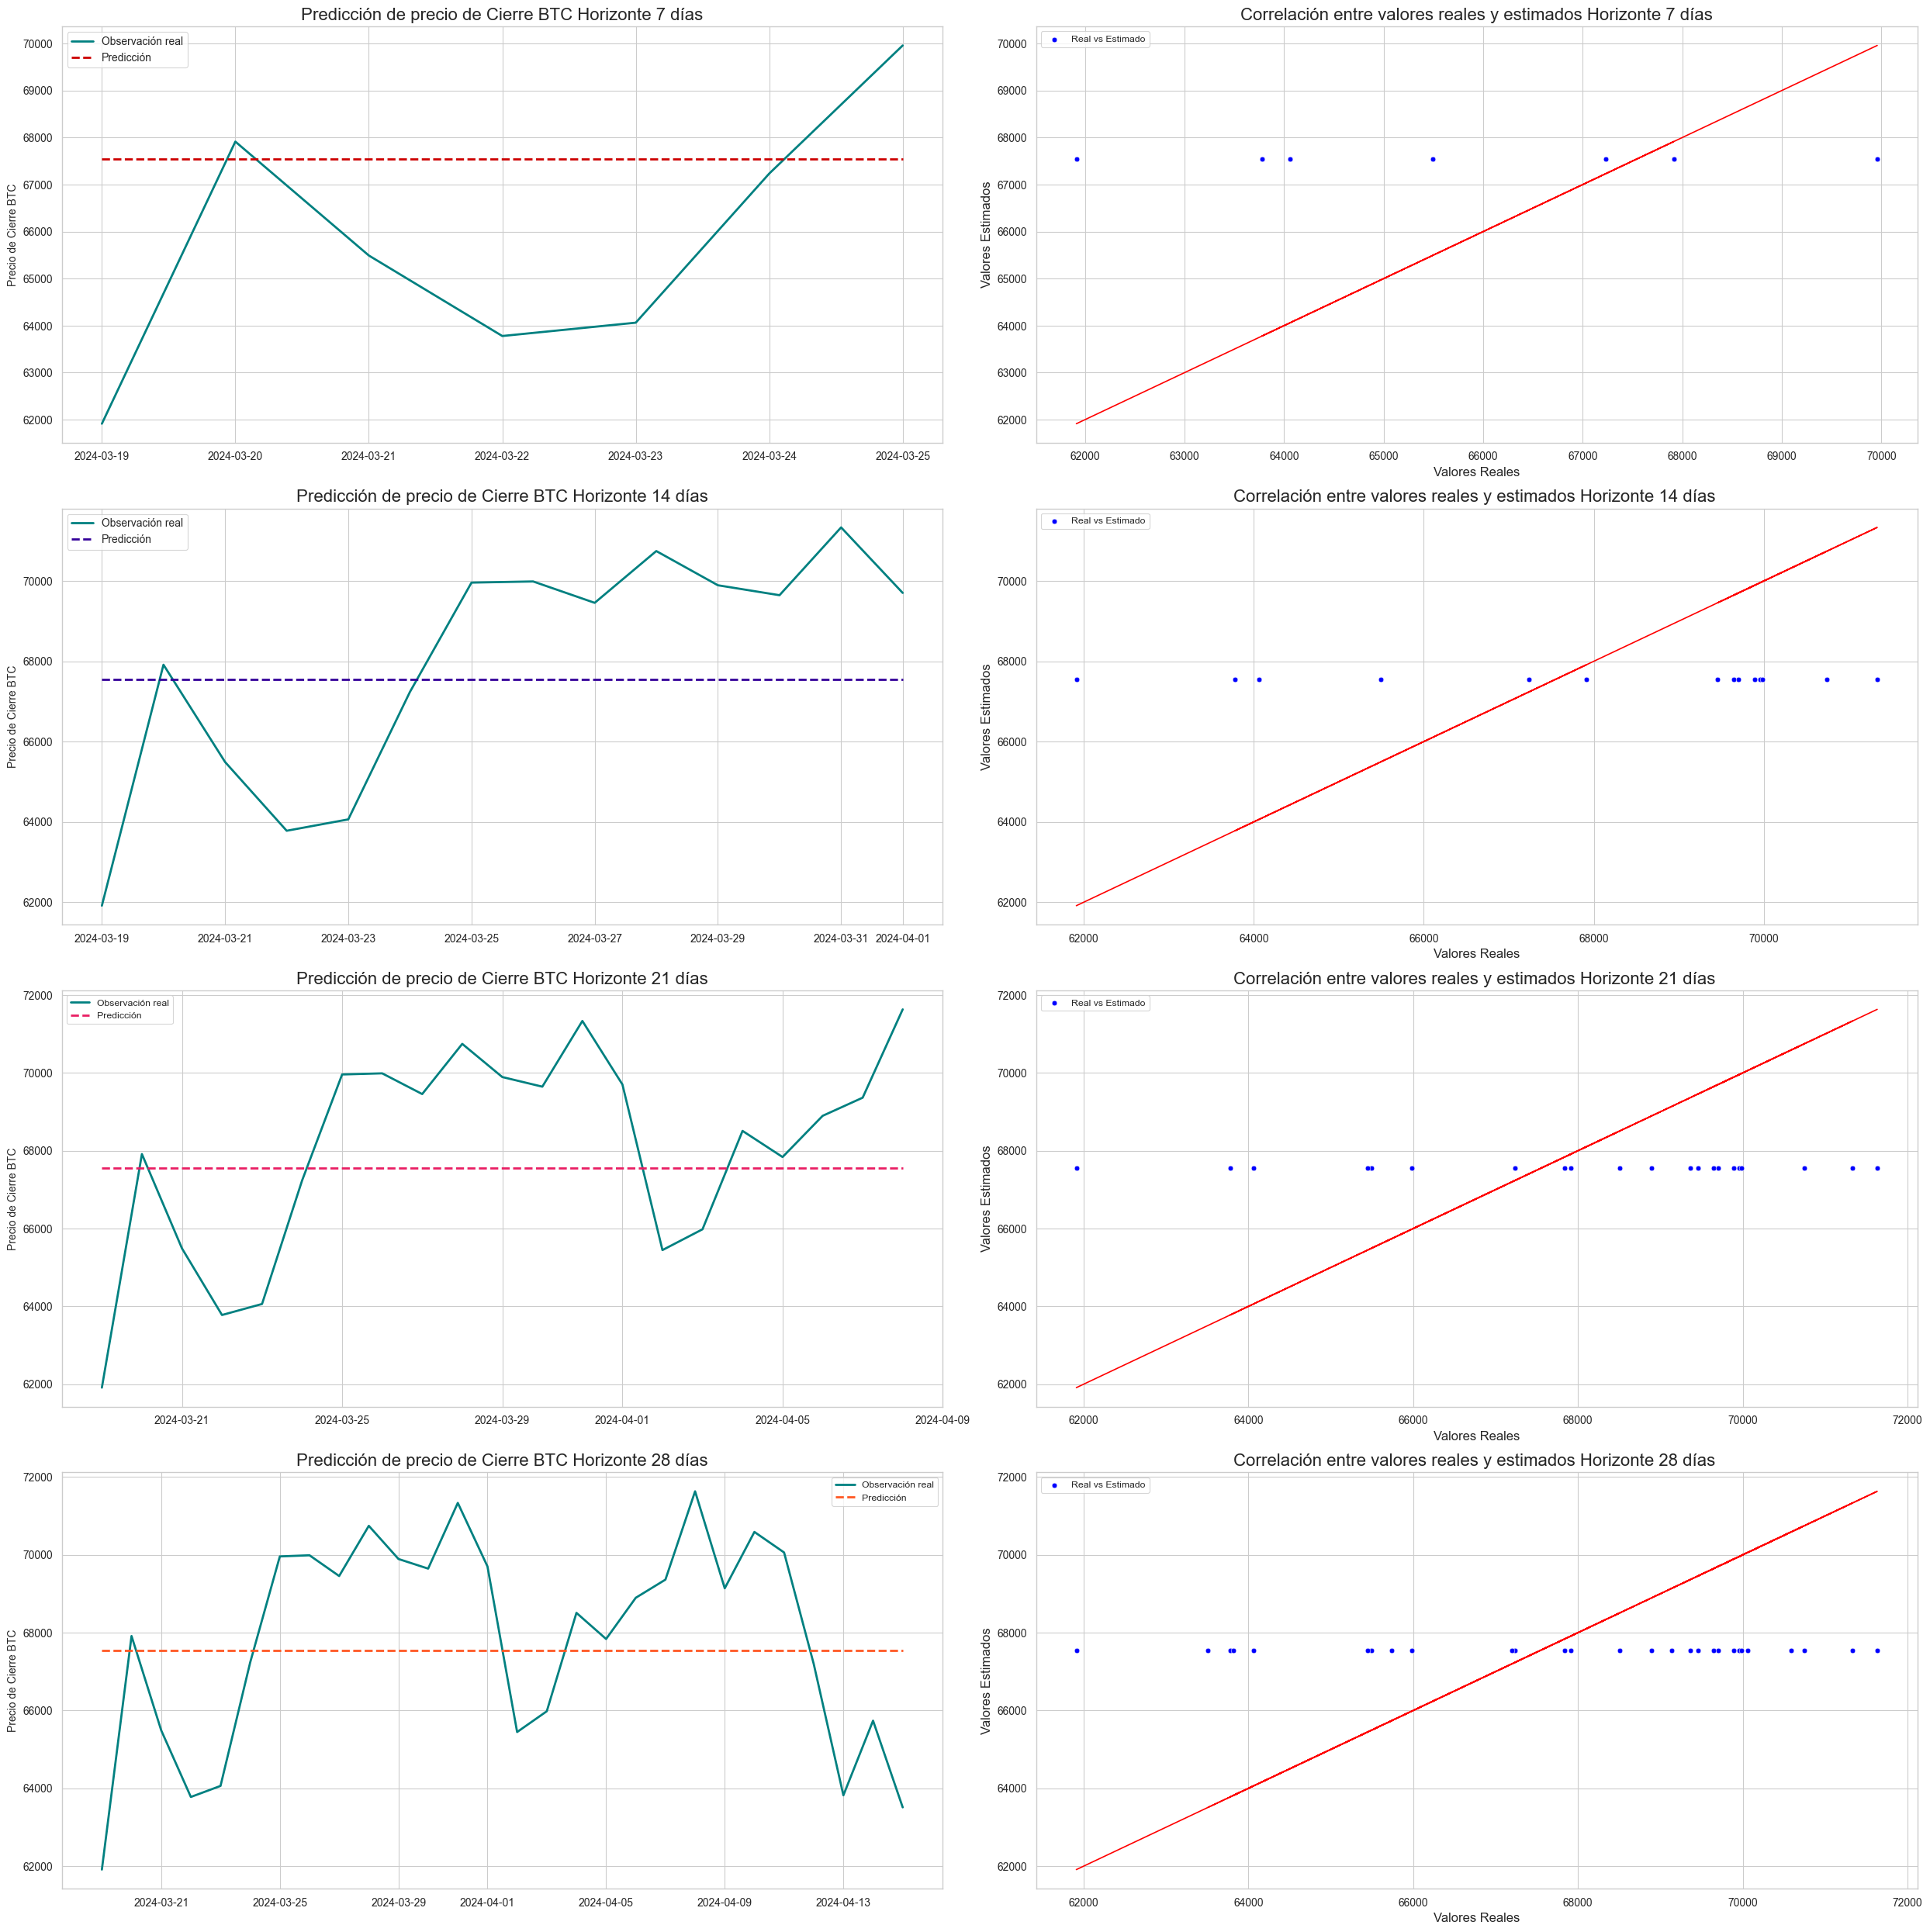

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))  # Crear la figura y el eje de la subtrama

# Gráfica horizonte 7 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_7, y=test_7, ax=axes[0,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=predic_forecast7BIC, ax=axes[0,0], label='Predicción', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0,0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[0,0].set_xlabel(None)
axes[0,0].legend(fontsize=10) # Mostrar la leyenda
axes[0,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[0,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_7l, y=predic_forecast7BIC, ax=axes[0,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[0,1].plot(test_7l, test_7l, color='red', label='Correlación')
axes[0,1].set_title('Correlación entre valores reales y estimados Horizonte 7 días', fontsize=16)
axes[0,1].set_xlabel('Valores Reales', fontsize=12)
axes[0,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[0,1].legend(fontsize=10)  # Mostrar la leyenda
axes[0,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[0,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)

# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_14, y=test_14, ax=axes[1,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=predic_forecast14BIC, ax=axes[1,0], label='Predicción', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1,0].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[1,0].set_xlabel(None)
axes[1,0].legend(fontsize=10) # Mostrar la leyenda
axes[1,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[1,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_14l, y=predic_forecast14BIC, ax=axes[1,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[1,1].plot(test_14l, test_14l, color='red', label='Correlación')
axes[1,1].set_title('Correlación entre valores reales y estimados Horizonte 14 días ', fontsize=16)
axes[1,1].set_xlabel('Valores Reales', fontsize=12)
axes[1,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[1,1].legend(fontsize=10)  # Mostrar la leyenda
axes[1,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[1,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_21, y=test_21, ax=axes[2,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=predic_forecast21BIC, ax=axes[2,0], label='Predicción', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2,0].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[2,0].set_xlabel(None)
#axes[2,0].legend(fontsize=10) # Mostrar la leyenda
axes[2,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[2,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_21l, y=predic_forecast21BIC, ax=axes[2,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[2,1].plot(test_21l, test_21l, color='red', label='Correlación')
axes[2,1].set_title('Correlación entre valores reales y estimados Horizonte 21 días ', fontsize=16)
axes[2,1].set_xlabel('Valores Reales', fontsize=12)
axes[2,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[2,1].legend(fontsize=10)  # Mostrar la leyenda
axes[2,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[2,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_28, y=test_28, ax=axes[3,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=predic_forecast28BIC, ax=axes[3,0], label='Predicción', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3,0].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[3,0].set_xlabel(None)
#axes[3,0].legend(fontsize=10) # Mostrar la leyenda
axes[3,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[3,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_28l, y=predic_forecast28BIC, ax=axes[3,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[3,1].plot(test_28l, test_28l, color='red', label='Correlación')
axes[3,1].set_title('Correlación entre valores reales y estimados Horizonte 28 días ', fontsize=16)
axes[3,1].set_xlabel('Valores Reales', fontsize=12)
axes[3,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[3,1].legend(fontsize=10)  # Mostrar la leyenda
axes[3,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[3,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)



plt.tight_layout()  # Ajustar el espaciado entre subgráficos
plt.show()

En el primer gráfico del precio de cierre del Bitcoin, se nota una discrepancia notable entre las observaciones reales de prueba y las predicciones, lo que sugiere la presencia de errores considerables. Por otro lado, los gráficos de autocorrelación no muestran una correlación significativa entre los valores de la serie temporal y sus antecedentes en los intervalos de 7, 14, 21 y 28 días. En resumen, no se identifica un patrón claro o repetitivo en los datos a lo largo de estos horizontes.

En términos de predicción del precio del Bitcoin, se puede concluir que el modelo ARIMA utilizando la técnica de rolling ofrece un rendimiento superior en comparación con el otro modelo considerado (ARIMA sin utilizar rolling). 

#### Criterio de información de Hannan-Quinn (HQIC)

##### Construcción de modelo ARIMA considerando el criterio de información de Hannan-Quinn (HQIC) para predecir el precio de Bitcoin con los siguientes horizontes: 7, 14, 21 y 28. 

In [247]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore") # suprimir advertencias durante el ajuste del modelo.


def arima_model_fit_HQIC(data_df):
    # Realiza predicciones continuas usando un enfoque de desplazamiento
    # y almacena las predicciones en una lista
    data = data_df.copy()

    n_BTC = len(data.Close)
    train_size = n_BTC - 28  # Tamaño del conjunto de entrenamiento - 28 días

    train = data.Close[:train_size]  # Datos de entrenamiento (precios de cierre)
    dates_train = data.Date[:train_size]  # Fechas correspondientes a los datos de entrenamiento

#A través de la siguiente función que depende sólo del input `train` y retornarán los parámetros `p`, `d`, `q` y que definiendo el mejor modelo ARIMA con el menor criterio `BIC` como medida de bondad de ajuste.
#**Nota:** Consideramos el `método: mle`para el cálculo. 

    best_hqic = np.inf
    
    best_order = None
    best_mdl = None

    pq_rng = range(4)
    d_rng  = range(2)

    for p in pq_rng:
        for d in d_rng:
            for q in pq_rng:
                try:
                    # print(i, d, j)
                    tmp_mdl = ARIMA(train, order=(p,d,q)).fit()
                    tmp_hqic  = tmp_mdl.hqic 
                    if tmp_hqic  < best_hqic :
                        best_hqic  = tmp_hqic 
                        best_order = (p,d,q)
                        best_mdl = tmp_mdl
                except: continue

    print('Best BIC:', best_hqic)
    print('Best Order:', best_order)

    print('bic: {:6.5f} | order: {}'.format(best_hqic, best_order))

    model = ARIMA(train, order=best_order)
    model_fit = model.fit()   

    return model_fit, train, dates_train, best_order

*  **Indexación de parámetros para la función arima_model_fit_HQIC()**

La siguiente función devuelve los parámetros `p`, `d`, `q` que definen `el mejor modelo ARIMA` con `el menor criterio HQIC (Criterio de información de Hanna-Quinn)` como medida de bondad de ajuste. Además, proporciona los resultados del modelo `ARIMA ajustado` para `datos de entrenamiento`, incluyendo las `fechas` correspondientes. También incluye los datos y fechas del modelo `ARIMA de prueba`, aunque estos últimos dos no son directamente visibles en la salida de la función.

In [248]:
model_fit_HQIC, train, dates_train,best_order_HQIC = arima_model_fit_HQIC(BTC_df_sorted)

Best BIC: 56341.10486655025
Best Order: (0, 1, 0)
bic: 56341.10487 | order: (0, 1, 0)


* **Indexación de parámetros para la función arima_rolling()**

* **Horizonte de 7 días**

In [250]:
yhat_7_HQIC = arima_rolling(train_7l, test_7l, best_order_HQIC)

predicted=69958.812500, expected=61912.773438
predicted=61912.773438, expected=67913.671875
predicted=67913.671875, expected=65491.390625
predicted=65491.390625, expected=63778.761719
predicted=63778.761719, expected=64062.203125
predicted=64062.203125, expected=67234.171875
predicted=67234.171875, expected=69958.812500


* **Horizonte de 14 días**

In [249]:
yhat_14_HQIC = arima_rolling(train_14l, test_14l, best_order_HQIC)

predicted=69702.148438, expected=61912.773438
predicted=61912.773438, expected=67913.671875
predicted=67913.671875, expected=65491.390625
predicted=65491.390625, expected=63778.761719
predicted=63778.761719, expected=64062.203125
predicted=64062.203125, expected=67234.171875
predicted=67234.171875, expected=69958.812500
predicted=69958.812500, expected=69987.835938
predicted=69987.835938, expected=69455.343750
predicted=69455.343750, expected=70744.953125
predicted=70744.953125, expected=69892.828125
predicted=69892.828125, expected=69645.304688
predicted=69645.304688, expected=71333.648438
predicted=71333.648438, expected=69702.148438


* **Horizonte de 21 días**

In [251]:
yhat_21_HQIC  = arima_rolling(train_21l, test_21l, best_order_HQIC)

predicted=71631.359375, expected=61912.773438
predicted=61912.773438, expected=67913.671875
predicted=67913.671875, expected=65491.390625
predicted=65491.390625, expected=63778.761719
predicted=63778.761719, expected=64062.203125
predicted=64062.203125, expected=67234.171875
predicted=67234.171875, expected=69958.812500
predicted=69958.812500, expected=69987.835938
predicted=69987.835938, expected=69455.343750
predicted=69455.343750, expected=70744.953125
predicted=70744.953125, expected=69892.828125
predicted=69892.828125, expected=69645.304688
predicted=69645.304688, expected=71333.648438
predicted=71333.648438, expected=69702.148438
predicted=69702.148438, expected=65446.972656
predicted=65446.972656, expected=65980.812500
predicted=65980.812500, expected=68508.843750
predicted=68508.843750, expected=67837.640625
predicted=67837.640625, expected=68896.109375
predicted=68896.109375, expected=69362.554688
predicted=69362.554688, expected=71631.359375


* **Horizonte de 28 días**

In [252]:
yhat_28_HQIC  = arima_rolling(train_28l, test_28l, best_order_HQIC)

predicted=63511.812500, expected=61912.773438
predicted=61912.773438, expected=67913.671875
predicted=67913.671875, expected=65491.390625
predicted=65491.390625, expected=63778.761719
predicted=63778.761719, expected=64062.203125
predicted=64062.203125, expected=67234.171875
predicted=67234.171875, expected=69958.812500
predicted=69958.812500, expected=69987.835938
predicted=69987.835938, expected=69455.343750
predicted=69455.343750, expected=70744.953125
predicted=70744.953125, expected=69892.828125
predicted=69892.828125, expected=69645.304688
predicted=69645.304688, expected=71333.648438
predicted=71333.648438, expected=69702.148438
predicted=69702.148438, expected=65446.972656
predicted=65446.972656, expected=65980.812500
predicted=65980.812500, expected=68508.843750
predicted=68508.843750, expected=67837.640625
predicted=67837.640625, expected=68896.109375
predicted=68896.109375, expected=69362.554688
predicted=69362.554688, expected=71631.359375
predicted=71631.359375, expected=6

##### Gráfica lineplot  modelo ARIMA para predecir el precio de **Bitcoin** con un horizonte de 7, 14, 21 y 28 días usando el criterio BIC.

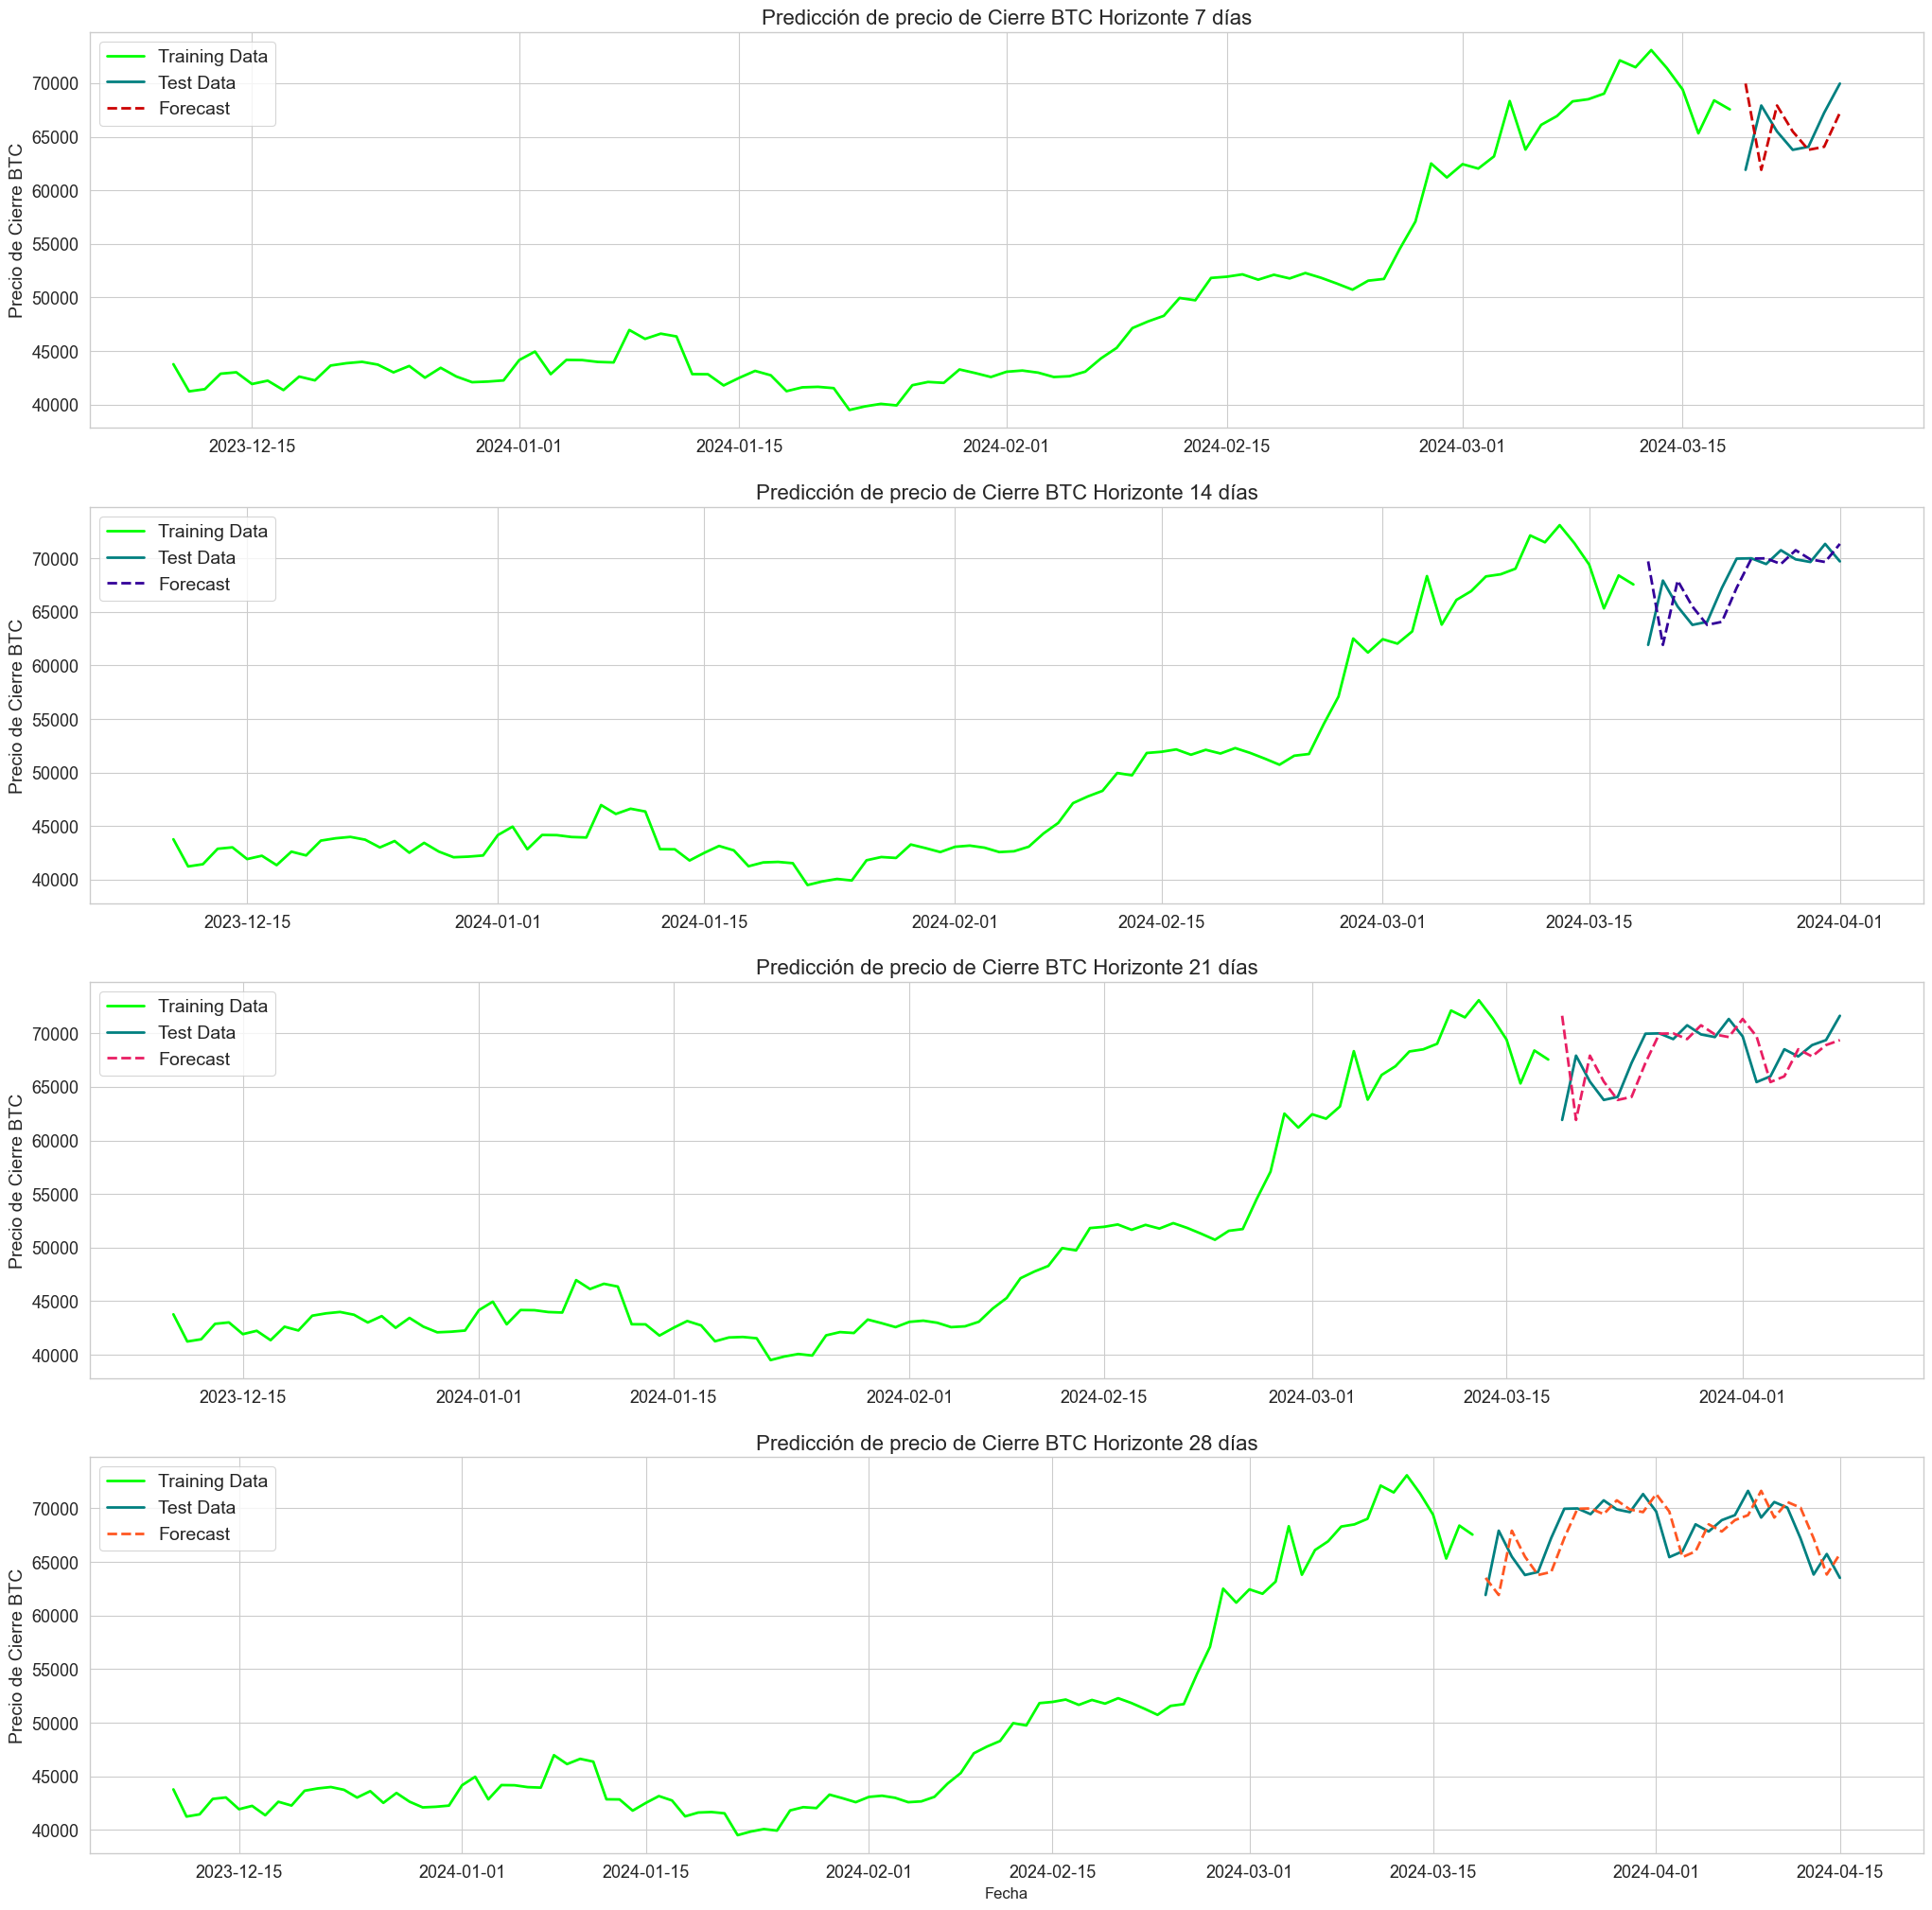

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25, 25)) # Crear la figura y el eje de la subtrama

#Gráfica horizonte 7 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], color='#00FF00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_7, y=test_7, ax=axes[0], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=yhat_7_HQIC  , ax=axes[0], label='Forecast', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[0].set_xlabel(None)
axes[0].legend(fontsize=14) # Mostrar la leyenda
axes[0].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[0].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 14 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], color='#00FF00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_14, y=test_14, ax=axes[1], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=yhat_14_HQIC  , ax=axes[1], label='Forecast', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[1].set_xlabel(None)
axes[1].legend(fontsize=14) # Mostrar la leyenda
axes[1].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[1].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 21 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[2], color='#00FF00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_21, y=test_21, ax=axes[2], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=yhat_21_HQIC  , ax=axes[2], label='Forecast', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[2].set_xlabel(None)
axes[2].legend(fontsize=14) # Mostrar la leyenda
axes[2].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[2].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 28 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[3], color='#00FF00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_28, y=test_28, ax=axes[3], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=yhat_28_HQIC  , ax=axes[3], label='Forecast', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[3].set_xlabel('Fecha', fontsize=12)
axes[3].legend(fontsize=14) # Mostrar la leyenda
axes[3].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[3].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

plt.show()

A continuación se ajusta nuestro modelo `ARIMA` al conjunto de entrenamiento utilizando `forecast()` para los diferentes horizontes de predicción, **7, 14, 21 y 28 días**, para la visualización de las predicciones del precio de cierre de la criptomoneda **Bitcoin**. 

* **Horizonte de 7 días**

In [254]:
predic_forecast7HQIC = model_fit_HQIC.forecast(7) 
print(predic_forecast7HQIC)

3471    67548.59375
3472    67548.59375
3473    67548.59375
3474    67548.59375
3475    67548.59375
3476    67548.59375
3477    67548.59375
Name: predicted_mean, dtype: float64


* **Horizonte de 14 días**

In [255]:
predic_forecast14HQIC = model_fit_HQIC.forecast(14) 
print(predic_forecast14HQIC)

3471    67548.59375
3472    67548.59375
3473    67548.59375
3474    67548.59375
3475    67548.59375
3476    67548.59375
3477    67548.59375
3478    67548.59375
3479    67548.59375
3480    67548.59375
3481    67548.59375
3482    67548.59375
3483    67548.59375
3484    67548.59375
Name: predicted_mean, dtype: float64


* **Horizonte de 21 días**

In [258]:
predic_forecast21HQIC = model_fit_HQIC.forecast(21) 
print(predic_forecast21HQIC)

3471    67548.59375
3472    67548.59375
3473    67548.59375
3474    67548.59375
3475    67548.59375
3476    67548.59375
3477    67548.59375
3478    67548.59375
3479    67548.59375
3480    67548.59375
3481    67548.59375
3482    67548.59375
3483    67548.59375
3484    67548.59375
3485    67548.59375
3486    67548.59375
3487    67548.59375
3488    67548.59375
3489    67548.59375
3490    67548.59375
3491    67548.59375
Name: predicted_mean, dtype: float64


* **Horizonte de 28 días**

In [259]:
predic_forecast28HQIC = model_fit_HQIC.forecast(28) 
print(predic_forecast28HQIC)

3471    67548.59375
3472    67548.59375
3473    67548.59375
3474    67548.59375
3475    67548.59375
3476    67548.59375
3477    67548.59375
3478    67548.59375
3479    67548.59375
3480    67548.59375
3481    67548.59375
3482    67548.59375
3483    67548.59375
3484    67548.59375
3485    67548.59375
3486    67548.59375
3487    67548.59375
3488    67548.59375
3489    67548.59375
3490    67548.59375
3491    67548.59375
3492    67548.59375
3493    67548.59375
3494    67548.59375
3495    67548.59375
3496    67548.59375
3497    67548.59375
3498    67548.59375
Name: predicted_mean, dtype: float64


##### Gráfica lineplot  modelo ARIMA para predecir el precio de **Bitcoin** con un horizonte de 7, 14, 21 y 28 días

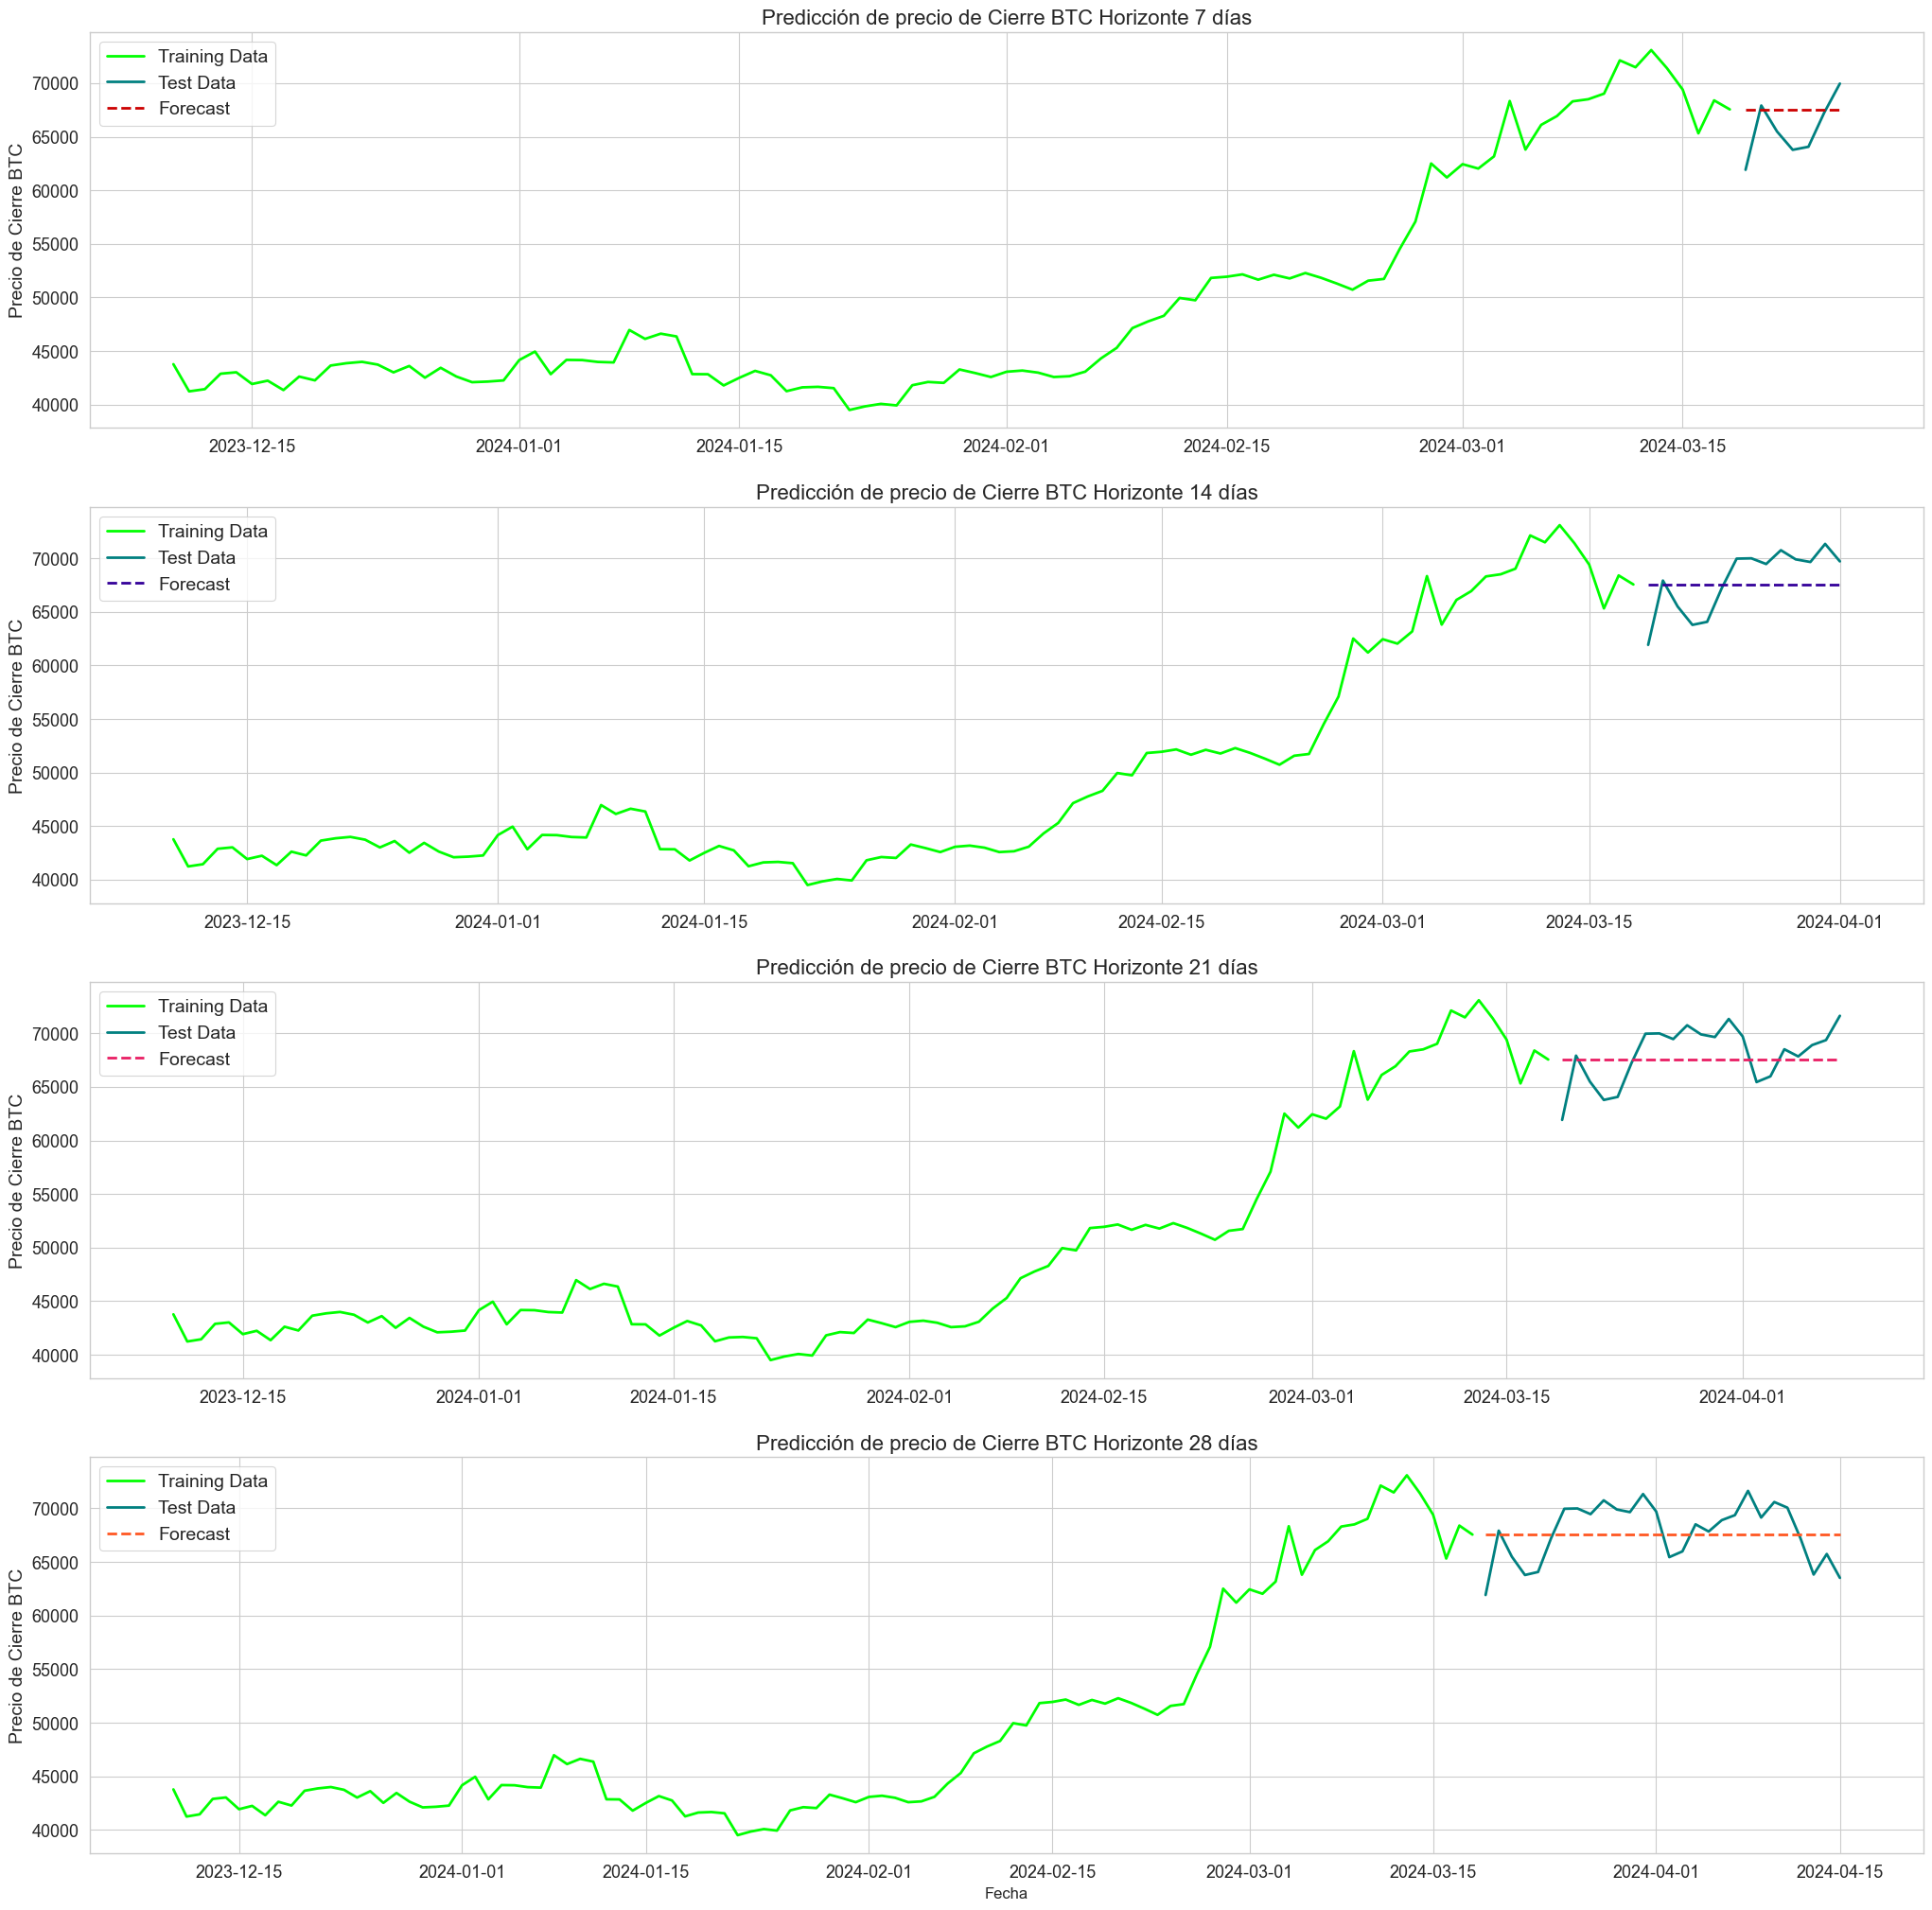

In [261]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25, 25)) # Crear la figura y el eje de la subtrama

#Gráfica horizonte 7 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], color='#00FF00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_7, y=test_7, ax=axes[0], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=predic_forecast7HQIC, ax=axes[0], label='Forecast', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[0].set_xlabel(None)
axes[0].legend(fontsize=14) # Mostrar la leyenda
axes[0].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[0].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 14 días. 

sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], color='#00FF00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_14, y=test_14, ax=axes[1], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=predic_forecast14HQIC, ax=axes[1], label='Forecast', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[1].set_xlabel(None)
axes[1].legend(fontsize=14) # Mostrar la leyenda
axes[1].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[1].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 21 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[2], color='#00FF00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_21, y=test_21, ax=axes[2], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=predic_forecast21HQIC, ax=axes[2], label='Forecast', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[2].set_xlabel(None)
axes[2].legend(fontsize=14) # Mostrar la leyenda
axes[2].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[2].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

#Gráfica horizonte 28 días. 
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[3], color='#00FF00', label='Training Data', linewidth=2) # Trama de línea para los datos de entrenamiento (últimos 100 días)
sns.lineplot(x=dates_28, y=test_28, ax=axes[3], label='Test Data', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=predic_forecast28HQIC, ax=axes[3], label='Forecast', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3].set_ylabel('Precio de Cierre BTC', fontsize=14)
axes[3].set_xlabel('Fecha', fontsize=12)
axes[3].legend(fontsize=14) # Mostrar la leyenda
axes[3].tick_params(axis='x', labelsize=13)  # Solo para el eje x (inferior)
axes[3].tick_params(axis='y', labelsize=13)  # Solo para el eje y (izquierdo)

plt.show()

El gráfico previo representa la predicción del modelo ARIMA sin utilizar el método rolling, con un horizonte de pronóstico. El gráfico muestra la predicción para 7, 14, 21 y 28 días que le anteceden al último dato disponible en el conjunto de datos original. Además, se observan diferencias significativas entre las observaciones de prueba y las predicciones realizadas para cada uno de los horizontes. 

##### Tablas de error para los ejercicios 2 y 3, utilizando las métricas: MAPE, MAE, RMSE, MSE, R2.

* **Evaluación de las predicciones ejercicio 2 (usando rolling)**. 

* **Horizonte de 7 días**

In [263]:
forecast_accuracy(np.array(yhat_7_HQIC), np.array(test_7l), "7 días")

MAPE          MAE         RMSE           MSE        R2
7 días  0.053244  3480.271205  4261.379089  1.815935e+07 -1.756041

* **Horizonte de 14 días**

In [264]:
forecast_accuracy(np.array(yhat_14_HQIC), np.array(test_14l), "14 días")

MAPE          MAE         RMSE           MSE        R2
14 días  0.032692  2169.703683  3062.424866  9.378446e+06 -0.142201

* **Horizonte de 21 días**

In [265]:
forecast_accuracy(np.array(yhat_21_HQIC), np.array(test_21l), "21 días")

MAPE         MAE         RMSE           MSE        R2
21 días  0.031548  2099.38244  3061.225697  9.371103e+06 -0.388743

* **Horizonte de 28 días**

In [266]:
forecast_accuracy(np.array(yhat_28_HQIC), np.array(test_28l), "28 días")

MAPE          MAE         RMSE           MSE        R2
28 días  0.026972  1814.974051  2249.733931  5.061303e+06  0.278378

Al observar estas métricas, podemos notar que en general, los errores (MAE, RMSE, MSE) tienden a ser más bajos para horizontes de tiempo más largos. Esto indica que los modelos tienen más dificultades para predecir con precisión a corto plazo. Caso contrario se observa  al analizar las métricas relacionadas con las predicciones del modelo ARIMA ajustado mediante el criterio de inferencia Bayesiana (BIC). En este caso,  se evidencia una capacidad limitada del modelo para explicar la variabilidad en los datos para horizontes de tiempo más cortos.

Se necesitarán ajustes o mejoras en los modelos para mejorar su capacidad predictiva.  

* **Evaluación de las predicciones ejercicio 3  (Sin utilizar rolling)**. 

* **Horizonte de 7 días**

In [267]:
forecast_accuracy(np.array(predic_forecast7HQIC), np.array(test_7l), "7 días")

MAPE          MAE         RMSE           MSE   R2
7 días  0.040068  2576.994978  3125.983411  9.771772e+06  0.0

* **Horizonte de 14 días**

In [268]:
forecast_accuracy(np.array(predic_forecast14HQIC), np.array(test_14l), "14 días")

MAPE         MAE         RMSE           MSE   R2
14 días  0.038255  2568.63365  2891.623192  8.361485e+06  0.0

* **Horizonte de 21 días**

In [269]:
forecast_accuracy(np.array(predic_forecast21HQIC), np.array(test_21l), "21 días")

MAPE          MAE         RMSE           MSE   R2
21 días  0.033925  2291.610119  2643.197836  6.986495e+06  0.0

* **Horizonte de 28 días**

In [270]:
forecast_accuracy(np.array(predic_forecast28HQIC), np.array(test_28l), "28 días")

MAPE         MAE         RMSE           MSE   R2
28 días  0.03461  2328.28697  2661.769033  7.085014e+06  0.0

 Las métricas de evaluación de modelos (MAPE, MAE, RMSE y MSE) muestran una precisión razonable en las predicciones para todos los horizontes de tiempo, el valor de R2 sugiere que el modelo no está explicando ninguna variabilidad en los datos. Esto indica la necesidad de revisar el modelo o considerar otras variables o métodos para mejorar la capacidad predictiva.

En conclusión, estos resultados sugieren que los modelos actuales no son adecuados para explicar la variabilidad en los datos para ninguno de los horizontes de tiempo considerados.

A continuación se presenta análisis de `correlación` entre variables (`observación real` y su `predicción en el test`,  $ Corr(y_t, \tilde{y}_t) $.) para evaluar `la relación lineal` entre éstas a través de mapa de calor..


##### Gráfico de correlación entre la observación real y su predicción en el test,  $ Corr(y_t, \tilde{y}_t) $.

* **Gráfico de Correlación  ejercicio 2 (usando rolling)**. 

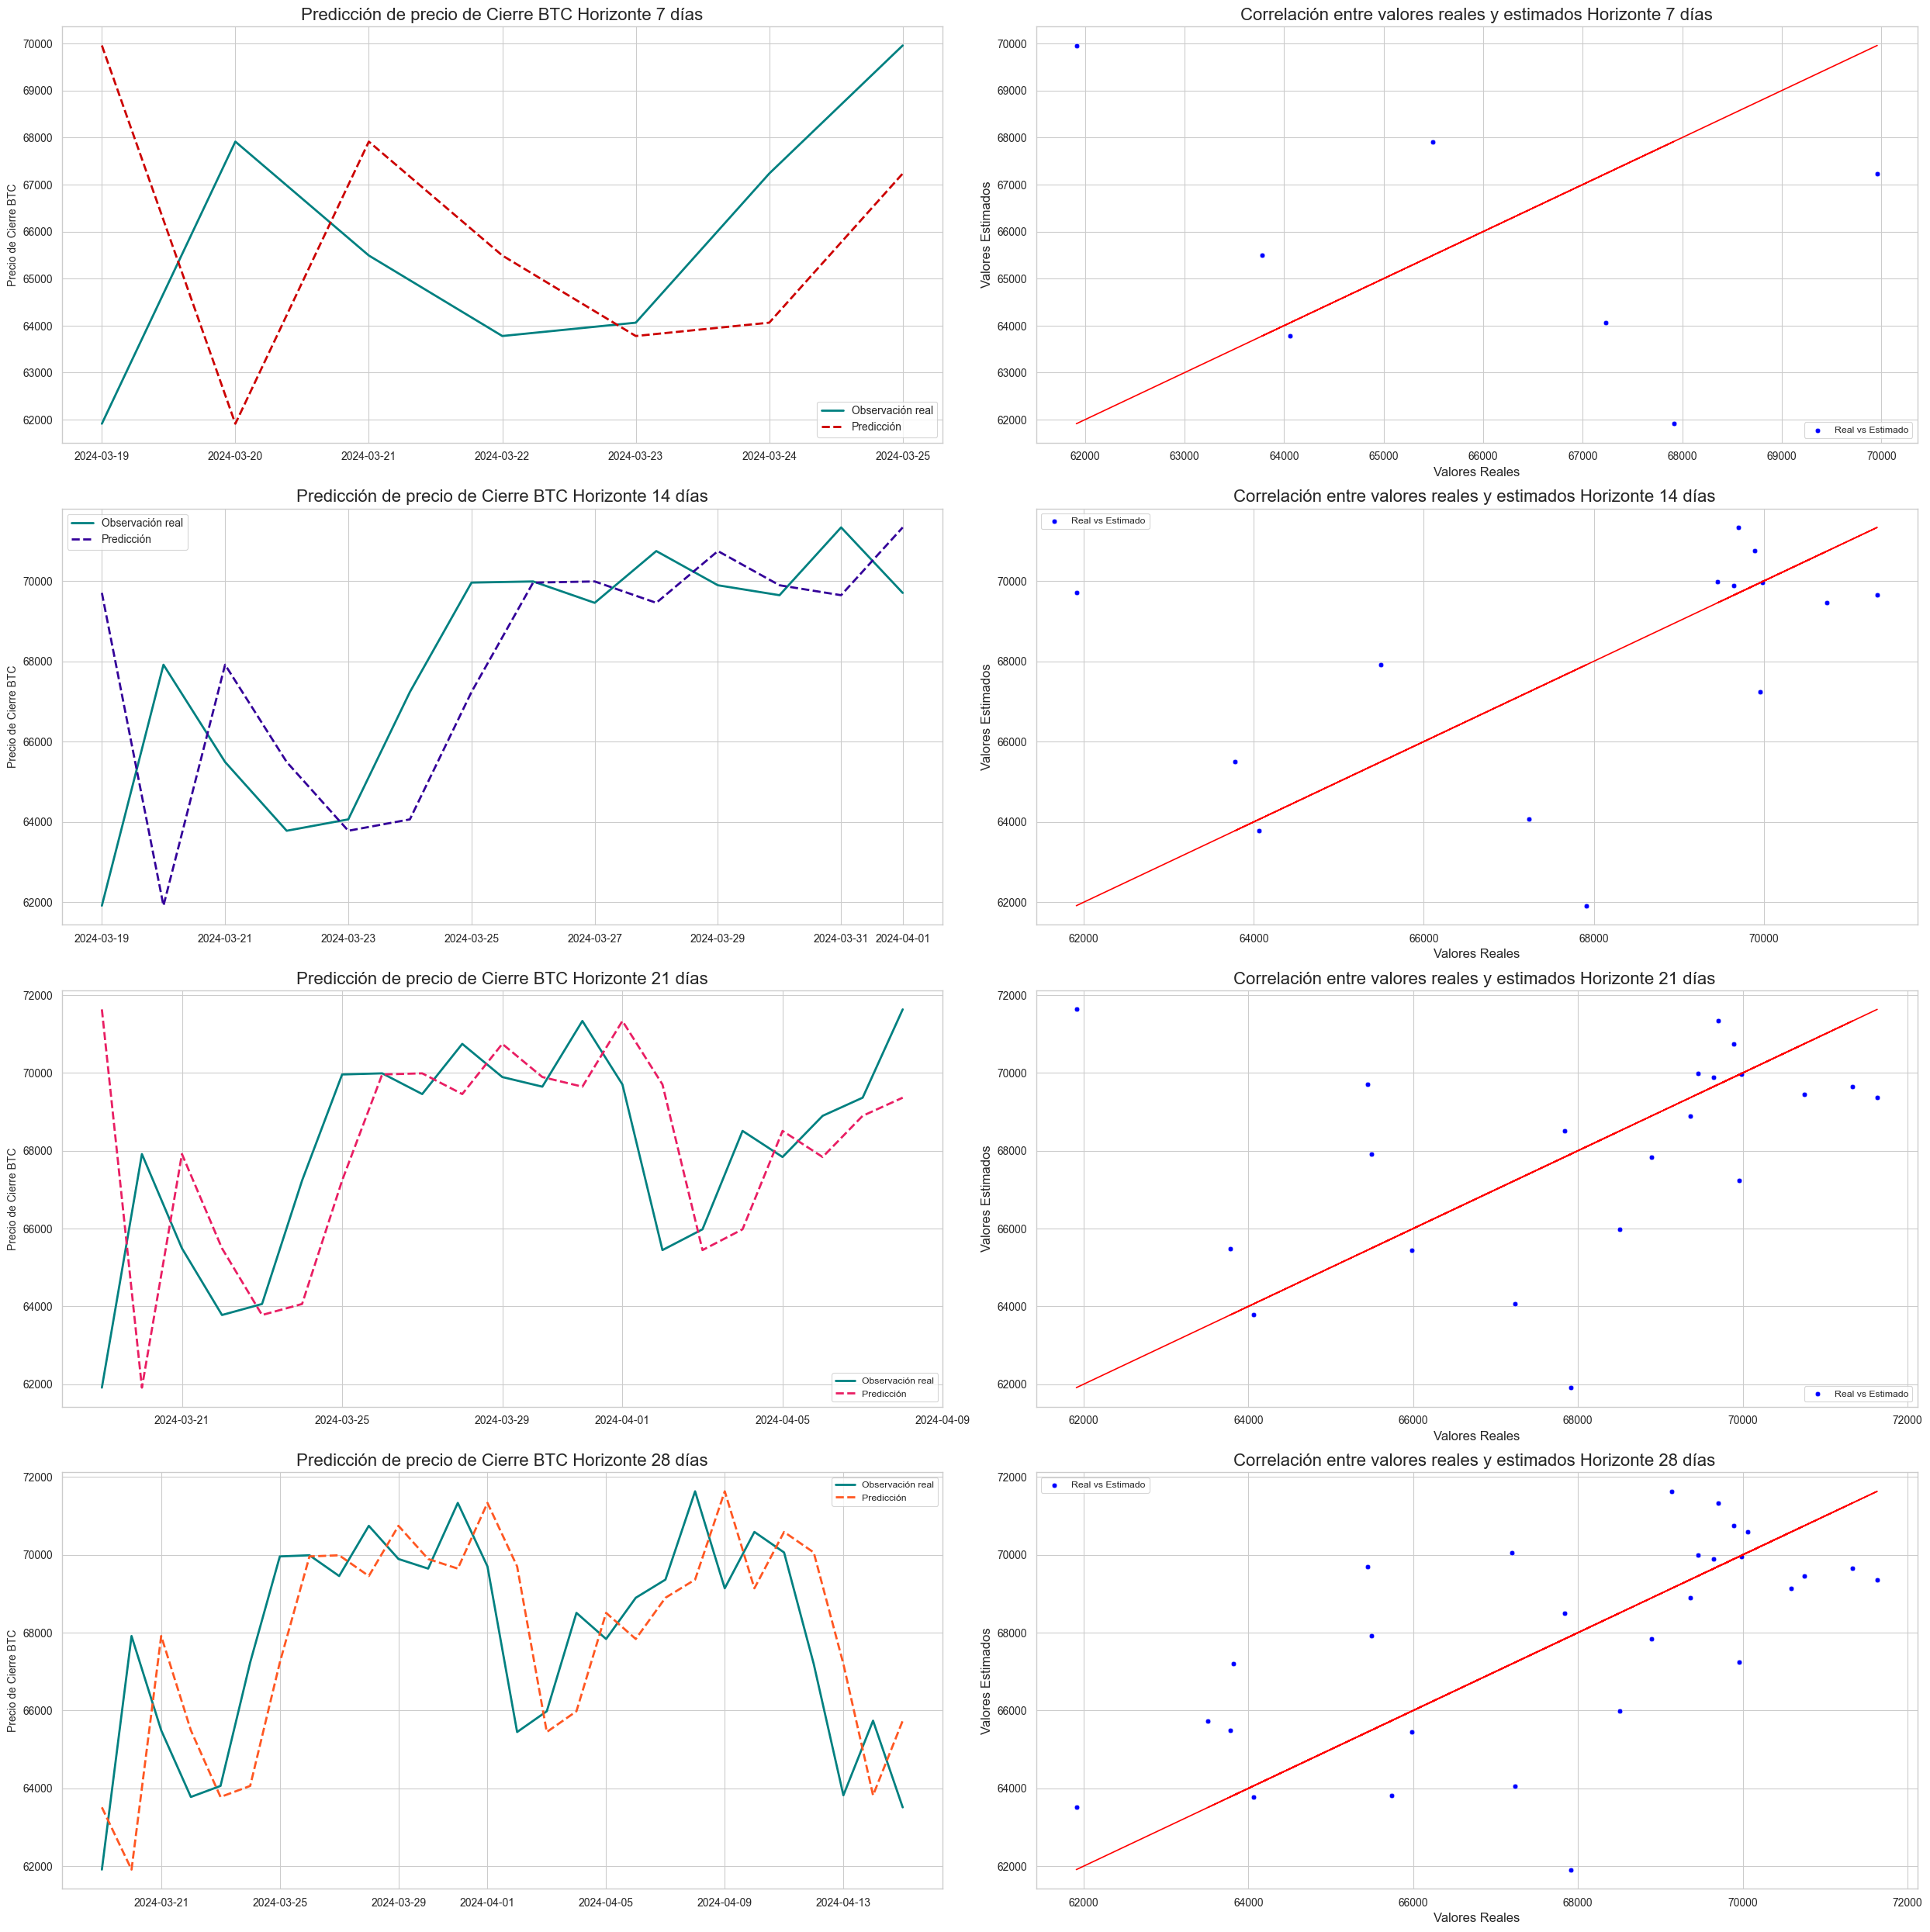

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))  # Crear la figura y el eje de la subtrama

# Gráfica horizonte 7 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_7, y=test_7, ax=axes[0,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=yhat_7_HQIC, ax=axes[0,0], label='Predicción', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0,0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[0,0].set_xlabel(None)
axes[0,0].legend(fontsize=10) # Mostrar la leyenda
axes[0,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[0,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_7l, y=yhat_7_HQIC, ax=axes[0,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[0,1].plot(test_7l, test_7l, color='red', label='Correlación')
axes[0,1].set_title('Correlación entre valores reales y estimados Horizonte 7 días', fontsize=16)
axes[0,1].set_xlabel('Valores Reales', fontsize=12)
axes[0,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[0,1].legend(fontsize=10)  # Mostrar la leyenda
axes[0,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[0,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)

# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_14, y=test_14, ax=axes[1,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=yhat_14_HQIC, ax=axes[1,0], label='Predicción', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1,0].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[1,0].set_xlabel(None)
axes[1,0].legend(fontsize=10) # Mostrar la leyenda
axes[1,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[1,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_14l, y=yhat_14_HQIC, ax=axes[1,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[1,1].plot(test_14l, test_14l, color='red', label='Correlación')
axes[1,1].set_title('Correlación entre valores reales y estimados Horizonte 14 días ', fontsize=16)
axes[1,1].set_xlabel('Valores Reales', fontsize=12)
axes[1,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[1,1].legend(fontsize=10)  # Mostrar la leyenda
axes[1,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[1,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 21 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_21, y=test_21, ax=axes[2,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=yhat_21_HQIC, ax=axes[2,0], label='Predicción', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2,0].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[2,0].set_xlabel(None)
#axes[2,0].legend(fontsize=10) # Mostrar la leyenda
axes[2,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[2,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_21l, y=yhat_21_HQIC, ax=axes[2,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[2,1].plot(test_21l, test_21l, color='red', label='Correlación')
axes[2,1].set_title('Correlación entre valores reales y estimados Horizonte 21 días ', fontsize=16)
axes[2,1].set_xlabel('Valores Reales', fontsize=12)
axes[2,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[2,1].legend(fontsize=10)  # Mostrar la leyenda
axes[2,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[2,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 28 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_28, y=test_28, ax=axes[3,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=yhat_28_HQIC, ax=axes[3,0], label='Predicción', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3,0].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[3,0].set_xlabel(None)
#axes[3,0].legend(fontsize=10) # Mostrar la leyenda
axes[3,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[3,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_28l, y=yhat_28_HQIC, ax=axes[3,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[3,1].plot(test_28l, test_28l, color='red', label='Correlación')
axes[3,1].set_title('Correlación entre valores reales y estimados Horizonte 28 días ', fontsize=16)
axes[3,1].set_xlabel('Valores Reales', fontsize=12)
axes[3,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[3,1].legend(fontsize=10)  # Mostrar la leyenda
axes[3,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[3,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)



plt.tight_layout()  # Ajustar el espaciado entre subgráficos
plt.show()

El gráfico muestra predicciones para diferentes horizontes temporales (7, 14, 21 y 28 días) junto con observaciones reales de prueba. También se incluye un gráfico que correlaciona las predicciones con estas observaciones reales.
En relación al primer gráfico del precio de cierre del Bitcoin, se aprecia que ambas líneas siguen tendencias similares y están próximas entre sí, lo que indica errores bajos. Sin embargo, se observa un sesgo en el tiempo que podría corregirse mediante mejoras en el modelo o la exploración de otras opciones que expliquen con mayor precisión la variabilidad en el tiempo. 
Los gráficos de autocorrelación revelan la ausencia de una correlación significativa entre los valores de la serie temporal y sus antecesores en los intervalos de 7, 14, 21 y 28 días. En resumen, no se observa un patrón claro o repetitivo en los datos a lo largo de estos horizontes.

* **Gráfico de Correlación ejercicio 3  (Sin utilizar rolling)**. 

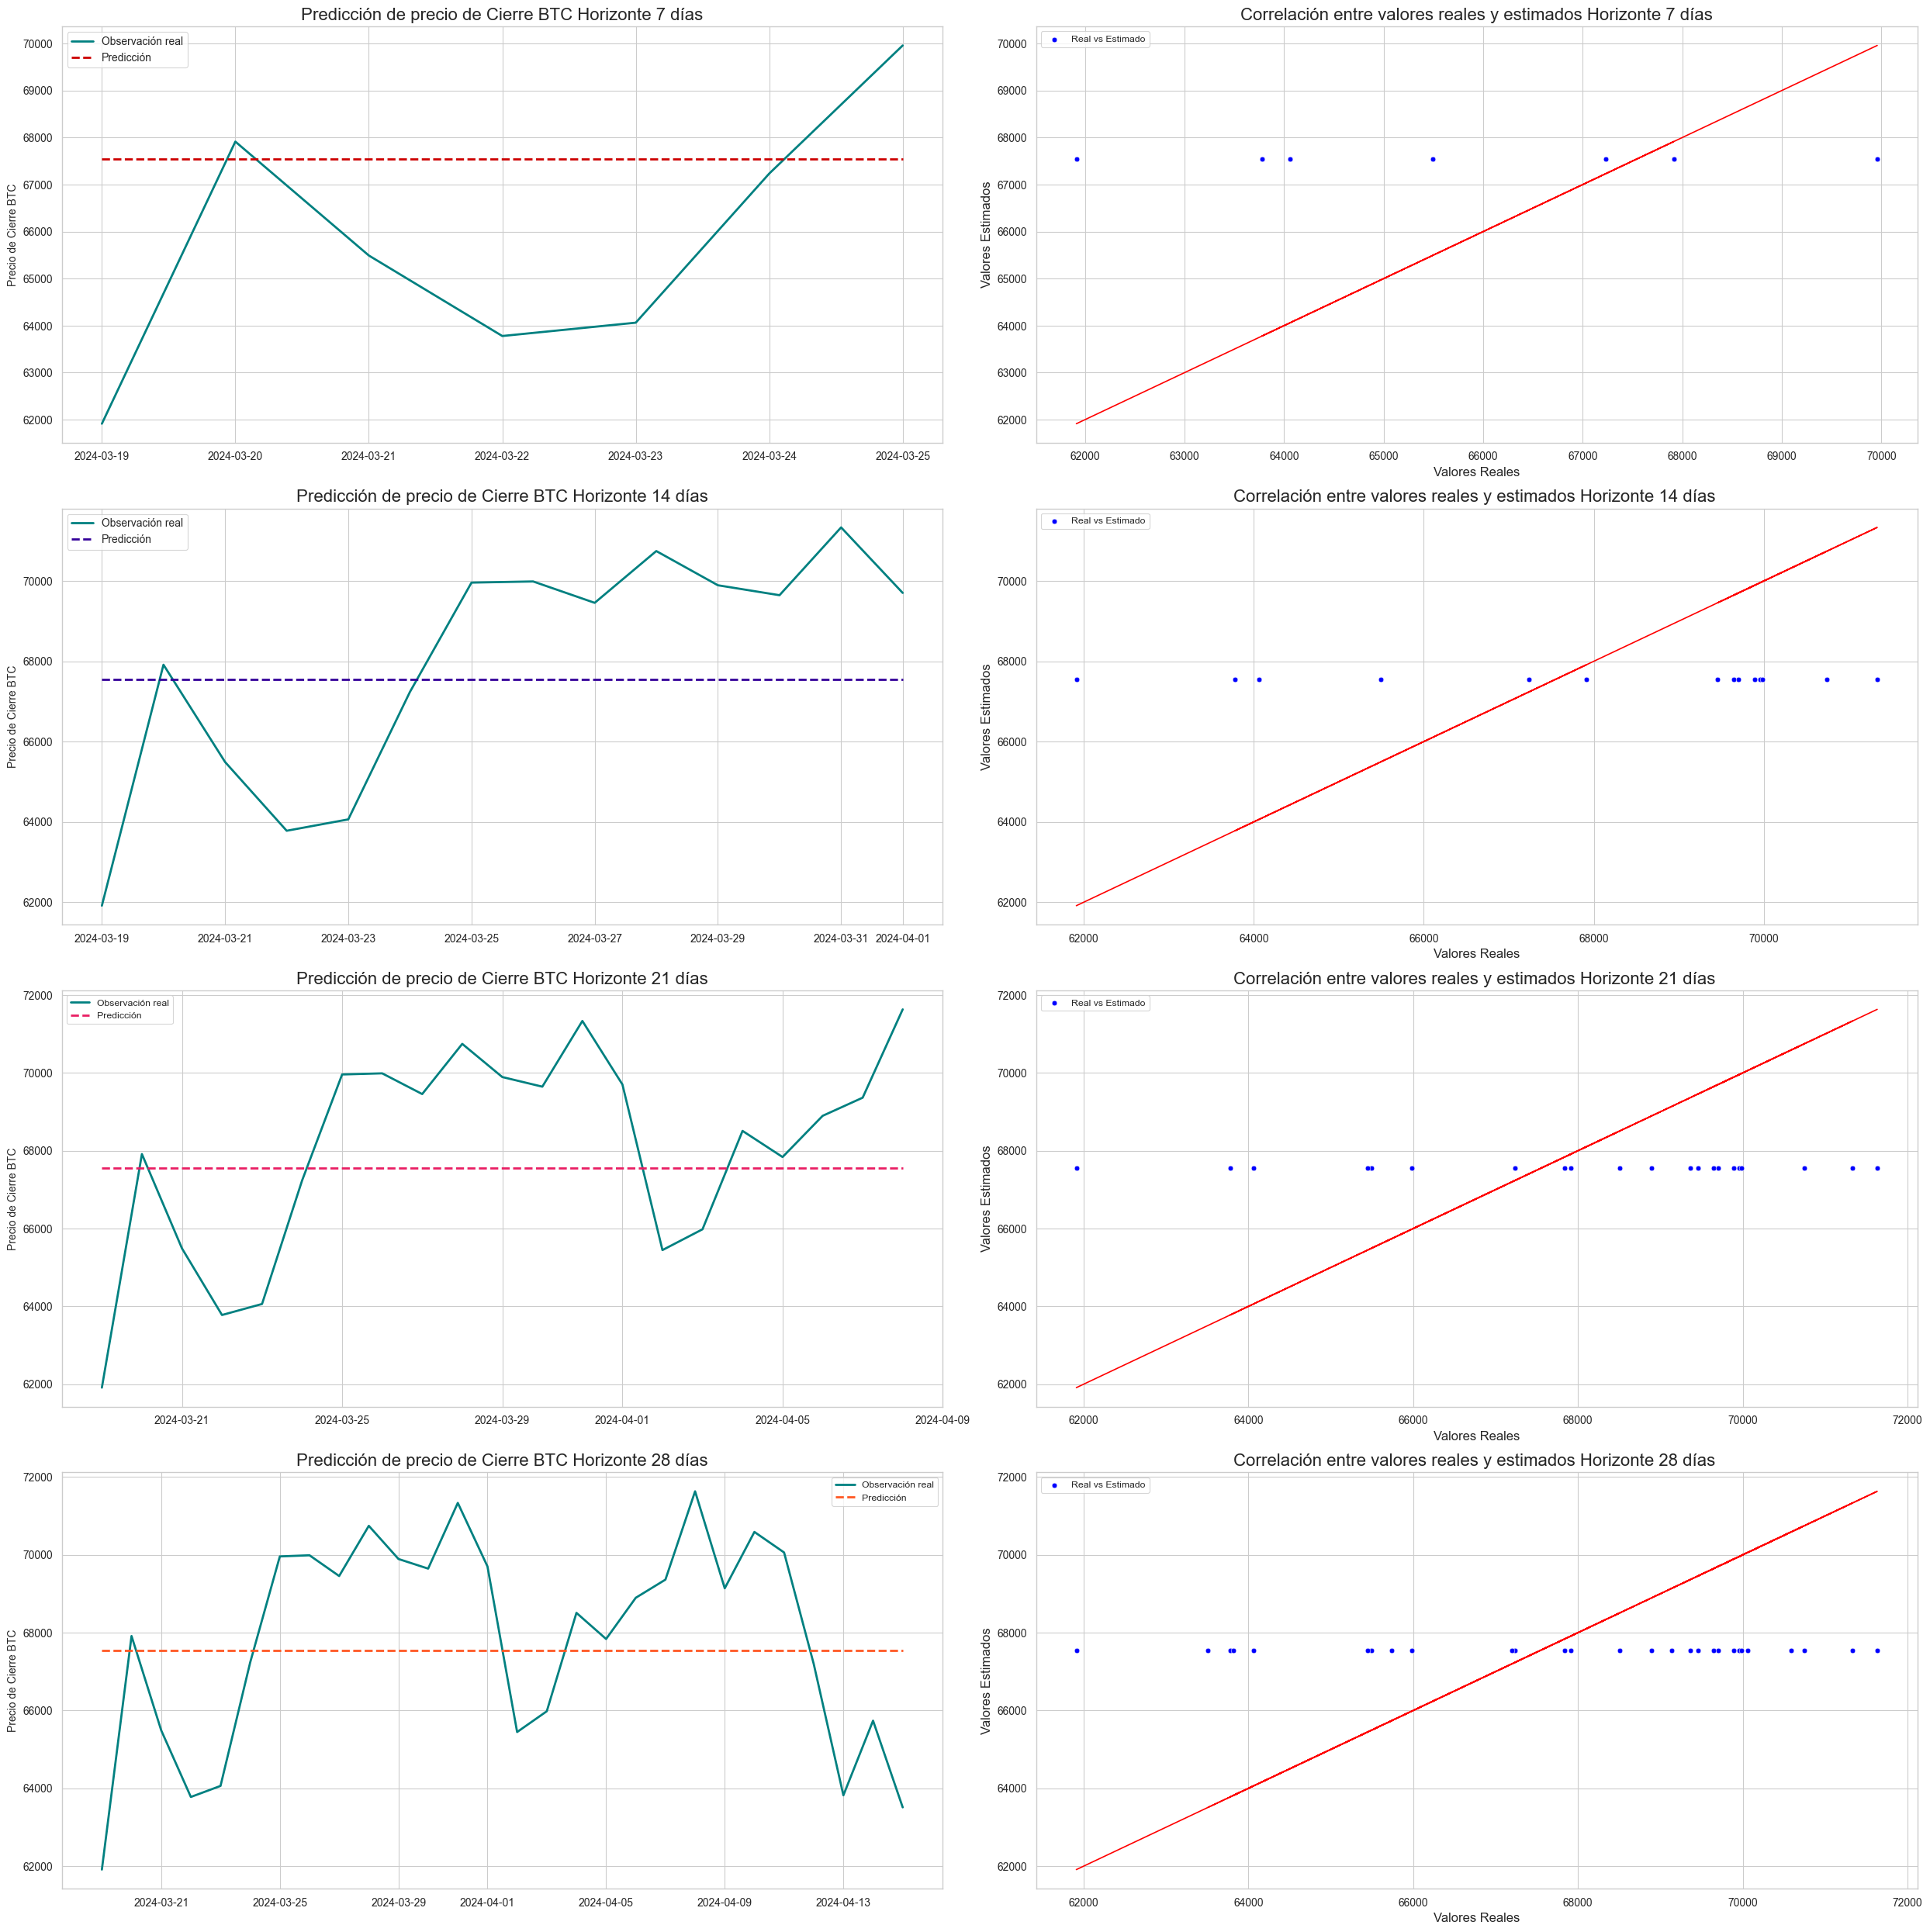

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))  # Crear la figura y el eje de la subtrama

# Gráfica horizonte 7 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_7, y=test_7, ax=axes[0,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_7, y=predic_forecast7HQIC, ax=axes[0,0], label='Predicción', color='#CC0000', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[0,0].set_title('Predicción de precio de Cierre BTC Horizonte 7 días', fontsize=16)
axes[0,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[0,0].set_xlabel(None)
axes[0,0].legend(fontsize=10) # Mostrar la leyenda
axes[0,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[0,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_7l, y=predic_forecast7HQIC, ax=axes[0,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[0,1].plot(test_7l, test_7l, color='red', label='Correlación')
axes[0,1].set_title('Correlación entre valores reales y estimados Horizonte 7 días', fontsize=16)
axes[0,1].set_xlabel('Valores Reales', fontsize=12)
axes[0,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[0,1].legend(fontsize=10)  # Mostrar la leyenda
axes[0,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[0,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)

# Gráfica horizonte 14 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_14, y=test_14, ax=axes[1,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_14, y=predic_forecast14HQIC, ax=axes[1,0], label='Predicción', color='#330099', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[1,0].set_title('Predicción de precio de Cierre BTC Horizonte 14 días', fontsize=16)
axes[1,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[1,0].set_xlabel(None)
axes[1,0].legend(fontsize=10) # Mostrar la leyenda
axes[1,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[1,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_14l, y=predic_forecast14HQIC, ax=axes[1,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[1,1].plot(test_14l, test_14l, color='red', label='Correlación')
axes[1,1].set_title('Correlación entre valores reales y estimados Horizonte 14 días ', fontsize=16)
axes[1,1].set_xlabel('Valores Reales', fontsize=12)
axes[1,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[1,1].legend(fontsize=10)  # Mostrar la leyenda
axes[1,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[1,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 21 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_21, y=test_21, ax=axes[2,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_21, y=predic_forecast21HQIC, ax=axes[2,0], label='Predicción', color='#E91E63', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[2,0].set_title('Predicción de precio de Cierre BTC Horizonte 21 días', fontsize=16)
axes[2,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[2,0].set_xlabel(None)
#axes[2,0].legend(fontsize=10) # Mostrar la leyenda
axes[2,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[2,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_21l, y=predic_forecast21HQIC, ax=axes[2,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[2,1].plot(test_21l, test_21l, color='red', label='Correlación')
axes[2,1].set_title('Correlación entre valores reales y estimados Horizonte 21 días ', fontsize=16)
axes[2,1].set_xlabel('Valores Reales', fontsize=12)
axes[2,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[2,1].legend(fontsize=10)  # Mostrar la leyenda
axes[2,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[2,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)


# Gráfica horizonte 28 días.

#Gráfica valores de prueba vs estimado
sns.lineplot(x=dates_28, y=test_28, ax=axes[3,0], label='Observación real', color='#008080', linewidth=2)# Trama de línea para los datos de prueba
sns.lineplot(x=dates_28, y=predic_forecast28HQIC, ax=axes[3,0], label='Predicción', color='#FF5722', linewidth=2, linestyle='--') # Trama de línea para los datos de pronóstico
axes[3,0].set_title('Predicción de precio de Cierre BTC Horizonte 28 días', fontsize=16)
axes[3,0].set_ylabel('Precio de Cierre BTC', fontsize=10)
axes[3,0].set_xlabel(None)
#axes[3,0].legend(fontsize=10) # Mostrar la leyenda
axes[3,0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axes[3,0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)
# Gráfico de dispersión para la correlación entre los valores reales y estimados
sns.scatterplot(x=test_28l, y=predic_forecast28HQIC, ax=axes[3,1], color='blue', label='Real vs Estimado')  
# Línea de referencia para una correlación perfecta
axes[3,1].plot(test_28l, test_28l, color='red', label='Correlación')
axes[3,1].set_title('Correlación entre valores reales y estimados Horizonte 28 días ', fontsize=16)
axes[3,1].set_xlabel('Valores Reales', fontsize=12)
axes[3,1].set_ylabel('Valores Estimados', fontsize=12)
#axes[3,1].legend(fontsize=10)  # Mostrar la leyenda
axes[3,1].tick_params(axis='x', labelsize=10)  # Tamaño de las etiquetas del eje x (inferior)
axes[3,1].tick_params(axis='y', labelsize=10)  # Tamaño de las etiquetas del eje y (izquierdo)



plt.tight_layout()  # Ajustar el espaciado entre subgráficos
plt.show()

En el primer gráfico del precio de cierre del Bitcoin, se nota una discrepancia notable entre las observaciones reales de prueba y las predicciones, lo que sugiere la presencia de errores considerables. Por otro lado, los gráficos de autocorrelación no muestran una correlación significativa entre los valores de la serie temporal y sus antecedentes en los intervalos de 7, 14, 21 y 28 días. En resumen, no se identifica un patrón claro o repetitivo en los datos a lo largo de estos horizontes.

En términos de predicción del precio del Bitcoin, se puede concluir que el modelo ARIMA utilizando la técnica de rolling ofrece un rendimiento superior en comparación con el otro modelo considerado (ARIMA sin utilizar rolling). 

### Ejercicio 6.

Realice **tests de normalidad e independencia para los residuales** obtenidos para cada predicción, en cada caso agregue las correspondientes conclusiones. 

#### Test de Normalidad de los residuales a través de Kolmogorov-Smirnov

* Planteamiento de Hipótesis: 

$$ H_0 : \text{Residuales se distribuyen normalmente}$$ 
$$ H_1 : \text{Residuales no se distribuyen normalmente}$$

* Críterios de aceptación y/o rechazo: 

Sí el  P-value $< 0.05 $, se rechaza la hipótesis nula con un a significancia $ \alpha = 0.05$, es decir que los datos no siguen una distribución normal.


#### Test de Independiencia de los residuales a través del Estadístico de Durbin Watson

El estadístico de Durbin-Watson (DW) es una medida utilizada para evaluar la presencia de autocorrelación en los residuos de un modelo de regresión, éste toma valores entre 0 y 4. Un valor de DW cercano a 2 sugiere que no hay autocorrelación serial en los residuos. Esto significa que los residuos en un momento dado no están correlacionados con los residuos en momentos anteriores. Un valor de 2 implica la ausencia total de autocorrelación.Cuando el valor de DW se acerca a 0, indica autocorrelación positiva en los residuos. Esto significa que los residuos en un momento dado están correlacionados positivamente con los residuos en momentos anteriores. Por otro lado, si el valor de DW se acerca a 4, indica autocorrelación negativa en los residuos.

#### Análisis de residuales bajo el criterio Criterio de Información de Akaike (AIC). 

In [273]:
ei_AIC = model_fit.resid

# Prueba de normalidad de Kolmogorov-Smirnov
ks_result = kstest(ei_AIC, 'norm')
print("Prueba de Kolmogorov-Smirnov: ")
print("Estadístico:", ks_result.statistic)
print("Valor p:", ks_result.pvalue)

Prueba de Kolmogorov-Smirnov: 
Estadístico: 0.48089248382740535
Valor p: 0.0


Dado que el P-value $=0.0 < 0.05$ hay evidencia significativa para rechazar la hipótesis nula con una significancia $\alpha = 0.05$, es decir que los residuos `no siguen una distribución.normal`

In [274]:
# Prueba de Durbin-Watson
durbin_watson_statistic = sm.stats.stattools.durbin_watson(ei_AIC)
print("Estadístico de Durbin-Watson:", durbin_watson_statistic)

Estadístico de Durbin-Watson: 2.0001304493545944


Dado que el estadístico de Durbin_Watson $ = 2$, se puede afirmar que no existe una correlacion serial en los residuales. 

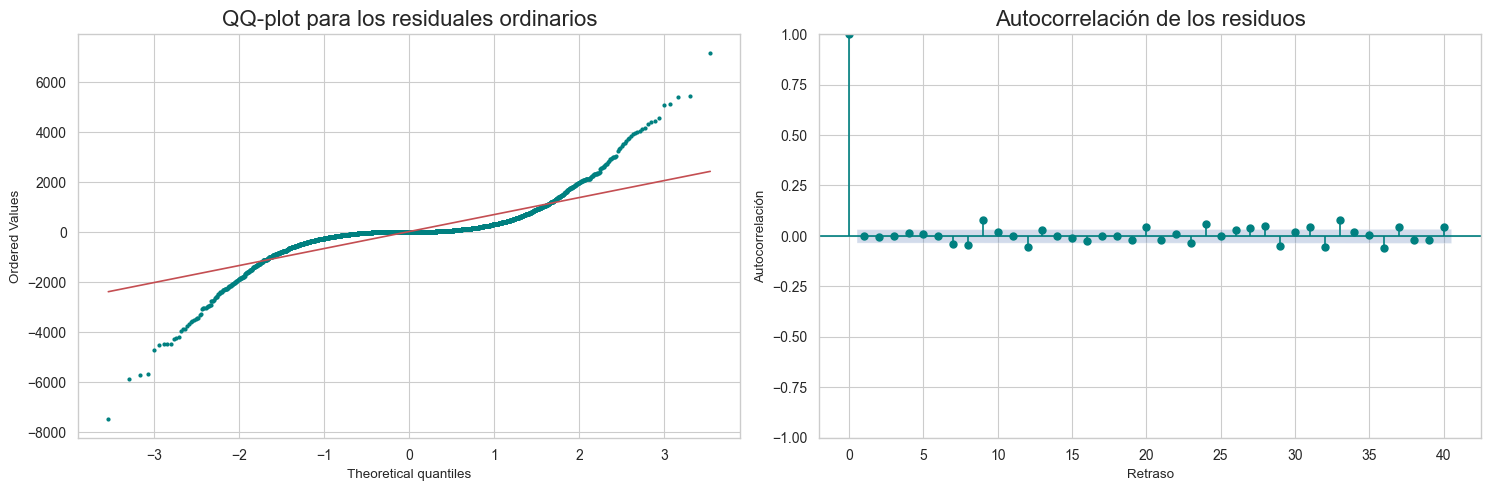

In [275]:
# Gráficos QQ-plot y Autocorrelación en una sola figura
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# QQ-plot para los residuales
stats.probplot(ei_AIC, dist="norm", plot=axs[0])
axs[0].get_lines()[0].set_color('#008080')  # Establecer el color del gráfico
axs[0].get_lines()[0].set_markersize(2)     # Establecer el tamaño de los puntos
axs[0].set_title('QQ-plot para los residuales ordinarios', fontsize=16)
axs[0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axs[0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)

# Autocorrelación de los residuos
sm.graphics.tsa.plot_acf(ei_AIC, lags=40, ax=axs[1], color='#008080', vlines_kwargs={"colors": '#008080'})
axs[1].set_xlabel('Retraso')
axs[1].set_ylabel('Autocorrelación')
axs[1].set_title('Autocorrelación de los residuos', fontsize=16)
axs[1].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axs[1].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

Basándonos en el gráfico anterior, podemos concluir que, si bien los residuos no siguen estrictamente una distribución normal, sí se observa que cumplen con el supuesto de independencia. Esto se refiere a que los residuos no muestran patrones discernibles en su distribución a lo largo del tiempo, lo que sugiere que están aleatoriamente dispersos. Es importante destacar que este análisis se realiza con un horizonte de 7 días utilizando el criterio AIC.

Gráfica de residuos del modelo ARIMA AIC

#### Análisis de residuales bajo el criterio Criterio de inferencia Bayesiana (BIC). 

In [276]:
ei_BIC = model_fit_BIC.resid

# Prueba de normalidad de Kolmogorov-Smirnov
ks_result = kstest(ei_BIC, 'norm')
print("Prueba de Kolmogorov-Smirnov: ")
print("Estadístico:", ks_result.statistic)
print("Valor p:", ks_result.pvalue)

Prueba de Kolmogorov-Smirnov: 
Estadístico: 0.4781400091695718
Valor p: 0.0


Dado que el P-value $=0.0 < 0.05$ hay evidencia significativa para rechazar la hipótesis nula con una significancia $\alpha = 0.05$, es decir que los residuos `no siguen una distribución.normal`

In [277]:
# Prueba de Durbin-Watson
durbin_watson_statistic = sm.stats.stattools.durbin_watson(ei_BIC)
print("Estadístico de Durbin-Watson:", durbin_watson_statistic)

Estadístico de Durbin-Watson: 2.0664711792256947


Dado que el estadístico de Durbin_Watson $ = 2,066$, se puede afirmar que no existe una correlacion serial en los residuales. 

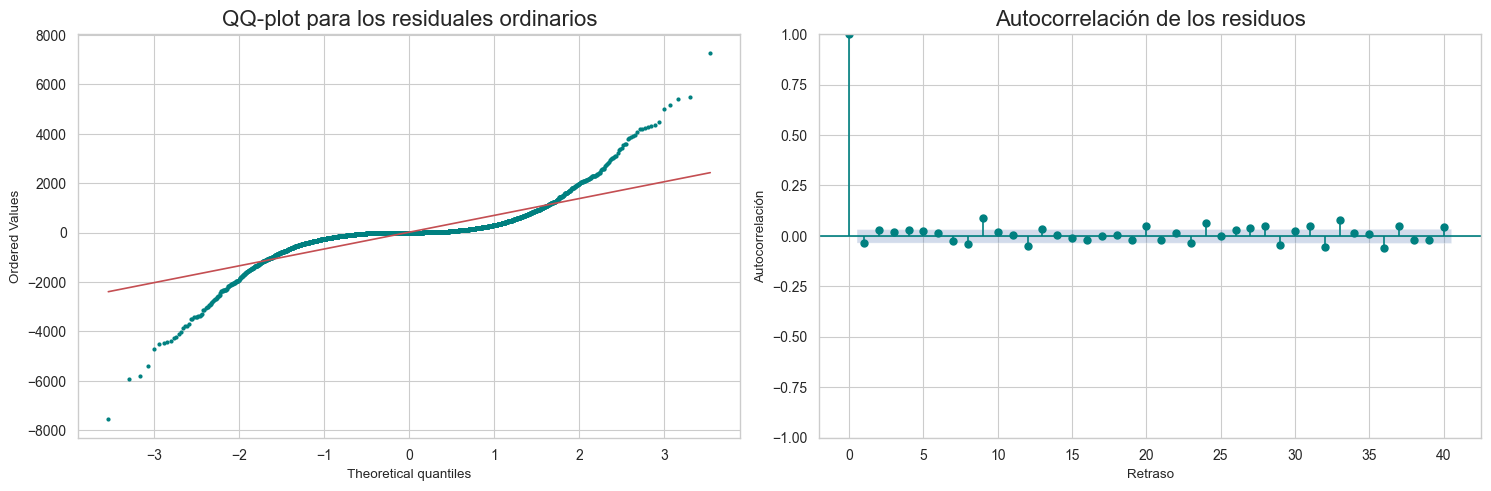

In [278]:
# Gráficos QQ-plot y Autocorrelación en una sola figura
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# QQ-plot para los residuales
stats.probplot(ei_BIC, dist="norm", plot=axs[0])
axs[0].get_lines()[0].set_color('#008080')  # Establecer el color del gráfico
axs[0].get_lines()[0].set_markersize(2)     # Establecer el tamaño de los puntos
axs[0].set_title('QQ-plot para los residuales ordinarios', fontsize=16)
axs[0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axs[0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)

# Autocorrelación de los residuos
sm.graphics.tsa.plot_acf(ei_BIC, lags=40, ax=axs[1], color='#008080', vlines_kwargs={"colors": '#008080'})
axs[1].set_xlabel('Retraso')
axs[1].set_ylabel('Autocorrelación')
axs[1].set_title('Autocorrelación de los residuos', fontsize=16)
axs[1].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axs[1].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

Basándonos en el gráfico anterior, podemos concluir que, si bien los residuos no siguen estrictamente una distribución normal, sí se observa que cumplen con el supuesto de independencia. Esto se refiere a que los residuos no muestran patrones discernibles en su distribución a lo largo del tiempo, lo que sugiere que están aleatoriamente dispersos. Es importante destacar que este análisis se realiza con un horizonte de 7 días utilizando el criterio BIC.

#### Análisis de residuales bajo el Criterio de información de Hannan-Quinn (HQIC). 

In [279]:
ei_HQIC = model_fit_HQIC.resid

# Prueba de normalidad de Kolmogorov-Smirnov
ks_result = kstest(ei_HQIC, 'norm')
print("Prueba de Kolmogorov-Smirnov: ")
print("Estadístico:", ks_result.statistic)
print("Valor p:", ks_result.pvalue)

Prueba de Kolmogorov-Smirnov: 
Estadístico: 0.4781400091695718
Valor p: 0.0


Dado que el P-value $=0.0 < 0.05$ hay evidencia significativa para rechazar la hipótesis nula con una significancia $\alpha = 0.05$, es decir que los residuos `no siguen una distribución.normal`

In [280]:
# Prueba de Durbin-Watson
durbin_watson_statistic = sm.stats.stattools.durbin_watson(ei_HQIC)
print("Estadístico de Durbin-Watson:", durbin_watson_statistic)

Estadístico de Durbin-Watson: 2.0664711792256947


Dado que el estadístico de Durbin_Watson $ = 2,066$, se puede afirmar que no existe una correlacion serial en los residuales. 

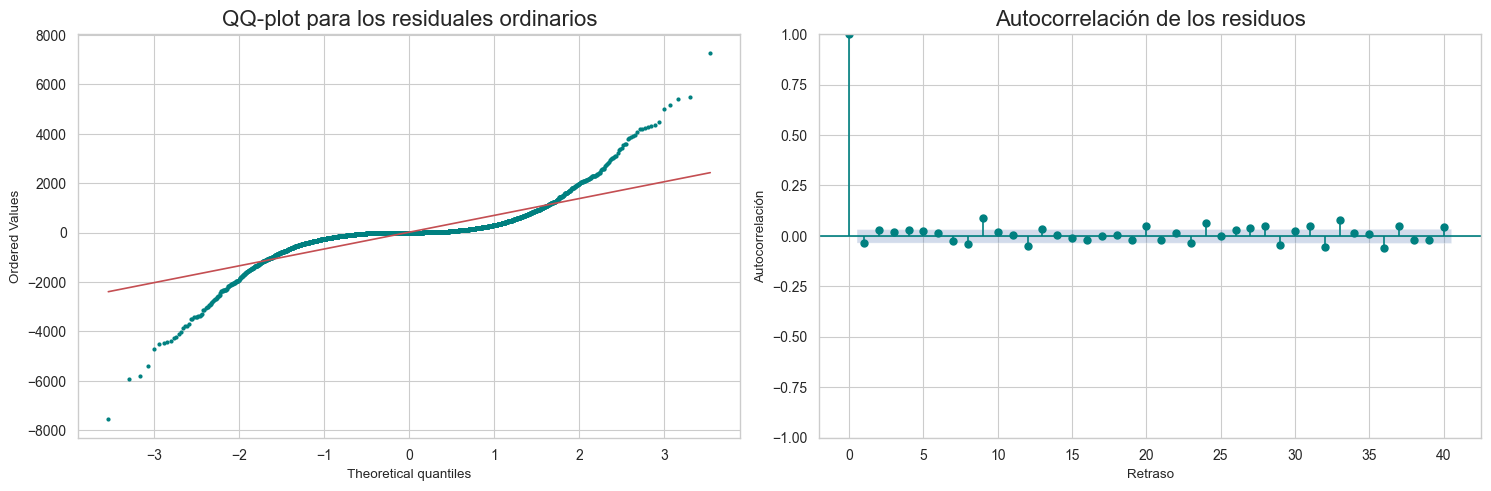

In [281]:
# Gráficos QQ-plot y Autocorrelación en una sola figura
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# QQ-plot para los residuales
stats.probplot(ei_HQIC, dist="norm", plot=axs[0])
axs[0].get_lines()[0].set_color('#008080')  # Establecer el color del gráfico
axs[0].get_lines()[0].set_markersize(2)     # Establecer el tamaño de los puntos
axs[0].set_title('QQ-plot para los residuales ordinarios', fontsize=16)
axs[0].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axs[0].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)

# Autocorrelación de los residuos
sm.graphics.tsa.plot_acf(ei_HQIC, lags=40, ax=axs[1], color='#008080', vlines_kwargs={"colors": '#008080'})
axs[1].set_xlabel('Retraso')
axs[1].set_ylabel('Autocorrelación')
axs[1].set_title('Autocorrelación de los residuos', fontsize=16)
axs[1].tick_params(axis='x', labelsize=10)  # Solo para el eje x (inferior)
axs[1].tick_params(axis='y', labelsize=10)  # Solo para el eje y (izquierdo)

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

Basándonos en el gráfico anterior, podemos concluir que, si bien los residuos no siguen estrictamente una distribución normal, sí se observa que cumplen con el supuesto de independencia. Esto se refiere a que los residuos no muestran patrones discernibles en su distribución a lo largo del tiempo, lo que sugiere que están aleatoriamente dispersos. Es importante destacar que este análisis se realiza con un horizonte de 7 días utilizando el criterio HQIC.

## Conclusión:

En términos generales, basados en los resultados obtenidos en este informe, podemos afirmar que el modelo ARIMA que mejor ajusta las predicciones de nuestra serie temporal es el modelo ARIMA bajo el criterio de Información de Akaike (AIC). Este modelo demostró ser el más adecuado para capturar la complejidad inherente de la serie temporal y producir predicciones precisas y confiables para los datos futuros en comparación con los criterios inferencia Bayesiana (BIC) e información de Hannan-Quinn (HQIC). 

Sin embargo, el modelo obtenido utilizando el criterio de Información de Akaike (AIC) y aplicando la técnica de Rolling no logra explicar con precisión el comportamiento del precio de cierre de las acciones de Bitcoin. Este resultado posiblemente se deba a la complejidad inherente de la serie temporal asociada con dicho comportamiento. En consecuencia, se sugiere al lector considerar el empleo de otras técnicas para la búsqueda y construcción de un modelo más efectivo y adecuado para la predicción del precio de cierre del Bitcoin.